In [1]:
import json
import os
import numpy as np
import pandas as pd
# import lightgbm as lgbm
from datetime import datetime
from time import gmtime, strftime
from scipy import stats
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_data = pd.read_csv('final_features.csv')

# glove
glove_tags = pd.read_csv('alltags_feature.csv')
glove_title = pd.read_csv('title_feature.csv')
all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)

In [3]:
train_all_data, submit_all_data = train_test_split(all_data, stratify=all_data['Category'], test_size=0.2, random_state=42)

In [4]:
# train_all_data = all_data[all_data['train_type'] != -1]
# submit_all_data = all_data[all_data['train_type'] == -1]

train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'label', 'mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

print(len(train_feature_df), len(submit_feature_df))
print(len(train_label_df), len(submit_label_df))

201036 50259
201036 50259


In [5]:
pip install scikit-learn catboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

cb_params = {
    'objective': 'RMSE',
    'eval_metric': 'MAE',
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'max_ctr_complexity': 1,
    'depth': 8,
    'leaf_estimation_method': 'Gradient',
    'use_best_model': True,
    'iterations': 10000,
    'early_stopping_rounds': 50,
    'verbose': 3
}


cate_cols = ['Category', 'Subcategory', 'Concept', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday',
             'Geoaccuracy', 'ispro' , 'img_model']
submit_data = Pool(data=submit_feature_df, label=submit_label_df['label'], cat_features=cate_cols)


valid_ans = []
submit_proba = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2020)
best_mae = float('inf')
best_model = None
model_save_path = r'C:\Users\Siddharth\Untitled Folder\DL_Project\saved_models'

for n, (train_idx, valid_idx) in enumerate(kfold.split(train_feature_df, train_label_df)):
    fold_train_x, fold_train_y = train_feature_df.loc[train_idx], train_label_df['label'].loc[train_idx]
    fold_valid_x, fold_valid_y = train_feature_df.loc[valid_idx], train_label_df['label'].loc[valid_idx]
    
    train_data = Pool(data=fold_train_x, label=fold_train_y, cat_features=cate_cols)
    valid_data = Pool(data=fold_valid_x, label=fold_valid_y, cat_features=cate_cols)
    
    cb_model=CatBoostRegressor(**cb_params)
    cb_model.fit(train_data, eval_set=valid_data)
    
    valid_pred = cb_model.predict(valid_data)
    valid_rmse = np.sqrt(mean_squared_error(fold_valid_y, valid_pred))
    valid_mae = mean_absolute_error(fold_valid_y, valid_pred)
    valid_src = stats.spearmanr(fold_valid_y, valid_pred)[0]
    
    print("RMSE: %.4f, MAE: %.4f, SRC: %.4f"%(valid_rmse, valid_mae, valid_src))
    
    # Check if this model is the best so far
    if valid_mae < best_mae:
        best_mae = valid_mae
        best_model = cb_model
        best_actuals = fold_valid_y
        best_predictions = valid_pred
        # Save the best model
        best_model.save_model(os.path.join(model_save_path, 'catboost_best_model_10000.pkl'))
    
    valid_ans.append([valid_rmse, valid_mae, valid_src])
        
    submit_pred = cb_model.predict(submit_data)
    submit_proba.append(submit_pred)

valid_ans = np.mean(valid_ans, axis=0)
print("valid: RMSE: %.4f, MAE: %.4f, SRC: %.4f"%(valid_ans[0], valid_ans[1], valid_ans[2]))

# Evaluate performance on test data
submit_actuals = submit_label_df['label']
submit_predictions = best_model.predict(submit_feature_df)
test_rmse = np.sqrt(mean_squared_error(submit_actuals, submit_predictions))
test_mae = mean_absolute_error(submit_actuals, submit_predictions)
test_src = stats.spearmanr(submit_actuals, submit_predictions)[0]

# Print test metrics
print(f"Test: RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, SRC: {test_src:.4f}")

# save result json
submit_ans = np.mean(submit_proba, axis=0)
result = pd.DataFrame()
result['post_id'] = submit_label_df['Pid'].apply(lambda x: 'post' + str(x))
result['popularity_score'] = submit_ans.round(decimals=4)

out_json = dict()
out_json["version"] = "VERSION 1.0"
out_json["result"] = result.to_dict(orient='records')
out_json["external_data"] = {"used": "true", "details": "catboost"}
f = open('KFold_catboost_10000.json', "w")
json.dump(out_json, f)
f.close()

0:	learn: 1.9156729	test: 1.9099525	best: 1.9099525 (0)	total: 951ms	remaining: 2h 38m 30s
3:	learn: 1.8566920	test: 1.8512310	best: 1.8512310 (3)	total: 2.56s	remaining: 1h 46m 30s
6:	learn: 1.8051426	test: 1.7998803	best: 1.7998803 (6)	total: 4.17s	remaining: 1h 39m 12s
9:	learn: 1.7590411	test: 1.7543178	best: 1.7543178 (9)	total: 5.98s	remaining: 1h 39m 30s
12:	learn: 1.7164496	test: 1.7122805	best: 1.7122805 (12)	total: 7.89s	remaining: 1h 41m 1s
15:	learn: 1.6787980	test: 1.6752274	best: 1.6752274 (15)	total: 9.7s	remaining: 1h 40m 52s
18:	learn: 1.6451757	test: 1.6419771	best: 1.6419771 (18)	total: 11.4s	remaining: 1h 39m 50s
21:	learn: 1.6136717	test: 1.6111270	best: 1.6111270 (21)	total: 13.4s	remaining: 1h 41m 9s
24:	learn: 1.5844428	test: 1.5824413	best: 1.5824413 (24)	total: 15s	remaining: 1h 39m 57s
27:	learn: 1.5579702	test: 1.5565489	best: 1.5565489 (27)	total: 16.6s	remaining: 1h 38m 31s
30:	learn: 1.5246681	test: 1.5237859	best: 1.5237859 (30)	total: 18.2s	remaining: 1

261:	learn: 1.0138418	test: 1.0189225	best: 1.0189225 (261)	total: 2m 18s	remaining: 1h 25m 51s
264:	learn: 1.0116432	test: 1.0169044	best: 1.0169044 (264)	total: 2m 20s	remaining: 1h 25m 43s
267:	learn: 1.0095069	test: 1.0149044	best: 1.0149044 (267)	total: 2m 21s	remaining: 1h 25m 36s
270:	learn: 1.0073294	test: 1.0129135	best: 1.0129135 (270)	total: 2m 22s	remaining: 1h 25m 32s
273:	learn: 1.0050146	test: 1.0105600	best: 1.0105600 (273)	total: 2m 24s	remaining: 1h 25m 30s
276:	learn: 1.0032251	test: 1.0089191	best: 1.0089191 (276)	total: 2m 25s	remaining: 1h 25m 20s
279:	learn: 1.0009555	test: 1.0067956	best: 1.0067956 (279)	total: 2m 27s	remaining: 1h 25m 13s
282:	learn: 0.9989222	test: 1.0048777	best: 1.0048777 (282)	total: 2m 28s	remaining: 1h 25m 4s
285:	learn: 0.9969975	test: 1.0031082	best: 1.0031082 (285)	total: 2m 30s	remaining: 1h 24m 57s
288:	learn: 0.9952665	test: 1.0015159	best: 1.0015159 (288)	total: 2m 31s	remaining: 1h 24m 48s
291:	learn: 0.9933694	test: 0.9998392	bes

519:	learn: 0.8815078	test: 0.8985901	best: 0.8985901 (519)	total: 4m 24s	remaining: 1h 20m 12s
522:	learn: 0.8805719	test: 0.8977654	best: 0.8977654 (522)	total: 4m 25s	remaining: 1h 20m 9s
525:	learn: 0.8793759	test: 0.8967041	best: 0.8967041 (525)	total: 4m 26s	remaining: 1h 20m 8s
528:	learn: 0.8783688	test: 0.8958731	best: 0.8958731 (528)	total: 4m 28s	remaining: 1h 20m 5s
531:	learn: 0.8772742	test: 0.8949004	best: 0.8949004 (531)	total: 4m 29s	remaining: 1h 20m 2s
534:	learn: 0.8762696	test: 0.8939941	best: 0.8939941 (534)	total: 4m 31s	remaining: 1h 19m 58s
537:	learn: 0.8749944	test: 0.8928184	best: 0.8928184 (537)	total: 4m 32s	remaining: 1h 19m 56s
540:	learn: 0.8736421	test: 0.8916389	best: 0.8916389 (540)	total: 4m 34s	remaining: 1h 19m 53s
543:	learn: 0.8727234	test: 0.8908349	best: 0.8908349 (543)	total: 4m 35s	remaining: 1h 19m 49s
546:	learn: 0.8717498	test: 0.8900504	best: 0.8900504 (546)	total: 4m 37s	remaining: 1h 19m 47s
549:	learn: 0.8709344	test: 0.8894077	best: 

777:	learn: 0.8017260	test: 0.8314110	best: 0.8314110 (777)	total: 6m 31s	remaining: 1h 17m 26s
780:	learn: 0.8011675	test: 0.8310143	best: 0.8310143 (780)	total: 6m 33s	remaining: 1h 17m 23s
783:	learn: 0.8003576	test: 0.8303305	best: 0.8303305 (783)	total: 6m 34s	remaining: 1h 17m 21s
786:	learn: 0.7998071	test: 0.8299452	best: 0.8299452 (786)	total: 6m 36s	remaining: 1h 17m 17s
789:	learn: 0.7991354	test: 0.8293960	best: 0.8293960 (789)	total: 6m 37s	remaining: 1h 17m 14s
792:	learn: 0.7985243	test: 0.8289903	best: 0.8289903 (792)	total: 6m 38s	remaining: 1h 17m 10s
795:	learn: 0.7978134	test: 0.8284571	best: 0.8284571 (795)	total: 6m 40s	remaining: 1h 17m 8s
798:	learn: 0.7971019	test: 0.8278359	best: 0.8278359 (798)	total: 6m 41s	remaining: 1h 17m 6s
801:	learn: 0.7963189	test: 0.8272431	best: 0.8272431 (801)	total: 6m 43s	remaining: 1h 17m 3s
804:	learn: 0.7955552	test: 0.8267354	best: 0.8267354 (804)	total: 6m 44s	remaining: 1h 17m 1s
807:	learn: 0.7948334	test: 0.8261674	best: 

1035:	learn: 0.7490545	test: 0.7910057	best: 0.7910057 (1035)	total: 8m 36s	remaining: 1h 14m 31s
1038:	learn: 0.7484645	test: 0.7905822	best: 0.7905822 (1038)	total: 8m 38s	remaining: 1h 14m 29s
1041:	learn: 0.7479712	test: 0.7902014	best: 0.7902014 (1041)	total: 8m 39s	remaining: 1h 14m 27s
1044:	learn: 0.7473040	test: 0.7896368	best: 0.7896368 (1044)	total: 8m 41s	remaining: 1h 14m 26s
1047:	learn: 0.7466827	test: 0.7891615	best: 0.7891615 (1047)	total: 8m 42s	remaining: 1h 14m 24s
1050:	learn: 0.7460782	test: 0.7886736	best: 0.7886736 (1050)	total: 8m 44s	remaining: 1h 14m 23s
1053:	learn: 0.7455768	test: 0.7883052	best: 0.7883052 (1053)	total: 8m 45s	remaining: 1h 14m 21s
1056:	learn: 0.7450264	test: 0.7879223	best: 0.7879223 (1056)	total: 8m 47s	remaining: 1h 14m 19s
1059:	learn: 0.7446078	test: 0.7876408	best: 0.7876408 (1059)	total: 8m 48s	remaining: 1h 14m 16s
1062:	learn: 0.7441827	test: 0.7873308	best: 0.7873308 (1062)	total: 8m 49s	remaining: 1h 14m 14s
1065:	learn: 0.74360

1287:	learn: 0.7100960	test: 0.7631212	best: 0.7631212 (1287)	total: 10m 38s	remaining: 1h 11m 57s
1290:	learn: 0.7096040	test: 0.7627746	best: 0.7627746 (1290)	total: 10m 39s	remaining: 1h 11m 55s
1293:	learn: 0.7090473	test: 0.7623697	best: 0.7623697 (1293)	total: 10m 41s	remaining: 1h 11m 53s
1296:	learn: 0.7086427	test: 0.7620768	best: 0.7620768 (1296)	total: 10m 42s	remaining: 1h 11m 51s
1299:	learn: 0.7081292	test: 0.7616866	best: 0.7616866 (1299)	total: 10m 43s	remaining: 1h 11m 49s
1302:	learn: 0.7076786	test: 0.7614209	best: 0.7614209 (1302)	total: 10m 45s	remaining: 1h 11m 48s
1305:	learn: 0.7072947	test: 0.7612305	best: 0.7612305 (1305)	total: 10m 46s	remaining: 1h 11m 45s
1308:	learn: 0.7068172	test: 0.7608951	best: 0.7608951 (1308)	total: 10m 48s	remaining: 1h 11m 43s
1311:	learn: 0.7065251	test: 0.7607089	best: 0.7607089 (1311)	total: 10m 49s	remaining: 1h 11m 41s
1314:	learn: 0.7062023	test: 0.7605536	best: 0.7605536 (1314)	total: 10m 50s	remaining: 1h 11m 39s
1317:	lear

1539:	learn: 0.6787428	test: 0.7422754	best: 0.7422754 (1539)	total: 12m 45s	remaining: 1h 10m 3s
1542:	learn: 0.6783513	test: 0.7419922	best: 0.7419922 (1542)	total: 12m 46s	remaining: 1h 10m 2s
1545:	learn: 0.6780766	test: 0.7418216	best: 0.7418216 (1545)	total: 12m 48s	remaining: 1h 10m 1s
1548:	learn: 0.6777502	test: 0.7415755	best: 0.7415755 (1548)	total: 12m 49s	remaining: 1h 9m 59s
1551:	learn: 0.6774444	test: 0.7413955	best: 0.7413955 (1551)	total: 12m 51s	remaining: 1h 9m 59s
1554:	learn: 0.6771630	test: 0.7412439	best: 0.7412439 (1554)	total: 12m 53s	remaining: 1h 9m 58s
1557:	learn: 0.6767957	test: 0.7410418	best: 0.7410418 (1557)	total: 12m 54s	remaining: 1h 9m 58s
1560:	learn: 0.6764467	test: 0.7408231	best: 0.7408231 (1560)	total: 12m 56s	remaining: 1h 9m 56s
1563:	learn: 0.6760800	test: 0.7406159	best: 0.7406159 (1563)	total: 12m 57s	remaining: 1h 9m 55s
1566:	learn: 0.6756817	test: 0.7403370	best: 0.7403370 (1566)	total: 12m 59s	remaining: 1h 9m 54s
1569:	learn: 0.67540

1791:	learn: 0.6528069	test: 0.7265436	best: 0.7265436 (1791)	total: 14m 56s	remaining: 1h 8m 24s
1794:	learn: 0.6525474	test: 0.7264161	best: 0.7264161 (1794)	total: 14m 57s	remaining: 1h 8m 22s
1797:	learn: 0.6521730	test: 0.7261674	best: 0.7261674 (1797)	total: 14m 59s	remaining: 1h 8m 21s
1800:	learn: 0.6519223	test: 0.7260298	best: 0.7260298 (1800)	total: 15m	remaining: 1h 8m 19s
1803:	learn: 0.6516015	test: 0.7258213	best: 0.7258213 (1803)	total: 15m 1s	remaining: 1h 8m 17s
1806:	learn: 0.6513022	test: 0.7256317	best: 0.7256317 (1806)	total: 15m 3s	remaining: 1h 8m 15s
1809:	learn: 0.6509981	test: 0.7254344	best: 0.7254344 (1809)	total: 15m 4s	remaining: 1h 8m 14s
1812:	learn: 0.6507634	test: 0.7252964	best: 0.7252964 (1812)	total: 15m 6s	remaining: 1h 8m 12s
1815:	learn: 0.6504982	test: 0.7251756	best: 0.7251756 (1815)	total: 15m 7s	remaining: 1h 8m 10s
1818:	learn: 0.6502107	test: 0.7250364	best: 0.7250364 (1818)	total: 15m 9s	remaining: 1h 8m 8s
1821:	learn: 0.6499312	test: 0.

2046:	learn: 0.6290078	test: 0.7125978	best: 0.7125978 (2046)	total: 17m 3s	remaining: 1h 6m 17s
2049:	learn: 0.6287243	test: 0.7124466	best: 0.7124466 (2049)	total: 17m 5s	remaining: 1h 6m 18s
2052:	learn: 0.6283945	test: 0.7122183	best: 0.7122183 (2052)	total: 17m 7s	remaining: 1h 6m 17s
2055:	learn: 0.6281630	test: 0.7120874	best: 0.7120874 (2055)	total: 17m 9s	remaining: 1h 6m 18s
2058:	learn: 0.6278618	test: 0.7119357	best: 0.7119357 (2058)	total: 17m 11s	remaining: 1h 6m 19s
2061:	learn: 0.6275122	test: 0.7116844	best: 0.7116844 (2061)	total: 17m 13s	remaining: 1h 6m 20s
2064:	learn: 0.6272876	test: 0.7115658	best: 0.7115658 (2064)	total: 17m 16s	remaining: 1h 6m 20s
2067:	learn: 0.6269757	test: 0.7113793	best: 0.7113793 (2067)	total: 17m 18s	remaining: 1h 6m 22s
2070:	learn: 0.6267279	test: 0.7112578	best: 0.7112578 (2070)	total: 17m 19s	remaining: 1h 6m 21s
2073:	learn: 0.6265491	test: 0.7111676	best: 0.7111676 (2073)	total: 17m 21s	remaining: 1h 6m 19s
2076:	learn: 0.6262829	t

2298:	learn: 0.6082154	test: 0.7010583	best: 0.7010583 (2298)	total: 19m 20s	remaining: 1h 4m 46s
2301:	learn: 0.6080732	test: 0.7009857	best: 0.7009857 (2301)	total: 19m 21s	remaining: 1h 4m 44s
2304:	learn: 0.6077828	test: 0.7007945	best: 0.7007945 (2304)	total: 19m 23s	remaining: 1h 4m 43s
2307:	learn: 0.6076683	test: 0.7007373	best: 0.7007373 (2307)	total: 19m 24s	remaining: 1h 4m 40s
2310:	learn: 0.6074108	test: 0.7005559	best: 0.7005559 (2310)	total: 19m 25s	remaining: 1h 4m 39s
2313:	learn: 0.6071958	test: 0.7004432	best: 0.7004432 (2313)	total: 19m 27s	remaining: 1h 4m 37s
2316:	learn: 0.6069521	test: 0.7003300	best: 0.7003300 (2316)	total: 19m 28s	remaining: 1h 4m 35s
2319:	learn: 0.6067420	test: 0.7002413	best: 0.7002413 (2319)	total: 19m 30s	remaining: 1h 4m 33s
2322:	learn: 0.6065739	test: 0.7001417	best: 0.7001417 (2322)	total: 19m 31s	remaining: 1h 4m 31s
2325:	learn: 0.6063637	test: 0.7000532	best: 0.7000532 (2325)	total: 19m 33s	remaining: 1h 4m 30s
2328:	learn: 0.60610

2550:	learn: 0.5896164	test: 0.6913599	best: 0.6913599 (2550)	total: 21m 27s	remaining: 1h 2m 38s
2553:	learn: 0.5894070	test: 0.6912657	best: 0.6912657 (2553)	total: 21m 28s	remaining: 1h 2m 36s
2556:	learn: 0.5891514	test: 0.6911568	best: 0.6911568 (2556)	total: 21m 30s	remaining: 1h 2m 35s
2559:	learn: 0.5889214	test: 0.6910418	best: 0.6910418 (2559)	total: 21m 31s	remaining: 1h 2m 33s
2562:	learn: 0.5886587	test: 0.6908969	best: 0.6908969 (2562)	total: 21m 33s	remaining: 1h 2m 32s
2565:	learn: 0.5884637	test: 0.6907755	best: 0.6907755 (2565)	total: 21m 34s	remaining: 1h 2m 30s
2568:	learn: 0.5881721	test: 0.6905968	best: 0.6905968 (2568)	total: 21m 36s	remaining: 1h 2m 29s
2571:	learn: 0.5879949	test: 0.6905139	best: 0.6905139 (2571)	total: 21m 37s	remaining: 1h 2m 28s
2574:	learn: 0.5878524	test: 0.6904341	best: 0.6904341 (2574)	total: 21m 39s	remaining: 1h 2m 27s
2577:	learn: 0.5876228	test: 0.6903151	best: 0.6903151 (2577)	total: 21m 41s	remaining: 1h 2m 26s
2580:	learn: 0.58738

2805:	learn: 0.5727362	test: 0.6829387	best: 0.6829387 (2805)	total: 23m 41s	remaining: 1h 43s
2808:	learn: 0.5725206	test: 0.6828043	best: 0.6828043 (2808)	total: 23m 43s	remaining: 1h 42s
2811:	learn: 0.5723284	test: 0.6827258	best: 0.6827258 (2811)	total: 23m 44s	remaining: 1h 41s
2814:	learn: 0.5721026	test: 0.6826043	best: 0.6826043 (2814)	total: 23m 46s	remaining: 1h 40s
2817:	learn: 0.5719023	test: 0.6825044	best: 0.6825044 (2817)	total: 23m 47s	remaining: 1h 39s
2820:	learn: 0.5717253	test: 0.6824297	best: 0.6824297 (2820)	total: 23m 49s	remaining: 1h 38s
2823:	learn: 0.5715041	test: 0.6823053	best: 0.6823053 (2823)	total: 23m 51s	remaining: 1h 37s
2826:	learn: 0.5713329	test: 0.6822230	best: 0.6822230 (2826)	total: 23m 53s	remaining: 1h 36s
2829:	learn: 0.5711623	test: 0.6821722	best: 0.6821722 (2829)	total: 23m 54s	remaining: 1h 34s
2832:	learn: 0.5710036	test: 0.6821032	best: 0.6821032 (2832)	total: 23m 56s	remaining: 1h 33s
2835:	learn: 0.5708502	test: 0.6820380	best: 0.682

3066:	learn: 0.5560294	test: 0.6745798	best: 0.6745798 (3066)	total: 26m 3s	remaining: 58m 54s
3069:	learn: 0.5558120	test: 0.6744881	best: 0.6744881 (3069)	total: 26m 5s	remaining: 58m 53s
3072:	learn: 0.5556752	test: 0.6744332	best: 0.6744332 (3072)	total: 26m 6s	remaining: 58m 51s
3075:	learn: 0.5555070	test: 0.6743280	best: 0.6743280 (3075)	total: 26m 8s	remaining: 58m 50s
3078:	learn: 0.5553557	test: 0.6742786	best: 0.6742786 (3078)	total: 26m 9s	remaining: 58m 48s
3081:	learn: 0.5551928	test: 0.6742381	best: 0.6742381 (3081)	total: 26m 11s	remaining: 58m 47s
3084:	learn: 0.5550506	test: 0.6741590	best: 0.6741590 (3084)	total: 26m 12s	remaining: 58m 45s
3087:	learn: 0.5548728	test: 0.6740683	best: 0.6740683 (3087)	total: 26m 14s	remaining: 58m 44s
3090:	learn: 0.5547122	test: 0.6739737	best: 0.6739737 (3090)	total: 26m 16s	remaining: 58m 42s
3093:	learn: 0.5545069	test: 0.6738719	best: 0.6738719 (3093)	total: 26m 17s	remaining: 58m 41s
3096:	learn: 0.5543184	test: 0.6737893	best: 

3324:	learn: 0.5414744	test: 0.6679537	best: 0.6679537 (3324)	total: 28m 26s	remaining: 57m 5s
3327:	learn: 0.5412696	test: 0.6678334	best: 0.6678334 (3327)	total: 28m 28s	remaining: 57m 4s
3330:	learn: 0.5410954	test: 0.6677856	best: 0.6677856 (3330)	total: 28m 29s	remaining: 57m 3s
3333:	learn: 0.5409493	test: 0.6677162	best: 0.6677162 (3333)	total: 28m 31s	remaining: 57m 1s
3336:	learn: 0.5407479	test: 0.6676591	best: 0.6676591 (3336)	total: 28m 32s	remaining: 57m
3339:	learn: 0.5406051	test: 0.6675842	best: 0.6675842 (3339)	total: 28m 34s	remaining: 56m 58s
3342:	learn: 0.5404677	test: 0.6675313	best: 0.6675313 (3342)	total: 28m 36s	remaining: 56m 57s
3345:	learn: 0.5402762	test: 0.6674287	best: 0.6674287 (3345)	total: 28m 37s	remaining: 56m 55s
3348:	learn: 0.5401111	test: 0.6673521	best: 0.6673521 (3348)	total: 28m 39s	remaining: 56m 54s
3351:	learn: 0.5399065	test: 0.6672365	best: 0.6672365 (3351)	total: 28m 40s	remaining: 56m 52s
3354:	learn: 0.5397796	test: 0.6672181	best: 0.6

3582:	learn: 0.5276794	test: 0.6621126	best: 0.6621126 (3582)	total: 30m 50s	remaining: 55m 14s
3585:	learn: 0.5275043	test: 0.6620327	best: 0.6620327 (3585)	total: 30m 51s	remaining: 55m 12s
3588:	learn: 0.5273460	test: 0.6619804	best: 0.6619804 (3588)	total: 30m 53s	remaining: 55m 10s
3591:	learn: 0.5272066	test: 0.6619195	best: 0.6619195 (3591)	total: 30m 54s	remaining: 55m 9s
3594:	learn: 0.5269601	test: 0.6617685	best: 0.6617685 (3594)	total: 30m 56s	remaining: 55m 7s
3597:	learn: 0.5268297	test: 0.6617171	best: 0.6617171 (3597)	total: 30m 57s	remaining: 55m 5s
3600:	learn: 0.5266554	test: 0.6616418	best: 0.6616418 (3600)	total: 30m 59s	remaining: 55m 4s
3603:	learn: 0.5265184	test: 0.6615862	best: 0.6615862 (3603)	total: 31m	remaining: 55m 2s
3606:	learn: 0.5263257	test: 0.6614942	best: 0.6614942 (3606)	total: 31m 2s	remaining: 55m 1s
3609:	learn: 0.5261857	test: 0.6614429	best: 0.6614429 (3609)	total: 31m 3s	remaining: 54m 59s
3612:	learn: 0.5259871	test: 0.6613252	best: 0.66132

3840:	learn: 0.5141926	test: 0.6561205	best: 0.6561205 (3840)	total: 33m 7s	remaining: 53m 6s
3843:	learn: 0.5140403	test: 0.6560351	best: 0.6560351 (3843)	total: 33m 9s	remaining: 53m 5s
3846:	learn: 0.5138828	test: 0.6559392	best: 0.6559392 (3846)	total: 33m 10s	remaining: 53m 4s
3849:	learn: 0.5136889	test: 0.6558755	best: 0.6558755 (3849)	total: 33m 12s	remaining: 53m 3s
3852:	learn: 0.5135536	test: 0.6557746	best: 0.6557746 (3852)	total: 33m 14s	remaining: 53m 1s
3855:	learn: 0.5134274	test: 0.6557382	best: 0.6557382 (3855)	total: 33m 15s	remaining: 53m
3858:	learn: 0.5132610	test: 0.6556638	best: 0.6556638 (3858)	total: 33m 17s	remaining: 52m 58s
3861:	learn: 0.5131115	test: 0.6555996	best: 0.6555996 (3861)	total: 33m 19s	remaining: 52m 57s
3864:	learn: 0.5129884	test: 0.6555559	best: 0.6555559 (3864)	total: 33m 20s	remaining: 52m 55s
3867:	learn: 0.5128344	test: 0.6554969	best: 0.6554969 (3867)	total: 33m 22s	remaining: 52m 53s
3870:	learn: 0.5126413	test: 0.6554132	best: 0.6554

4098:	learn: 0.5019564	test: 0.6510659	best: 0.6510659 (4098)	total: 35m 17s	remaining: 50m 48s
4101:	learn: 0.5018290	test: 0.6510281	best: 0.6510281 (4101)	total: 35m 18s	remaining: 50m 46s
4104:	learn: 0.5016773	test: 0.6509830	best: 0.6509830 (4104)	total: 35m 20s	remaining: 50m 44s
4107:	learn: 0.5015752	test: 0.6509510	best: 0.6509510 (4107)	total: 35m 21s	remaining: 50m 42s
4110:	learn: 0.5014225	test: 0.6509121	best: 0.6509121 (4110)	total: 35m 22s	remaining: 50m 41s
4113:	learn: 0.5012721	test: 0.6508284	best: 0.6508284 (4113)	total: 35m 24s	remaining: 50m 39s
4116:	learn: 0.5011064	test: 0.6507707	best: 0.6507692 (4115)	total: 35m 26s	remaining: 50m 38s
4119:	learn: 0.5009548	test: 0.6506823	best: 0.6506823 (4119)	total: 35m 27s	remaining: 50m 36s
4122:	learn: 0.5007846	test: 0.6505851	best: 0.6505851 (4122)	total: 35m 28s	remaining: 50m 34s
4125:	learn: 0.5006243	test: 0.6504819	best: 0.6504819 (4125)	total: 35m 30s	remaining: 50m 32s
4128:	learn: 0.5004708	test: 0.6504124	b

4356:	learn: 0.4902169	test: 0.6460098	best: 0.6460098 (4356)	total: 37m 31s	remaining: 48m 36s
4359:	learn: 0.4900915	test: 0.6459784	best: 0.6459784 (4359)	total: 37m 33s	remaining: 48m 34s
4362:	learn: 0.4900221	test: 0.6459554	best: 0.6459554 (4362)	total: 37m 34s	remaining: 48m 33s
4365:	learn: 0.4899244	test: 0.6459277	best: 0.6459277 (4365)	total: 37m 36s	remaining: 48m 31s
4368:	learn: 0.4897861	test: 0.6459051	best: 0.6459047 (4367)	total: 37m 37s	remaining: 48m 30s
4371:	learn: 0.4896470	test: 0.6458690	best: 0.6458686 (4370)	total: 37m 39s	remaining: 48m 28s
4374:	learn: 0.4894737	test: 0.6457668	best: 0.6457668 (4374)	total: 37m 41s	remaining: 48m 27s
4377:	learn: 0.4893474	test: 0.6457203	best: 0.6457203 (4377)	total: 37m 42s	remaining: 48m 25s
4380:	learn: 0.4892327	test: 0.6456623	best: 0.6456623 (4380)	total: 37m 44s	remaining: 48m 24s
4383:	learn: 0.4890621	test: 0.6456188	best: 0.6456188 (4383)	total: 37m 46s	remaining: 48m 22s
4386:	learn: 0.4888936	test: 0.6455431	b

4614:	learn: 0.4790742	test: 0.6417596	best: 0.6417596 (4614)	total: 39m 42s	remaining: 46m 19s
4617:	learn: 0.4789419	test: 0.6416875	best: 0.6416875 (4617)	total: 39m 44s	remaining: 46m 18s
4620:	learn: 0.4788271	test: 0.6416309	best: 0.6416309 (4620)	total: 39m 46s	remaining: 46m 17s
4623:	learn: 0.4786679	test: 0.6415544	best: 0.6415544 (4623)	total: 39m 48s	remaining: 46m 16s
4626:	learn: 0.4785670	test: 0.6415040	best: 0.6415040 (4626)	total: 39m 50s	remaining: 46m 15s
4629:	learn: 0.4784148	test: 0.6414432	best: 0.6414432 (4629)	total: 39m 51s	remaining: 46m 14s
4632:	learn: 0.4783333	test: 0.6414215	best: 0.6414215 (4632)	total: 39m 53s	remaining: 46m 12s
4635:	learn: 0.4782130	test: 0.6414252	best: 0.6414215 (4632)	total: 39m 55s	remaining: 46m 11s
4638:	learn: 0.4781021	test: 0.6413789	best: 0.6413789 (4638)	total: 39m 57s	remaining: 46m 10s
4641:	learn: 0.4779658	test: 0.6413067	best: 0.6413067 (4641)	total: 39m 58s	remaining: 46m 9s
4644:	learn: 0.4778590	test: 0.6412735	be

4872:	learn: 0.4683679	test: 0.6375907	best: 0.6375907 (4872)	total: 41m 58s	remaining: 44m 9s
4875:	learn: 0.4682776	test: 0.6375626	best: 0.6375626 (4875)	total: 41m 59s	remaining: 44m 8s
4878:	learn: 0.4681437	test: 0.6374765	best: 0.6374765 (4878)	total: 42m 1s	remaining: 44m 6s
4881:	learn: 0.4679923	test: 0.6374127	best: 0.6374127 (4881)	total: 42m 3s	remaining: 44m 5s
4884:	learn: 0.4678656	test: 0.6373679	best: 0.6373674 (4883)	total: 42m 4s	remaining: 44m 3s
4887:	learn: 0.4677661	test: 0.6373210	best: 0.6373210 (4887)	total: 42m 6s	remaining: 44m 1s
4890:	learn: 0.4676464	test: 0.6372583	best: 0.6372583 (4890)	total: 42m 7s	remaining: 44m
4893:	learn: 0.4675614	test: 0.6372340	best: 0.6372340 (4893)	total: 42m 8s	remaining: 43m 58s
4896:	learn: 0.4674095	test: 0.6371721	best: 0.6371721 (4896)	total: 42m 10s	remaining: 43m 56s
4899:	learn: 0.4673124	test: 0.6371417	best: 0.6371417 (4899)	total: 42m 11s	remaining: 43m 55s
4902:	learn: 0.4672125	test: 0.6371034	best: 0.6371034 (

5130:	learn: 0.4585434	test: 0.6337654	best: 0.6337654 (5130)	total: 44m 6s	remaining: 41m 51s
5133:	learn: 0.4584558	test: 0.6337476	best: 0.6337476 (5133)	total: 44m 7s	remaining: 41m 49s
5136:	learn: 0.4583277	test: 0.6336952	best: 0.6336952 (5136)	total: 44m 9s	remaining: 41m 47s
5139:	learn: 0.4582277	test: 0.6336639	best: 0.6336639 (5139)	total: 44m 10s	remaining: 41m 46s
5142:	learn: 0.4581104	test: 0.6336136	best: 0.6336136 (5142)	total: 44m 12s	remaining: 41m 44s
5145:	learn: 0.4579993	test: 0.6335497	best: 0.6335497 (5145)	total: 44m 13s	remaining: 41m 43s
5148:	learn: 0.4578836	test: 0.6335377	best: 0.6335377 (5148)	total: 44m 15s	remaining: 41m 41s
5151:	learn: 0.4577599	test: 0.6335046	best: 0.6335046 (5151)	total: 44m 16s	remaining: 41m 39s
5154:	learn: 0.4576487	test: 0.6334743	best: 0.6334743 (5154)	total: 44m 17s	remaining: 41m 38s
5157:	learn: 0.4575515	test: 0.6334434	best: 0.6334434 (5157)	total: 44m 19s	remaining: 41m 36s
5160:	learn: 0.4574198	test: 0.6333900	best

5388:	learn: 0.4490431	test: 0.6302872	best: 0.6302872 (5388)	total: 46m 18s	remaining: 39m 37s
5391:	learn: 0.4489402	test: 0.6302629	best: 0.6302629 (5391)	total: 46m 19s	remaining: 39m 35s
5394:	learn: 0.4488629	test: 0.6302381	best: 0.6302381 (5394)	total: 46m 21s	remaining: 39m 33s
5397:	learn: 0.4487314	test: 0.6302001	best: 0.6302001 (5397)	total: 46m 22s	remaining: 39m 32s
5400:	learn: 0.4485982	test: 0.6301380	best: 0.6301380 (5400)	total: 46m 24s	remaining: 39m 30s
5403:	learn: 0.4485100	test: 0.6301073	best: 0.6301073 (5403)	total: 46m 25s	remaining: 39m 29s
5406:	learn: 0.4484079	test: 0.6301003	best: 0.6301003 (5406)	total: 46m 26s	remaining: 39m 27s
5409:	learn: 0.4483198	test: 0.6300661	best: 0.6300661 (5409)	total: 46m 28s	remaining: 39m 25s
5412:	learn: 0.4482077	test: 0.6300124	best: 0.6300124 (5412)	total: 46m 29s	remaining: 39m 24s
5415:	learn: 0.4481338	test: 0.6299979	best: 0.6299979 (5415)	total: 46m 31s	remaining: 39m 22s
5418:	learn: 0.4480165	test: 0.6299448	b

5646:	learn: 0.4399414	test: 0.6267742	best: 0.6267742 (5646)	total: 48m 19s	remaining: 37m 14s
5649:	learn: 0.4398299	test: 0.6267187	best: 0.6267187 (5649)	total: 48m 20s	remaining: 37m 13s
5652:	learn: 0.4397167	test: 0.6266760	best: 0.6266760 (5652)	total: 48m 22s	remaining: 37m 11s
5655:	learn: 0.4395739	test: 0.6265936	best: 0.6265936 (5655)	total: 48m 23s	remaining: 37m 10s
5658:	learn: 0.4394947	test: 0.6265652	best: 0.6265652 (5658)	total: 48m 25s	remaining: 37m 8s
5661:	learn: 0.4393850	test: 0.6265033	best: 0.6265033 (5661)	total: 48m 26s	remaining: 37m 6s
5664:	learn: 0.4393224	test: 0.6264843	best: 0.6264843 (5664)	total: 48m 27s	remaining: 37m 5s
5667:	learn: 0.4391938	test: 0.6264360	best: 0.6264360 (5667)	total: 48m 29s	remaining: 37m 3s
5670:	learn: 0.4390778	test: 0.6263940	best: 0.6263940 (5670)	total: 48m 30s	remaining: 37m 1s
5673:	learn: 0.4389443	test: 0.6263596	best: 0.6263596 (5673)	total: 48m 32s	remaining: 37m
5676:	learn: 0.4388252	test: 0.6263113	best: 0.62

5904:	learn: 0.4313992	test: 0.6236875	best: 0.6236875 (5904)	total: 50m 26s	remaining: 34m 58s
5907:	learn: 0.4312995	test: 0.6236596	best: 0.6236596 (5907)	total: 50m 28s	remaining: 34m 57s
5910:	learn: 0.4312184	test: 0.6236319	best: 0.6236293 (5909)	total: 50m 29s	remaining: 34m 55s
5913:	learn: 0.4311357	test: 0.6236005	best: 0.6236005 (5913)	total: 50m 31s	remaining: 34m 54s
5916:	learn: 0.4310459	test: 0.6235599	best: 0.6235599 (5916)	total: 50m 33s	remaining: 34m 53s
5919:	learn: 0.4309384	test: 0.6235144	best: 0.6235144 (5919)	total: 50m 34s	remaining: 34m 51s
5922:	learn: 0.4308212	test: 0.6234779	best: 0.6234779 (5922)	total: 50m 36s	remaining: 34m 50s
5925:	learn: 0.4307150	test: 0.6234235	best: 0.6234235 (5925)	total: 50m 38s	remaining: 34m 48s
5928:	learn: 0.4306025	test: 0.6233761	best: 0.6233761 (5928)	total: 50m 40s	remaining: 34m 47s
5931:	learn: 0.4305044	test: 0.6233292	best: 0.6233292 (5931)	total: 50m 42s	remaining: 34m 46s
5934:	learn: 0.4304107	test: 0.6232895	b

6162:	learn: 0.4229479	test: 0.6203338	best: 0.6203338 (6162)	total: 52m 47s	remaining: 32m 51s
6165:	learn: 0.4228463	test: 0.6203259	best: 0.6203259 (6165)	total: 52m 48s	remaining: 32m 50s
6168:	learn: 0.4227597	test: 0.6202980	best: 0.6202954 (6167)	total: 52m 50s	remaining: 32m 48s
6171:	learn: 0.4226552	test: 0.6202601	best: 0.6202601 (6171)	total: 52m 52s	remaining: 32m 47s
6174:	learn: 0.4225904	test: 0.6202487	best: 0.6202480 (6173)	total: 52m 53s	remaining: 32m 45s
6177:	learn: 0.4224874	test: 0.6202084	best: 0.6202084 (6177)	total: 52m 55s	remaining: 32m 44s
6180:	learn: 0.4224141	test: 0.6201873	best: 0.6201873 (6180)	total: 52m 56s	remaining: 32m 42s
6183:	learn: 0.4223440	test: 0.6201543	best: 0.6201543 (6183)	total: 52m 58s	remaining: 32m 41s
6186:	learn: 0.4222282	test: 0.6201161	best: 0.6201161 (6186)	total: 53m	remaining: 32m 40s
6189:	learn: 0.4220991	test: 0.6200743	best: 0.6200743 (6189)	total: 53m 2s	remaining: 32m 38s
6192:	learn: 0.4219976	test: 0.6200448	best: 

6420:	learn: 0.4148760	test: 0.6177897	best: 0.6177897 (6420)	total: 55m 9s	remaining: 30m 44s
6423:	learn: 0.4147914	test: 0.6177615	best: 0.6177615 (6423)	total: 55m 11s	remaining: 30m 43s
6426:	learn: 0.4146813	test: 0.6177109	best: 0.6177109 (6426)	total: 55m 13s	remaining: 30m 41s
6429:	learn: 0.4146009	test: 0.6176534	best: 0.6176534 (6429)	total: 55m 14s	remaining: 30m 40s
6432:	learn: 0.4145170	test: 0.6176317	best: 0.6176317 (6432)	total: 55m 16s	remaining: 30m 38s
6435:	learn: 0.4144479	test: 0.6175984	best: 0.6175984 (6435)	total: 55m 17s	remaining: 30m 37s
6438:	learn: 0.4143977	test: 0.6175862	best: 0.6175862 (6438)	total: 55m 19s	remaining: 30m 35s
6441:	learn: 0.4143060	test: 0.6175762	best: 0.6175762 (6441)	total: 55m 21s	remaining: 30m 34s
6444:	learn: 0.4142110	test: 0.6175412	best: 0.6175412 (6444)	total: 55m 23s	remaining: 30m 32s
6447:	learn: 0.4141340	test: 0.6175230	best: 0.6175230 (6447)	total: 55m 24s	remaining: 30m 31s
6450:	learn: 0.4140720	test: 0.6174980	be

6678:	learn: 0.4072703	test: 0.6150546	best: 0.6150546 (6678)	total: 57m 35s	remaining: 28m 38s
6681:	learn: 0.4071811	test: 0.6150047	best: 0.6150047 (6681)	total: 57m 36s	remaining: 28m 36s
6684:	learn: 0.4070913	test: 0.6149755	best: 0.6149755 (6684)	total: 57m 38s	remaining: 28m 35s
6687:	learn: 0.4070009	test: 0.6149300	best: 0.6149300 (6687)	total: 57m 40s	remaining: 28m 33s
6690:	learn: 0.4069288	test: 0.6149013	best: 0.6149013 (6690)	total: 57m 41s	remaining: 28m 31s
6693:	learn: 0.4068430	test: 0.6148773	best: 0.6148773 (6693)	total: 57m 43s	remaining: 28m 30s
6696:	learn: 0.4067630	test: 0.6148472	best: 0.6148472 (6696)	total: 57m 45s	remaining: 28m 29s
6699:	learn: 0.4066577	test: 0.6147956	best: 0.6147956 (6699)	total: 57m 47s	remaining: 28m 27s
6702:	learn: 0.4065647	test: 0.6147835	best: 0.6147835 (6702)	total: 57m 48s	remaining: 28m 26s
6705:	learn: 0.4064892	test: 0.6147478	best: 0.6147478 (6705)	total: 57m 50s	remaining: 28m 24s
6708:	learn: 0.4063981	test: 0.6147065	b

6936:	learn: 0.3999287	test: 0.6124761	best: 0.6124761 (6936)	total: 59m 58s	remaining: 26m 28s
6939:	learn: 0.3998616	test: 0.6124705	best: 0.6124695 (6938)	total: 1h	remaining: 26m 27s
6942:	learn: 0.3997660	test: 0.6124230	best: 0.6124230 (6942)	total: 1h 1s	remaining: 26m 25s
6945:	learn: 0.3996585	test: 0.6123783	best: 0.6123783 (6945)	total: 1h 3s	remaining: 26m 24s
6948:	learn: 0.3995702	test: 0.6123463	best: 0.6123463 (6948)	total: 1h 5s	remaining: 26m 22s
6951:	learn: 0.3994731	test: 0.6123023	best: 0.6123023 (6951)	total: 1h 6s	remaining: 26m 21s
6954:	learn: 0.3994287	test: 0.6122899	best: 0.6122899 (6954)	total: 1h 8s	remaining: 26m 19s
6957:	learn: 0.3993408	test: 0.6122765	best: 0.6122765 (6957)	total: 1h 10s	remaining: 26m 18s
6960:	learn: 0.3992625	test: 0.6122472	best: 0.6122472 (6960)	total: 1h 11s	remaining: 26m 16s
6963:	learn: 0.3991605	test: 0.6122213	best: 0.6122213 (6963)	total: 1h 13s	remaining: 26m 15s
6966:	learn: 0.3990568	test: 0.6121589	best: 0.6121589 (69

7194:	learn: 0.3927785	test: 0.6099266	best: 0.6099259 (7193)	total: 1h 2m 23s	remaining: 24m 19s
7197:	learn: 0.3926955	test: 0.6099087	best: 0.6099087 (7197)	total: 1h 2m 24s	remaining: 24m 17s
7200:	learn: 0.3926070	test: 0.6098849	best: 0.6098849 (7200)	total: 1h 2m 26s	remaining: 24m 16s
7203:	learn: 0.3925438	test: 0.6098714	best: 0.6098714 (7203)	total: 1h 2m 27s	remaining: 24m 14s
7206:	learn: 0.3924351	test: 0.6098259	best: 0.6098259 (7206)	total: 1h 2m 29s	remaining: 24m 12s
7209:	learn: 0.3923508	test: 0.6097892	best: 0.6097892 (7209)	total: 1h 2m 30s	remaining: 24m 11s
7212:	learn: 0.3922792	test: 0.6097648	best: 0.6097648 (7212)	total: 1h 2m 31s	remaining: 24m 9s
7215:	learn: 0.3922047	test: 0.6097324	best: 0.6097324 (7215)	total: 1h 2m 33s	remaining: 24m 7s
7218:	learn: 0.3921357	test: 0.6097036	best: 0.6097036 (7218)	total: 1h 2m 34s	remaining: 24m 6s
7221:	learn: 0.3920705	test: 0.6096872	best: 0.6096872 (7221)	total: 1h 2m 35s	remaining: 24m 4s
7224:	learn: 0.3920232	t

7446:	learn: 0.3861619	test: 0.6077174	best: 0.6077174 (7446)	total: 1h 4m 17s	remaining: 22m 2s
7449:	learn: 0.3860659	test: 0.6076873	best: 0.6076873 (7449)	total: 1h 4m 18s	remaining: 22m
7452:	learn: 0.3860005	test: 0.6076489	best: 0.6076489 (7452)	total: 1h 4m 19s	remaining: 21m 59s
7455:	learn: 0.3858997	test: 0.6076141	best: 0.6076141 (7455)	total: 1h 4m 21s	remaining: 21m 57s
7458:	learn: 0.3858280	test: 0.6075948	best: 0.6075948 (7458)	total: 1h 4m 22s	remaining: 21m 55s
7461:	learn: 0.3857323	test: 0.6075561	best: 0.6075561 (7461)	total: 1h 4m 23s	remaining: 21m 54s
7464:	learn: 0.3856433	test: 0.6075351	best: 0.6075351 (7464)	total: 1h 4m 25s	remaining: 21m 52s
7467:	learn: 0.3855635	test: 0.6075099	best: 0.6075099 (7467)	total: 1h 4m 26s	remaining: 21m 50s
7470:	learn: 0.3854759	test: 0.6074808	best: 0.6074808 (7470)	total: 1h 4m 27s	remaining: 21m 49s
7473:	learn: 0.3853639	test: 0.6074541	best: 0.6074541 (7473)	total: 1h 4m 29s	remaining: 21m 47s
7476:	learn: 0.3852757	te

7701:	learn: 0.3795948	test: 0.6056818	best: 0.6056818 (7701)	total: 1h 6m 8s	remaining: 19m 44s
7704:	learn: 0.3795090	test: 0.6056400	best: 0.6056400 (7704)	total: 1h 6m 9s	remaining: 19m 42s
7707:	learn: 0.3794284	test: 0.6056096	best: 0.6056096 (7707)	total: 1h 6m 11s	remaining: 19m 40s
7710:	learn: 0.3793414	test: 0.6055591	best: 0.6055591 (7710)	total: 1h 6m 12s	remaining: 19m 39s
7713:	learn: 0.3792667	test: 0.6055384	best: 0.6055384 (7713)	total: 1h 6m 13s	remaining: 19m 37s
7716:	learn: 0.3792185	test: 0.6055211	best: 0.6055211 (7716)	total: 1h 6m 14s	remaining: 19m 35s
7719:	learn: 0.3791335	test: 0.6054881	best: 0.6054881 (7719)	total: 1h 6m 16s	remaining: 19m 34s
7722:	learn: 0.3790670	test: 0.6054606	best: 0.6054606 (7722)	total: 1h 6m 17s	remaining: 19m 32s
7725:	learn: 0.3789852	test: 0.6054285	best: 0.6054285 (7725)	total: 1h 6m 18s	remaining: 19m 31s
7728:	learn: 0.3789196	test: 0.6054060	best: 0.6054060 (7728)	total: 1h 6m 20s	remaining: 19m 29s
7731:	learn: 0.3788264

7953:	learn: 0.3735011	test: 0.6035369	best: 0.6035369 (7953)	total: 1h 7m 57s	remaining: 17m 28s
7956:	learn: 0.3734319	test: 0.6035247	best: 0.6035247 (7956)	total: 1h 7m 59s	remaining: 17m 27s
7959:	learn: 0.3733654	test: 0.6035011	best: 0.6035011 (7959)	total: 1h 8m	remaining: 17m 25s
7962:	learn: 0.3732851	test: 0.6034775	best: 0.6034775 (7962)	total: 1h 8m 1s	remaining: 17m 24s
7965:	learn: 0.3732318	test: 0.6034735	best: 0.6034735 (7965)	total: 1h 8m 3s	remaining: 17m 22s
7968:	learn: 0.3731743	test: 0.6034504	best: 0.6034504 (7968)	total: 1h 8m 4s	remaining: 17m 20s
7971:	learn: 0.3730929	test: 0.6034227	best: 0.6034227 (7971)	total: 1h 8m 5s	remaining: 17m 19s
7974:	learn: 0.3730278	test: 0.6034025	best: 0.6034025 (7974)	total: 1h 8m 7s	remaining: 17m 17s
7977:	learn: 0.3729729	test: 0.6033897	best: 0.6033897 (7977)	total: 1h 8m 8s	remaining: 17m 16s
7980:	learn: 0.3728880	test: 0.6033559	best: 0.6033559 (7980)	total: 1h 8m 9s	remaining: 17m 14s
7983:	learn: 0.3728211	test: 0.

8205:	learn: 0.3675584	test: 0.6017093	best: 0.6017093 (8205)	total: 1h 9m 49s	remaining: 15m 15s
8208:	learn: 0.3675035	test: 0.6016907	best: 0.6016907 (8208)	total: 1h 9m 50s	remaining: 15m 14s
8211:	learn: 0.3674246	test: 0.6016592	best: 0.6016592 (8211)	total: 1h 9m 52s	remaining: 15m 12s
8214:	learn: 0.3673631	test: 0.6016343	best: 0.6016343 (8214)	total: 1h 9m 53s	remaining: 15m 11s
8217:	learn: 0.3672891	test: 0.6016076	best: 0.6016076 (8217)	total: 1h 9m 54s	remaining: 15m 9s
8220:	learn: 0.3672374	test: 0.6015880	best: 0.6015880 (8220)	total: 1h 9m 55s	remaining: 15m 7s
8223:	learn: 0.3671581	test: 0.6015746	best: 0.6015746 (8223)	total: 1h 9m 57s	remaining: 15m 6s
8226:	learn: 0.3670905	test: 0.6015566	best: 0.6015566 (8226)	total: 1h 9m 58s	remaining: 15m 4s
8229:	learn: 0.3669991	test: 0.6015396	best: 0.6015396 (8229)	total: 1h 9m 59s	remaining: 15m 3s
8232:	learn: 0.3669448	test: 0.6015211	best: 0.6015211 (8232)	total: 1h 10m 1s	remaining: 15m 1s
8235:	learn: 0.3668633	tes

8457:	learn: 0.3617965	test: 0.5998647	best: 0.5998647 (8457)	total: 1h 11m 38s	remaining: 13m 3s
8460:	learn: 0.3616983	test: 0.5998348	best: 0.5998348 (8460)	total: 1h 11m 40s	remaining: 13m 2s
8463:	learn: 0.3616232	test: 0.5997962	best: 0.5997962 (8463)	total: 1h 11m 41s	remaining: 13m
8466:	learn: 0.3615312	test: 0.5997781	best: 0.5997781 (8466)	total: 1h 11m 43s	remaining: 12m 59s
8469:	learn: 0.3614535	test: 0.5997369	best: 0.5997369 (8469)	total: 1h 11m 44s	remaining: 12m 57s
8472:	learn: 0.3613695	test: 0.5997047	best: 0.5997047 (8472)	total: 1h 11m 45s	remaining: 12m 55s
8475:	learn: 0.3612912	test: 0.5996758	best: 0.5996758 (8475)	total: 1h 11m 47s	remaining: 12m 54s
8478:	learn: 0.3612324	test: 0.5996481	best: 0.5996481 (8478)	total: 1h 11m 48s	remaining: 12m 52s
8481:	learn: 0.3611648	test: 0.5996326	best: 0.5996326 (8481)	total: 1h 11m 49s	remaining: 12m 51s
8484:	learn: 0.3611165	test: 0.5996260	best: 0.5996207 (8483)	total: 1h 11m 50s	remaining: 12m 49s
8487:	learn: 0.3

8709:	learn: 0.3562453	test: 0.5980834	best: 0.5980830 (8707)	total: 1h 13m 27s	remaining: 10m 52s
8712:	learn: 0.3561863	test: 0.5980701	best: 0.5980701 (8712)	total: 1h 13m 28s	remaining: 10m 51s
8715:	learn: 0.3561119	test: 0.5980498	best: 0.5980498 (8715)	total: 1h 13m 30s	remaining: 10m 49s
8718:	learn: 0.3560444	test: 0.5980271	best: 0.5980262 (8717)	total: 1h 13m 31s	remaining: 10m 48s
8721:	learn: 0.3560020	test: 0.5980048	best: 0.5980048 (8721)	total: 1h 13m 32s	remaining: 10m 46s
8724:	learn: 0.3559398	test: 0.5979828	best: 0.5979828 (8724)	total: 1h 13m 34s	remaining: 10m 45s
8727:	learn: 0.3558572	test: 0.5979675	best: 0.5979675 (8727)	total: 1h 13m 35s	remaining: 10m 43s
8730:	learn: 0.3557808	test: 0.5979533	best: 0.5979533 (8730)	total: 1h 13m 36s	remaining: 10m 41s
8733:	learn: 0.3557095	test: 0.5979369	best: 0.5979369 (8733)	total: 1h 13m 38s	remaining: 10m 40s
8736:	learn: 0.3556630	test: 0.5979196	best: 0.5979196 (8736)	total: 1h 13m 39s	remaining: 10m 38s
8739:	lear

8961:	learn: 0.3511241	test: 0.5964523	best: 0.5964523 (8961)	total: 1h 15m 15s	remaining: 8m 42s
8964:	learn: 0.3510707	test: 0.5964397	best: 0.5964373 (8963)	total: 1h 15m 16s	remaining: 8m 41s
8967:	learn: 0.3509867	test: 0.5964123	best: 0.5964123 (8967)	total: 1h 15m 18s	remaining: 8m 39s
8970:	learn: 0.3509287	test: 0.5963852	best: 0.5963852 (8970)	total: 1h 15m 19s	remaining: 8m 38s
8973:	learn: 0.3508597	test: 0.5963591	best: 0.5963591 (8973)	total: 1h 15m 20s	remaining: 8m 36s
8976:	learn: 0.3508091	test: 0.5963509	best: 0.5963509 (8976)	total: 1h 15m 22s	remaining: 8m 35s
8979:	learn: 0.3507350	test: 0.5963214	best: 0.5963214 (8979)	total: 1h 15m 23s	remaining: 8m 33s
8982:	learn: 0.3506607	test: 0.5963015	best: 0.5963015 (8982)	total: 1h 15m 24s	remaining: 8m 32s
8985:	learn: 0.3505967	test: 0.5962872	best: 0.5962872 (8985)	total: 1h 15m 25s	remaining: 8m 30s
8988:	learn: 0.3505254	test: 0.5962667	best: 0.5962667 (8988)	total: 1h 15m 27s	remaining: 8m 29s
8991:	learn: 0.35047

9213:	learn: 0.3458817	test: 0.5950105	best: 0.5950105 (9213)	total: 1h 17m 4s	remaining: 6m 34s
9216:	learn: 0.3458330	test: 0.5949980	best: 0.5949980 (9216)	total: 1h 17m 5s	remaining: 6m 32s
9219:	learn: 0.3457617	test: 0.5949641	best: 0.5949641 (9219)	total: 1h 17m 7s	remaining: 6m 31s
9222:	learn: 0.3457058	test: 0.5949388	best: 0.5949388 (9222)	total: 1h 17m 8s	remaining: 6m 29s
9225:	learn: 0.3456374	test: 0.5949319	best: 0.5949297 (9224)	total: 1h 17m 9s	remaining: 6m 28s
9228:	learn: 0.3455718	test: 0.5949029	best: 0.5949029 (9228)	total: 1h 17m 11s	remaining: 6m 26s
9231:	learn: 0.3454949	test: 0.5948860	best: 0.5948860 (9231)	total: 1h 17m 12s	remaining: 6m 25s
9234:	learn: 0.3454465	test: 0.5948766	best: 0.5948766 (9234)	total: 1h 17m 13s	remaining: 6m 23s
9237:	learn: 0.3453658	test: 0.5948478	best: 0.5948478 (9237)	total: 1h 17m 15s	remaining: 6m 22s
9240:	learn: 0.3452884	test: 0.5948386	best: 0.5948384 (9239)	total: 1h 17m 16s	remaining: 6m 20s
9243:	learn: 0.3452238	te

9465:	learn: 0.3408126	test: 0.5934895	best: 0.5934895 (9465)	total: 1h 18m 53s	remaining: 4m 27s
9468:	learn: 0.3407503	test: 0.5934718	best: 0.5934718 (9468)	total: 1h 18m 54s	remaining: 4m 25s
9471:	learn: 0.3407064	test: 0.5934649	best: 0.5934649 (9471)	total: 1h 18m 56s	remaining: 4m 24s
9474:	learn: 0.3406480	test: 0.5934474	best: 0.5934474 (9474)	total: 1h 18m 57s	remaining: 4m 22s
9477:	learn: 0.3405917	test: 0.5934277	best: 0.5934277 (9477)	total: 1h 18m 58s	remaining: 4m 20s
9480:	learn: 0.3405178	test: 0.5934045	best: 0.5934045 (9480)	total: 1h 18m 59s	remaining: 4m 19s
9483:	learn: 0.3404438	test: 0.5933761	best: 0.5933761 (9483)	total: 1h 19m 1s	remaining: 4m 17s
9486:	learn: 0.3403753	test: 0.5933429	best: 0.5933429 (9486)	total: 1h 19m 2s	remaining: 4m 16s
9489:	learn: 0.3403358	test: 0.5933371	best: 0.5933371 (9489)	total: 1h 19m 3s	remaining: 4m 14s
9492:	learn: 0.3402817	test: 0.5933202	best: 0.5933202 (9492)	total: 1h 19m 5s	remaining: 4m 13s
9495:	learn: 0.3402223	t

9717:	learn: 0.3360389	test: 0.5920059	best: 0.5920059 (9717)	total: 1h 20m 41s	remaining: 2m 20s
9720:	learn: 0.3359841	test: 0.5919858	best: 0.5919858 (9720)	total: 1h 20m 42s	remaining: 2m 18s
9723:	learn: 0.3359212	test: 0.5919555	best: 0.5919555 (9723)	total: 1h 20m 44s	remaining: 2m 17s
9726:	learn: 0.3358534	test: 0.5919402	best: 0.5919402 (9726)	total: 1h 20m 45s	remaining: 2m 15s
9729:	learn: 0.3358108	test: 0.5919287	best: 0.5919287 (9729)	total: 1h 20m 46s	remaining: 2m 14s
9732:	learn: 0.3357620	test: 0.5919040	best: 0.5919040 (9732)	total: 1h 20m 47s	remaining: 2m 12s
9735:	learn: 0.3356959	test: 0.5918794	best: 0.5918794 (9735)	total: 1h 20m 49s	remaining: 2m 11s
9738:	learn: 0.3356411	test: 0.5918459	best: 0.5918459 (9738)	total: 1h 20m 50s	remaining: 2m 9s
9741:	learn: 0.3355652	test: 0.5918043	best: 0.5918043 (9741)	total: 1h 20m 51s	remaining: 2m 8s
9744:	learn: 0.3355217	test: 0.5917964	best: 0.5917964 (9744)	total: 1h 20m 53s	remaining: 2m 6s
9747:	learn: 0.3354470	

9972:	learn: 0.3314008	test: 0.5905335	best: 0.5905335 (9972)	total: 1h 22m 29s	remaining: 13.4s
9975:	learn: 0.3313540	test: 0.5905298	best: 0.5905298 (9975)	total: 1h 22m 31s	remaining: 11.9s
9978:	learn: 0.3313097	test: 0.5905158	best: 0.5905158 (9978)	total: 1h 22m 32s	remaining: 10.4s
9981:	learn: 0.3312381	test: 0.5904890	best: 0.5904890 (9981)	total: 1h 22m 33s	remaining: 8.93s
9984:	learn: 0.3311799	test: 0.5904796	best: 0.5904796 (9984)	total: 1h 22m 34s	remaining: 7.44s
9987:	learn: 0.3311153	test: 0.5904603	best: 0.5904603 (9987)	total: 1h 22m 36s	remaining: 5.95s
9990:	learn: 0.3310573	test: 0.5904341	best: 0.5904341 (9990)	total: 1h 22m 37s	remaining: 4.46s
9993:	learn: 0.3310031	test: 0.5904179	best: 0.5904179 (9993)	total: 1h 22m 38s	remaining: 2.98s
9996:	learn: 0.3309546	test: 0.5903986	best: 0.5903986 (9996)	total: 1h 22m 40s	remaining: 1.49s
9999:	learn: 0.3309035	test: 0.5903860	best: 0.5903860 (9999)	total: 1h 22m 41s	remaining: 0us

bestTest = 0.5903860084
bestIte

231:	learn: 1.0328713	test: 1.0402035	best: 1.0402035 (231)	total: 1m 43s	remaining: 1h 12m 20s
234:	learn: 1.0304658	test: 1.0380423	best: 1.0380423 (234)	total: 1m 44s	remaining: 1h 12m 21s
237:	learn: 1.0277520	test: 1.0354525	best: 1.0354525 (237)	total: 1m 45s	remaining: 1h 12m 18s
240:	learn: 1.0252115	test: 1.0331070	best: 1.0331070 (240)	total: 1m 47s	remaining: 1h 12m 17s
243:	learn: 1.0228446	test: 1.0308597	best: 1.0308597 (243)	total: 1m 48s	remaining: 1h 12m 17s
246:	learn: 1.0202043	test: 1.0284079	best: 1.0284079 (246)	total: 1m 49s	remaining: 1h 12m 17s
249:	learn: 1.0175411	test: 1.0259439	best: 1.0259439 (249)	total: 1m 51s	remaining: 1h 12m 16s
252:	learn: 1.0153909	test: 1.0238969	best: 1.0238969 (252)	total: 1m 52s	remaining: 1h 12m 17s
255:	learn: 1.0137450	test: 1.0223544	best: 1.0223544 (255)	total: 1m 53s	remaining: 1h 12m 13s
258:	learn: 1.0121838	test: 1.0209065	best: 1.0209065 (258)	total: 1m 55s	remaining: 1h 12m 9s
261:	learn: 1.0100475	test: 1.0188961	bes

489:	learn: 0.8929155	test: 0.9128018	best: 0.9128018 (489)	total: 3m 36s	remaining: 1h 9m 55s
492:	learn: 0.8921794	test: 0.9121844	best: 0.9121844 (492)	total: 3m 37s	remaining: 1h 9m 52s
495:	learn: 0.8908597	test: 0.9110058	best: 0.9110058 (495)	total: 3m 38s	remaining: 1h 9m 50s
498:	learn: 0.8895736	test: 0.9099192	best: 0.9099192 (498)	total: 3m 40s	remaining: 1h 9m 49s
501:	learn: 0.8882363	test: 0.9086875	best: 0.9086875 (501)	total: 3m 41s	remaining: 1h 9m 47s
504:	learn: 0.8869639	test: 0.9075143	best: 0.9075143 (504)	total: 3m 42s	remaining: 1h 9m 47s
507:	learn: 0.8856349	test: 0.9063500	best: 0.9063500 (507)	total: 3m 44s	remaining: 1h 9m 46s
510:	learn: 0.8845843	test: 0.9054618	best: 0.9054618 (510)	total: 3m 45s	remaining: 1h 9m 44s
513:	learn: 0.8833539	test: 0.9043468	best: 0.9043468 (513)	total: 3m 46s	remaining: 1h 9m 42s
516:	learn: 0.8820737	test: 0.9032042	best: 0.9032042 (516)	total: 3m 47s	remaining: 1h 9m 41s
519:	learn: 0.8810148	test: 0.9022558	best: 0.9022

750:	learn: 0.8082041	test: 0.8409236	best: 0.8409236 (750)	total: 5m 30s	remaining: 1h 7m 55s
753:	learn: 0.8073233	test: 0.8401932	best: 0.8401932 (753)	total: 5m 32s	remaining: 1h 7m 53s
756:	learn: 0.8066794	test: 0.8396709	best: 0.8396709 (756)	total: 5m 33s	remaining: 1h 7m 53s
759:	learn: 0.8058845	test: 0.8390318	best: 0.8390318 (759)	total: 5m 34s	remaining: 1h 7m 51s
762:	learn: 0.8051120	test: 0.8383508	best: 0.8383508 (762)	total: 5m 36s	remaining: 1h 7m 50s
765:	learn: 0.8044485	test: 0.8378183	best: 0.8378183 (765)	total: 5m 37s	remaining: 1h 7m 48s
768:	learn: 0.8037647	test: 0.8372586	best: 0.8372586 (768)	total: 5m 38s	remaining: 1h 7m 46s
771:	learn: 0.8031264	test: 0.8367507	best: 0.8367507 (771)	total: 5m 39s	remaining: 1h 7m 43s
774:	learn: 0.8022712	test: 0.8360076	best: 0.8360076 (774)	total: 5m 41s	remaining: 1h 7m 43s
777:	learn: 0.8016647	test: 0.8355714	best: 0.8355714 (777)	total: 5m 42s	remaining: 1h 7m 42s
780:	learn: 0.8010068	test: 0.8349961	best: 0.8349

1011:	learn: 0.7527713	test: 0.7967043	best: 0.7967043 (1011)	total: 7m 25s	remaining: 1h 5m 58s
1014:	learn: 0.7522956	test: 0.7963417	best: 0.7963417 (1014)	total: 7m 27s	remaining: 1h 5m 57s
1017:	learn: 0.7517138	test: 0.7957896	best: 0.7957896 (1017)	total: 7m 28s	remaining: 1h 5m 54s
1020:	learn: 0.7512737	test: 0.7954536	best: 0.7954536 (1020)	total: 7m 29s	remaining: 1h 5m 53s
1023:	learn: 0.7507015	test: 0.7950080	best: 0.7950080 (1023)	total: 7m 30s	remaining: 1h 5m 52s
1026:	learn: 0.7502164	test: 0.7946089	best: 0.7946089 (1026)	total: 7m 32s	remaining: 1h 5m 50s
1029:	learn: 0.7495793	test: 0.7941081	best: 0.7941081 (1029)	total: 7m 33s	remaining: 1h 5m 49s
1032:	learn: 0.7490735	test: 0.7937335	best: 0.7937335 (1032)	total: 7m 34s	remaining: 1h 5m 47s
1035:	learn: 0.7484792	test: 0.7933240	best: 0.7933240 (1035)	total: 7m 36s	remaining: 1h 5m 47s
1038:	learn: 0.7480333	test: 0.7930100	best: 0.7930100 (1038)	total: 7m 37s	remaining: 1h 5m 45s
1041:	learn: 0.7474768	test: 0

1266:	learn: 0.7137365	test: 0.7685058	best: 0.7685058 (1266)	total: 9m 17s	remaining: 1h 4m 5s
1269:	learn: 0.7132698	test: 0.7681806	best: 0.7681806 (1269)	total: 9m 19s	remaining: 1h 4m 5s
1272:	learn: 0.7127973	test: 0.7678854	best: 0.7678854 (1272)	total: 9m 20s	remaining: 1h 4m 4s
1275:	learn: 0.7122658	test: 0.7674903	best: 0.7674903 (1275)	total: 9m 22s	remaining: 1h 4m 2s
1278:	learn: 0.7118453	test: 0.7671861	best: 0.7671861 (1278)	total: 9m 23s	remaining: 1h 4m 1s
1281:	learn: 0.7114119	test: 0.7668841	best: 0.7668841 (1281)	total: 9m 24s	remaining: 1h 4m 1s
1284:	learn: 0.7109966	test: 0.7665916	best: 0.7665916 (1284)	total: 9m 26s	remaining: 1h 3m 59s
1287:	learn: 0.7105611	test: 0.7662769	best: 0.7662769 (1287)	total: 9m 27s	remaining: 1h 3m 59s
1290:	learn: 0.7101581	test: 0.7659811	best: 0.7659811 (1290)	total: 9m 28s	remaining: 1h 3m 57s
1293:	learn: 0.7097919	test: 0.7657583	best: 0.7657583 (1293)	total: 9m 30s	remaining: 1h 3m 56s
1296:	learn: 0.7092402	test: 0.76532

1521:	learn: 0.6807407	test: 0.7461170	best: 0.7461170 (1521)	total: 11m 10s	remaining: 1h 2m 16s
1524:	learn: 0.6805120	test: 0.7459679	best: 0.7459679 (1524)	total: 11m 12s	remaining: 1h 2m 14s
1527:	learn: 0.6802514	test: 0.7458056	best: 0.7458056 (1527)	total: 11m 13s	remaining: 1h 2m 13s
1530:	learn: 0.6798706	test: 0.7455475	best: 0.7455475 (1530)	total: 11m 14s	remaining: 1h 2m 11s
1533:	learn: 0.6794842	test: 0.7452735	best: 0.7452735 (1533)	total: 11m 15s	remaining: 1h 2m 10s
1536:	learn: 0.6792004	test: 0.7450382	best: 0.7450382 (1536)	total: 11m 17s	remaining: 1h 2m 8s
1539:	learn: 0.6789121	test: 0.7448212	best: 0.7448212 (1539)	total: 11m 18s	remaining: 1h 2m 7s
1542:	learn: 0.6785085	test: 0.7445717	best: 0.7445717 (1542)	total: 11m 19s	remaining: 1h 2m 6s
1545:	learn: 0.6781495	test: 0.7443060	best: 0.7443060 (1545)	total: 11m 21s	remaining: 1h 2m 4s
1548:	learn: 0.6777082	test: 0.7439912	best: 0.7439912 (1548)	total: 11m 22s	remaining: 1h 2m 3s
1551:	learn: 0.6773494	te

1776:	learn: 0.6536441	test: 0.7290365	best: 0.7290365 (1776)	total: 13m 2s	remaining: 1h 21s
1779:	learn: 0.6534629	test: 0.7289614	best: 0.7289614 (1779)	total: 13m 3s	remaining: 1h 19s
1782:	learn: 0.6531992	test: 0.7287764	best: 0.7287764 (1782)	total: 13m 5s	remaining: 1h 18s
1785:	learn: 0.6529405	test: 0.7286242	best: 0.7286242 (1785)	total: 13m 6s	remaining: 1h 16s
1788:	learn: 0.6526523	test: 0.7284205	best: 0.7284205 (1788)	total: 13m 7s	remaining: 1h 15s
1791:	learn: 0.6523657	test: 0.7282718	best: 0.7282718 (1791)	total: 13m 8s	remaining: 1h 13s
1794:	learn: 0.6521062	test: 0.7281156	best: 0.7281156 (1794)	total: 13m 10s	remaining: 1h 12s
1797:	learn: 0.6517311	test: 0.7278845	best: 0.7278845 (1797)	total: 13m 11s	remaining: 1h 10s
1800:	learn: 0.6514054	test: 0.7276593	best: 0.7276593 (1800)	total: 13m 12s	remaining: 1h 9s
1803:	learn: 0.6511733	test: 0.7275096	best: 0.7275096 (1803)	total: 13m 14s	remaining: 1h 7s
1806:	learn: 0.6508571	test: 0.7273362	best: 0.7273362 (18

2034:	learn: 0.6298926	test: 0.7148509	best: 0.7148509 (2034)	total: 14m 53s	remaining: 58m 17s
2037:	learn: 0.6296061	test: 0.7147311	best: 0.7147311 (2037)	total: 14m 54s	remaining: 58m 16s
2040:	learn: 0.6293643	test: 0.7146127	best: 0.7146127 (2040)	total: 14m 56s	remaining: 58m 14s
2043:	learn: 0.6292618	test: 0.7145605	best: 0.7145605 (2043)	total: 14m 57s	remaining: 58m 13s
2046:	learn: 0.6289960	test: 0.7144162	best: 0.7144162 (2046)	total: 14m 58s	remaining: 58m 11s
2049:	learn: 0.6287058	test: 0.7142041	best: 0.7142041 (2049)	total: 15m	remaining: 58m 10s
2052:	learn: 0.6284591	test: 0.7140891	best: 0.7140891 (2052)	total: 15m 1s	remaining: 58m 8s
2055:	learn: 0.6282771	test: 0.7139693	best: 0.7139693 (2055)	total: 15m 2s	remaining: 58m 7s
2058:	learn: 0.6280515	test: 0.7138457	best: 0.7138457 (2058)	total: 15m 3s	remaining: 58m 5s
2061:	learn: 0.6278225	test: 0.7137388	best: 0.7137388 (2061)	total: 15m 5s	remaining: 58m 4s
2064:	learn: 0.6275977	test: 0.7136209	best: 0.71362

2292:	learn: 0.6090800	test: 0.7032307	best: 0.7032307 (2292)	total: 16m 45s	remaining: 56m 18s
2295:	learn: 0.6088619	test: 0.7031237	best: 0.7031237 (2295)	total: 16m 46s	remaining: 56m 17s
2298:	learn: 0.6085588	test: 0.7029371	best: 0.7029371 (2298)	total: 16m 48s	remaining: 56m 17s
2301:	learn: 0.6083331	test: 0.7028020	best: 0.7028020 (2301)	total: 16m 49s	remaining: 56m 15s
2304:	learn: 0.6080691	test: 0.7026417	best: 0.7026417 (2304)	total: 16m 50s	remaining: 56m 14s
2307:	learn: 0.6078569	test: 0.7025336	best: 0.7025336 (2307)	total: 16m 51s	remaining: 56m 12s
2310:	learn: 0.6076587	test: 0.7024529	best: 0.7024529 (2310)	total: 16m 53s	remaining: 56m 11s
2313:	learn: 0.6074163	test: 0.7023300	best: 0.7023300 (2313)	total: 16m 54s	remaining: 56m 10s
2316:	learn: 0.6072384	test: 0.7022676	best: 0.7022676 (2316)	total: 16m 56s	remaining: 56m 9s
2319:	learn: 0.6070474	test: 0.7021896	best: 0.7021896 (2319)	total: 16m 57s	remaining: 56m 8s
2322:	learn: 0.6068251	test: 0.7020863	bes

2550:	learn: 0.5902373	test: 0.6936247	best: 0.6936247 (2550)	total: 18m 38s	remaining: 54m 27s
2553:	learn: 0.5899802	test: 0.6935345	best: 0.6935345 (2553)	total: 18m 40s	remaining: 54m 26s
2556:	learn: 0.5897923	test: 0.6934236	best: 0.6934236 (2556)	total: 18m 41s	remaining: 54m 24s
2559:	learn: 0.5895561	test: 0.6933216	best: 0.6933216 (2559)	total: 18m 42s	remaining: 54m 23s
2562:	learn: 0.5893663	test: 0.6932474	best: 0.6932474 (2562)	total: 18m 44s	remaining: 54m 22s
2565:	learn: 0.5891462	test: 0.6931527	best: 0.6931527 (2565)	total: 18m 45s	remaining: 54m 21s
2568:	learn: 0.5889659	test: 0.6930509	best: 0.6930509 (2568)	total: 18m 47s	remaining: 54m 20s
2571:	learn: 0.5887836	test: 0.6929585	best: 0.6929585 (2571)	total: 18m 48s	remaining: 54m 19s
2574:	learn: 0.5885631	test: 0.6928638	best: 0.6928638 (2574)	total: 18m 50s	remaining: 54m 18s
2577:	learn: 0.5883433	test: 0.6927392	best: 0.6927392 (2577)	total: 18m 51s	remaining: 54m 17s
2580:	learn: 0.5880973	test: 0.6926018	b

2808:	learn: 0.5726552	test: 0.6847761	best: 0.6847761 (2808)	total: 20m 34s	remaining: 52m 39s
2811:	learn: 0.5724487	test: 0.6847067	best: 0.6847067 (2811)	total: 20m 35s	remaining: 52m 37s
2814:	learn: 0.5723222	test: 0.6846456	best: 0.6846456 (2814)	total: 20m 36s	remaining: 52m 36s
2817:	learn: 0.5721614	test: 0.6845754	best: 0.6845754 (2817)	total: 20m 37s	remaining: 52m 35s
2820:	learn: 0.5719575	test: 0.6844737	best: 0.6844737 (2820)	total: 20m 39s	remaining: 52m 33s
2823:	learn: 0.5717838	test: 0.6844046	best: 0.6844046 (2823)	total: 20m 40s	remaining: 52m 32s
2826:	learn: 0.5716456	test: 0.6843350	best: 0.6843350 (2826)	total: 20m 41s	remaining: 52m 30s
2829:	learn: 0.5714818	test: 0.6842716	best: 0.6842716 (2829)	total: 20m 42s	remaining: 52m 28s
2832:	learn: 0.5712489	test: 0.6841383	best: 0.6841383 (2832)	total: 20m 44s	remaining: 52m 27s
2835:	learn: 0.5710514	test: 0.6840311	best: 0.6840311 (2835)	total: 20m 45s	remaining: 52m 26s
2838:	learn: 0.5709427	test: 0.6840143	b

3066:	learn: 0.5567108	test: 0.6771534	best: 0.6771534 (3066)	total: 22m 27s	remaining: 50m 47s
3069:	learn: 0.5564821	test: 0.6770259	best: 0.6770259 (3069)	total: 22m 29s	remaining: 50m 45s
3072:	learn: 0.5562947	test: 0.6769328	best: 0.6769328 (3072)	total: 22m 30s	remaining: 50m 44s
3075:	learn: 0.5561113	test: 0.6768175	best: 0.6768175 (3075)	total: 22m 31s	remaining: 50m 43s
3078:	learn: 0.5559538	test: 0.6767476	best: 0.6767476 (3078)	total: 22m 33s	remaining: 50m 41s
3081:	learn: 0.5557523	test: 0.6766409	best: 0.6766409 (3081)	total: 22m 34s	remaining: 50m 40s
3084:	learn: 0.5555323	test: 0.6765464	best: 0.6765464 (3084)	total: 22m 35s	remaining: 50m 39s
3087:	learn: 0.5553706	test: 0.6764576	best: 0.6764576 (3087)	total: 22m 37s	remaining: 50m 38s
3090:	learn: 0.5551790	test: 0.6763605	best: 0.6763605 (3090)	total: 22m 38s	remaining: 50m 36s
3093:	learn: 0.5549808	test: 0.6762540	best: 0.6762540 (3093)	total: 22m 39s	remaining: 50m 35s
3096:	learn: 0.5548247	test: 0.6762022	b

3324:	learn: 0.5414303	test: 0.6697413	best: 0.6697413 (3324)	total: 24m 21s	remaining: 48m 53s
3327:	learn: 0.5412783	test: 0.6696775	best: 0.6696775 (3327)	total: 24m 22s	remaining: 48m 51s
3330:	learn: 0.5411016	test: 0.6696150	best: 0.6696150 (3330)	total: 24m 23s	remaining: 48m 50s
3333:	learn: 0.5409669	test: 0.6695817	best: 0.6695817 (3333)	total: 24m 25s	remaining: 48m 49s
3336:	learn: 0.5407397	test: 0.6694358	best: 0.6694358 (3336)	total: 24m 26s	remaining: 48m 48s
3339:	learn: 0.5406131	test: 0.6693671	best: 0.6693671 (3339)	total: 24m 27s	remaining: 48m 46s
3342:	learn: 0.5404160	test: 0.6692878	best: 0.6692878 (3342)	total: 24m 29s	remaining: 48m 45s
3345:	learn: 0.5402913	test: 0.6692468	best: 0.6692468 (3345)	total: 24m 30s	remaining: 48m 44s
3348:	learn: 0.5401900	test: 0.6692264	best: 0.6692264 (3348)	total: 24m 31s	remaining: 48m 42s
3351:	learn: 0.5400433	test: 0.6691506	best: 0.6691506 (3351)	total: 24m 32s	remaining: 48m 41s
3354:	learn: 0.5399199	test: 0.6691105	b

3582:	learn: 0.5279359	test: 0.6637990	best: 0.6637990 (3582)	total: 26m 15s	remaining: 47m 2s
3585:	learn: 0.5277855	test: 0.6637193	best: 0.6637193 (3585)	total: 26m 17s	remaining: 47m
3588:	learn: 0.5276113	test: 0.6636370	best: 0.6636370 (3588)	total: 26m 18s	remaining: 46m 59s
3591:	learn: 0.5274218	test: 0.6635380	best: 0.6635380 (3591)	total: 26m 19s	remaining: 46m 58s
3594:	learn: 0.5272777	test: 0.6634789	best: 0.6634789 (3594)	total: 26m 21s	remaining: 46m 57s
3597:	learn: 0.5270971	test: 0.6633917	best: 0.6633917 (3597)	total: 26m 22s	remaining: 46m 55s
3600:	learn: 0.5269660	test: 0.6633417	best: 0.6633417 (3600)	total: 26m 23s	remaining: 46m 54s
3603:	learn: 0.5268166	test: 0.6632836	best: 0.6632836 (3603)	total: 26m 24s	remaining: 46m 52s
3606:	learn: 0.5266743	test: 0.6632125	best: 0.6632125 (3606)	total: 26m 26s	remaining: 46m 51s
3609:	learn: 0.5265578	test: 0.6631485	best: 0.6631485 (3609)	total: 26m 27s	remaining: 46m 50s
3612:	learn: 0.5263887	test: 0.6630857	best: 

3840:	learn: 0.5144466	test: 0.6577605	best: 0.6577605 (3840)	total: 28m 12s	remaining: 45m 13s
3843:	learn: 0.5142737	test: 0.6576857	best: 0.6576857 (3843)	total: 28m 13s	remaining: 45m 12s
3846:	learn: 0.5141046	test: 0.6575812	best: 0.6575812 (3846)	total: 28m 15s	remaining: 45m 11s
3849:	learn: 0.5139089	test: 0.6575063	best: 0.6575063 (3849)	total: 28m 16s	remaining: 45m 10s
3852:	learn: 0.5138032	test: 0.6574885	best: 0.6574885 (3852)	total: 28m 17s	remaining: 45m 8s
3855:	learn: 0.5136472	test: 0.6574098	best: 0.6574098 (3855)	total: 28m 19s	remaining: 45m 7s
3858:	learn: 0.5135512	test: 0.6573606	best: 0.6573606 (3858)	total: 28m 20s	remaining: 45m 5s
3861:	learn: 0.5133820	test: 0.6573045	best: 0.6573045 (3861)	total: 28m 21s	remaining: 45m 4s
3864:	learn: 0.5132102	test: 0.6572239	best: 0.6572239 (3864)	total: 28m 23s	remaining: 45m 3s
3867:	learn: 0.5130706	test: 0.6571664	best: 0.6571664 (3867)	total: 28m 24s	remaining: 45m 2s
3870:	learn: 0.5129039	test: 0.6571019	best: 0

4098:	learn: 0.5021610	test: 0.6526983	best: 0.6526983 (4098)	total: 30m 8s	remaining: 43m 22s
4101:	learn: 0.5020018	test: 0.6526106	best: 0.6526106 (4101)	total: 30m 9s	remaining: 43m 21s
4104:	learn: 0.5018612	test: 0.6525437	best: 0.6525437 (4104)	total: 30m 10s	remaining: 43m 20s
4107:	learn: 0.5017129	test: 0.6524761	best: 0.6524761 (4107)	total: 30m 11s	remaining: 43m 18s
4110:	learn: 0.5016058	test: 0.6524377	best: 0.6524377 (4110)	total: 30m 13s	remaining: 43m 17s
4113:	learn: 0.5014540	test: 0.6523860	best: 0.6523860 (4113)	total: 30m 14s	remaining: 43m 16s
4116:	learn: 0.5012953	test: 0.6523101	best: 0.6523101 (4116)	total: 30m 16s	remaining: 43m 15s
4119:	learn: 0.5011398	test: 0.6522607	best: 0.6522607 (4119)	total: 30m 17s	remaining: 43m 13s
4122:	learn: 0.5010411	test: 0.6522293	best: 0.6522293 (4122)	total: 30m 18s	remaining: 43m 12s
4125:	learn: 0.5008397	test: 0.6521493	best: 0.6521493 (4125)	total: 30m 19s	remaining: 43m 11s
4128:	learn: 0.5007533	test: 0.6521283	bes

4356:	learn: 0.4905734	test: 0.6480495	best: 0.6480495 (4356)	total: 32m 3s	remaining: 41m 30s
4359:	learn: 0.4904527	test: 0.6479940	best: 0.6479940 (4359)	total: 32m 4s	remaining: 41m 29s
4362:	learn: 0.4903629	test: 0.6479499	best: 0.6479499 (4362)	total: 32m 5s	remaining: 41m 27s
4365:	learn: 0.4902235	test: 0.6478986	best: 0.6478986 (4365)	total: 32m 7s	remaining: 41m 26s
4368:	learn: 0.4901259	test: 0.6478810	best: 0.6478810 (4368)	total: 32m 8s	remaining: 41m 25s
4371:	learn: 0.4899491	test: 0.6477735	best: 0.6477735 (4371)	total: 32m 9s	remaining: 41m 24s
4374:	learn: 0.4898418	test: 0.6477477	best: 0.6477477 (4374)	total: 32m 10s	remaining: 41m 22s
4377:	learn: 0.4897082	test: 0.6477288	best: 0.6477288 (4377)	total: 32m 12s	remaining: 41m 21s
4380:	learn: 0.4895945	test: 0.6476693	best: 0.6476693 (4380)	total: 32m 13s	remaining: 41m 19s
4383:	learn: 0.4894355	test: 0.6475982	best: 0.6475982 (4383)	total: 32m 14s	remaining: 41m 18s
4386:	learn: 0.4893182	test: 0.6475164	best: 0

4614:	learn: 0.4796717	test: 0.6434428	best: 0.6434428 (4614)	total: 33m 57s	remaining: 39m 36s
4617:	learn: 0.4795666	test: 0.6434130	best: 0.6434130 (4617)	total: 33m 58s	remaining: 39m 35s
4620:	learn: 0.4794467	test: 0.6433938	best: 0.6433938 (4620)	total: 33m 59s	remaining: 39m 34s
4623:	learn: 0.4793150	test: 0.6433290	best: 0.6433290 (4623)	total: 34m 1s	remaining: 39m 33s
4626:	learn: 0.4792221	test: 0.6433011	best: 0.6433011 (4626)	total: 34m 2s	remaining: 39m 32s
4629:	learn: 0.4791042	test: 0.6432713	best: 0.6432713 (4629)	total: 34m 4s	remaining: 39m 30s
4632:	learn: 0.4789936	test: 0.6432150	best: 0.6432150 (4632)	total: 34m 5s	remaining: 39m 29s
4635:	learn: 0.4788681	test: 0.6431606	best: 0.6431606 (4635)	total: 34m 6s	remaining: 39m 28s
4638:	learn: 0.4787631	test: 0.6431324	best: 0.6431324 (4638)	total: 34m 8s	remaining: 39m 26s
4641:	learn: 0.4785998	test: 0.6430437	best: 0.6430437 (4641)	total: 34m 9s	remaining: 39m 25s
4644:	learn: 0.4784907	test: 0.6429951	best: 0.

4872:	learn: 0.4697197	test: 0.6397245	best: 0.6397245 (4872)	total: 35m 52s	remaining: 37m 44s
4875:	learn: 0.4695833	test: 0.6396656	best: 0.6396656 (4875)	total: 35m 53s	remaining: 37m 43s
4878:	learn: 0.4694508	test: 0.6396173	best: 0.6396173 (4878)	total: 35m 55s	remaining: 37m 42s
4881:	learn: 0.4693420	test: 0.6395719	best: 0.6395719 (4881)	total: 35m 56s	remaining: 37m 40s
4884:	learn: 0.4692186	test: 0.6395175	best: 0.6395175 (4884)	total: 35m 58s	remaining: 37m 39s
4887:	learn: 0.4691204	test: 0.6394788	best: 0.6394788 (4887)	total: 35m 59s	remaining: 37m 38s
4890:	learn: 0.4690247	test: 0.6394440	best: 0.6394440 (4890)	total: 36m	remaining: 37m 36s
4893:	learn: 0.4688977	test: 0.6393946	best: 0.6393946 (4893)	total: 36m 2s	remaining: 37m 35s
4896:	learn: 0.4687763	test: 0.6393608	best: 0.6393608 (4896)	total: 36m 3s	remaining: 37m 34s
4899:	learn: 0.4686172	test: 0.6392939	best: 0.6392939 (4899)	total: 36m 4s	remaining: 37m 33s
4902:	learn: 0.4684913	test: 0.6392574	best: 0.

5130:	learn: 0.4600010	test: 0.6358505	best: 0.6358505 (5130)	total: 37m 44s	remaining: 35m 49s
5133:	learn: 0.4598918	test: 0.6358231	best: 0.6358231 (5133)	total: 37m 46s	remaining: 35m 47s
5136:	learn: 0.4597785	test: 0.6357808	best: 0.6357808 (5136)	total: 37m 47s	remaining: 35m 46s
5139:	learn: 0.4596548	test: 0.6357473	best: 0.6357473 (5139)	total: 37m 48s	remaining: 35m 45s
5142:	learn: 0.4595529	test: 0.6357222	best: 0.6357222 (5142)	total: 37m 50s	remaining: 35m 43s
5145:	learn: 0.4594526	test: 0.6357075	best: 0.6357033 (5143)	total: 37m 51s	remaining: 35m 42s
5148:	learn: 0.4593232	test: 0.6356562	best: 0.6356562 (5148)	total: 37m 52s	remaining: 35m 41s
5151:	learn: 0.4592247	test: 0.6356271	best: 0.6356271 (5151)	total: 37m 54s	remaining: 35m 39s
5154:	learn: 0.4590781	test: 0.6355458	best: 0.6355458 (5154)	total: 37m 55s	remaining: 35m 38s
5157:	learn: 0.4590030	test: 0.6355236	best: 0.6355236 (5157)	total: 37m 56s	remaining: 35m 37s
5160:	learn: 0.4588985	test: 0.6355022	b

5388:	learn: 0.4506989	test: 0.6323458	best: 0.6323458 (5388)	total: 39m 42s	remaining: 33m 58s
5391:	learn: 0.4505727	test: 0.6323174	best: 0.6323174 (5391)	total: 39m 43s	remaining: 33m 57s
5394:	learn: 0.4504877	test: 0.6322729	best: 0.6322729 (5394)	total: 39m 45s	remaining: 33m 56s
5397:	learn: 0.4504096	test: 0.6322378	best: 0.6322378 (5397)	total: 39m 46s	remaining: 33m 54s
5400:	learn: 0.4502627	test: 0.6321860	best: 0.6321860 (5400)	total: 39m 48s	remaining: 33m 54s
5403:	learn: 0.4501280	test: 0.6321335	best: 0.6321335 (5403)	total: 39m 50s	remaining: 33m 53s
5406:	learn: 0.4500493	test: 0.6321092	best: 0.6321092 (5406)	total: 39m 52s	remaining: 33m 52s
5409:	learn: 0.4499656	test: 0.6320803	best: 0.6320803 (5409)	total: 39m 54s	remaining: 33m 51s
5412:	learn: 0.4498605	test: 0.6320398	best: 0.6320398 (5412)	total: 39m 55s	remaining: 33m 50s
5415:	learn: 0.4497454	test: 0.6320090	best: 0.6320090 (5415)	total: 39m 57s	remaining: 33m 48s
5418:	learn: 0.4496425	test: 0.6319648	b

5646:	learn: 0.4419153	test: 0.6293722	best: 0.6293722 (5646)	total: 41m 42s	remaining: 32m 8s
5649:	learn: 0.4418256	test: 0.6293475	best: 0.6293475 (5649)	total: 41m 43s	remaining: 32m 7s
5652:	learn: 0.4417463	test: 0.6293001	best: 0.6293001 (5652)	total: 41m 44s	remaining: 32m 6s
5655:	learn: 0.4416266	test: 0.6292383	best: 0.6292383 (5655)	total: 41m 46s	remaining: 32m 4s
5658:	learn: 0.4415543	test: 0.6292260	best: 0.6292260 (5658)	total: 41m 47s	remaining: 32m 3s
5661:	learn: 0.4414508	test: 0.6291878	best: 0.6291878 (5661)	total: 41m 48s	remaining: 32m 2s
5664:	learn: 0.4413645	test: 0.6291693	best: 0.6291693 (5664)	total: 41m 50s	remaining: 32m
5667:	learn: 0.4412525	test: 0.6291232	best: 0.6291232 (5667)	total: 41m 51s	remaining: 31m 59s
5670:	learn: 0.4411593	test: 0.6290912	best: 0.6290912 (5670)	total: 41m 52s	remaining: 31m 58s
5673:	learn: 0.4410645	test: 0.6290627	best: 0.6290627 (5673)	total: 41m 54s	remaining: 31m 56s
5676:	learn: 0.4409547	test: 0.6290268	best: 0.629

5904:	learn: 0.4336632	test: 0.6262599	best: 0.6262599 (5904)	total: 43m 35s	remaining: 30m 13s
5907:	learn: 0.4335684	test: 0.6262363	best: 0.6262350 (5906)	total: 43m 37s	remaining: 30m 12s
5910:	learn: 0.4334570	test: 0.6261965	best: 0.6261965 (5910)	total: 43m 38s	remaining: 30m 11s
5913:	learn: 0.4333888	test: 0.6261798	best: 0.6261798 (5913)	total: 43m 39s	remaining: 30m 10s
5916:	learn: 0.4332952	test: 0.6261461	best: 0.6261461 (5916)	total: 43m 41s	remaining: 30m 8s
5919:	learn: 0.4331974	test: 0.6261208	best: 0.6261208 (5919)	total: 43m 42s	remaining: 30m 7s
5922:	learn: 0.4330748	test: 0.6260810	best: 0.6260810 (5922)	total: 43m 44s	remaining: 30m 6s
5925:	learn: 0.4329747	test: 0.6260367	best: 0.6260367 (5925)	total: 43m 46s	remaining: 30m 5s
5928:	learn: 0.4328655	test: 0.6259725	best: 0.6259725 (5928)	total: 43m 47s	remaining: 30m 4s
5931:	learn: 0.4327842	test: 0.6259582	best: 0.6259582 (5931)	total: 43m 49s	remaining: 30m 3s
5934:	learn: 0.4327045	test: 0.6259306	best: 0

6162:	learn: 0.4254664	test: 0.6233470	best: 0.6233470 (6162)	total: 45m 46s	remaining: 28m 29s
6165:	learn: 0.4253345	test: 0.6233198	best: 0.6233198 (6165)	total: 45m 48s	remaining: 28m 28s
6168:	learn: 0.4252490	test: 0.6232934	best: 0.6232934 (6168)	total: 45m 49s	remaining: 28m 27s
6171:	learn: 0.4251720	test: 0.6232810	best: 0.6232810 (6171)	total: 45m 50s	remaining: 28m 26s
6174:	learn: 0.4251053	test: 0.6232601	best: 0.6232601 (6174)	total: 45m 52s	remaining: 28m 24s
6177:	learn: 0.4250030	test: 0.6232368	best: 0.6232368 (6177)	total: 45m 53s	remaining: 28m 23s
6180:	learn: 0.4249227	test: 0.6232151	best: 0.6232151 (6180)	total: 45m 55s	remaining: 28m 22s
6183:	learn: 0.4248345	test: 0.6231623	best: 0.6231623 (6183)	total: 45m 56s	remaining: 28m 21s
6186:	learn: 0.4247607	test: 0.6231418	best: 0.6231418 (6186)	total: 45m 58s	remaining: 28m 19s
6189:	learn: 0.4246713	test: 0.6231267	best: 0.6231216 (6188)	total: 45m 59s	remaining: 28m 18s
6192:	learn: 0.4246241	test: 0.6231095	b

6420:	learn: 0.4176815	test: 0.6206530	best: 0.6206530 (6420)	total: 47m 49s	remaining: 26m 39s
6423:	learn: 0.4176020	test: 0.6206261	best: 0.6206261 (6423)	total: 47m 50s	remaining: 26m 38s
6426:	learn: 0.4174947	test: 0.6205791	best: 0.6205791 (6426)	total: 47m 52s	remaining: 26m 36s
6429:	learn: 0.4174222	test: 0.6205408	best: 0.6205408 (6429)	total: 47m 53s	remaining: 26m 35s
6432:	learn: 0.4173325	test: 0.6204921	best: 0.6204921 (6432)	total: 47m 54s	remaining: 26m 34s
6435:	learn: 0.4172331	test: 0.6204485	best: 0.6204485 (6435)	total: 47m 56s	remaining: 26m 32s
6438:	learn: 0.4171465	test: 0.6204296	best: 0.6204296 (6438)	total: 47m 57s	remaining: 26m 31s
6441:	learn: 0.4170680	test: 0.6204023	best: 0.6204023 (6441)	total: 47m 59s	remaining: 26m 30s
6444:	learn: 0.4169991	test: 0.6203871	best: 0.6203871 (6444)	total: 48m	remaining: 26m 28s
6447:	learn: 0.4169295	test: 0.6203600	best: 0.6203600 (6447)	total: 48m 1s	remaining: 26m 27s
6450:	learn: 0.4168293	test: 0.6203274	best: 

6678:	learn: 0.4101274	test: 0.6180904	best: 0.6180904 (6678)	total: 49m 47s	remaining: 24m 45s
6681:	learn: 0.4100343	test: 0.6180451	best: 0.6180451 (6681)	total: 49m 48s	remaining: 24m 43s
6684:	learn: 0.4099092	test: 0.6179854	best: 0.6179854 (6684)	total: 49m 49s	remaining: 24m 42s
6687:	learn: 0.4098458	test: 0.6179604	best: 0.6179604 (6687)	total: 49m 51s	remaining: 24m 41s
6690:	learn: 0.4097709	test: 0.6179536	best: 0.6179536 (6690)	total: 49m 52s	remaining: 24m 40s
6693:	learn: 0.4096694	test: 0.6179263	best: 0.6179263 (6693)	total: 49m 53s	remaining: 24m 38s
6696:	learn: 0.4095912	test: 0.6179006	best: 0.6179006 (6696)	total: 49m 55s	remaining: 24m 37s
6699:	learn: 0.4094685	test: 0.6178672	best: 0.6178672 (6699)	total: 49m 56s	remaining: 24m 36s
6702:	learn: 0.4093595	test: 0.6178332	best: 0.6178332 (6702)	total: 49m 58s	remaining: 24m 34s
6705:	learn: 0.4092566	test: 0.6178030	best: 0.6178030 (6705)	total: 49m 59s	remaining: 24m 33s
6708:	learn: 0.4091724	test: 0.6177862	b

6936:	learn: 0.4028581	test: 0.6156660	best: 0.6156653 (6935)	total: 51m 41s	remaining: 22m 49s
6939:	learn: 0.4027515	test: 0.6156196	best: 0.6156196 (6939)	total: 51m 42s	remaining: 22m 47s
6942:	learn: 0.4026721	test: 0.6155956	best: 0.6155956 (6942)	total: 51m 43s	remaining: 22m 46s
6945:	learn: 0.4026000	test: 0.6155774	best: 0.6155774 (6945)	total: 51m 45s	remaining: 22m 45s
6948:	learn: 0.4025361	test: 0.6155595	best: 0.6155595 (6948)	total: 51m 46s	remaining: 22m 43s
6951:	learn: 0.4024440	test: 0.6155269	best: 0.6155269 (6951)	total: 51m 47s	remaining: 22m 42s
6954:	learn: 0.4023903	test: 0.6155134	best: 0.6155134 (6954)	total: 51m 48s	remaining: 22m 41s
6957:	learn: 0.4023190	test: 0.6155033	best: 0.6155033 (6957)	total: 51m 50s	remaining: 22m 39s
6960:	learn: 0.4022396	test: 0.6154810	best: 0.6154810 (6960)	total: 51m 51s	remaining: 22m 38s
6963:	learn: 0.4021297	test: 0.6154563	best: 0.6154563 (6963)	total: 51m 52s	remaining: 22m 37s
6966:	learn: 0.4020446	test: 0.6154237	b

7194:	learn: 0.3956943	test: 0.6132814	best: 0.6132814 (7194)	total: 53m 37s	remaining: 20m 54s
7197:	learn: 0.3956237	test: 0.6132675	best: 0.6132675 (7197)	total: 53m 38s	remaining: 20m 52s
7200:	learn: 0.3955510	test: 0.6132410	best: 0.6132410 (7200)	total: 53m 39s	remaining: 20m 51s
7203:	learn: 0.3954755	test: 0.6132108	best: 0.6132108 (7203)	total: 53m 40s	remaining: 20m 50s
7206:	learn: 0.3953874	test: 0.6131919	best: 0.6131919 (7206)	total: 53m 42s	remaining: 20m 48s
7209:	learn: 0.3953336	test: 0.6131692	best: 0.6131692 (7209)	total: 53m 43s	remaining: 20m 47s
7212:	learn: 0.3952664	test: 0.6131556	best: 0.6131556 (7212)	total: 53m 44s	remaining: 20m 45s
7215:	learn: 0.3952098	test: 0.6131355	best: 0.6131355 (7215)	total: 53m 45s	remaining: 20m 44s
7218:	learn: 0.3951104	test: 0.6130986	best: 0.6130986 (7218)	total: 53m 47s	remaining: 20m 43s
7221:	learn: 0.3950328	test: 0.6130796	best: 0.6130796 (7221)	total: 53m 48s	remaining: 20m 41s
7224:	learn: 0.3949667	test: 0.6130519	b

7452:	learn: 0.3889881	test: 0.6110582	best: 0.6110582 (7452)	total: 55m 32s	remaining: 18m 58s
7455:	learn: 0.3888899	test: 0.6110264	best: 0.6110264 (7455)	total: 55m 34s	remaining: 18m 57s
7458:	learn: 0.3887987	test: 0.6110053	best: 0.6110053 (7458)	total: 55m 35s	remaining: 18m 56s
7461:	learn: 0.3887321	test: 0.6109752	best: 0.6109752 (7461)	total: 55m 36s	remaining: 18m 54s
7464:	learn: 0.3886734	test: 0.6109501	best: 0.6109501 (7464)	total: 55m 38s	remaining: 18m 53s
7467:	learn: 0.3885915	test: 0.6109222	best: 0.6109222 (7467)	total: 55m 39s	remaining: 18m 52s
7470:	learn: 0.3885162	test: 0.6108921	best: 0.6108921 (7470)	total: 55m 40s	remaining: 18m 50s
7473:	learn: 0.3884571	test: 0.6108788	best: 0.6108757 (7472)	total: 55m 42s	remaining: 18m 49s
7476:	learn: 0.3883787	test: 0.6108474	best: 0.6108474 (7476)	total: 55m 43s	remaining: 18m 48s
7479:	learn: 0.3882826	test: 0.6108091	best: 0.6108091 (7479)	total: 55m 45s	remaining: 18m 46s
7482:	learn: 0.3882129	test: 0.6107707	b

7710:	learn: 0.3821967	test: 0.6087864	best: 0.6087864 (7710)	total: 57m 30s	remaining: 17m 4s
7713:	learn: 0.3821025	test: 0.6087424	best: 0.6087424 (7713)	total: 57m 31s	remaining: 17m 2s
7716:	learn: 0.3820162	test: 0.6086953	best: 0.6086953 (7716)	total: 57m 32s	remaining: 17m 1s
7719:	learn: 0.3819573	test: 0.6086935	best: 0.6086931 (7718)	total: 57m 33s	remaining: 17m
7722:	learn: 0.3818852	test: 0.6086631	best: 0.6086631 (7722)	total: 57m 35s	remaining: 16m 58s
7725:	learn: 0.3818096	test: 0.6086462	best: 0.6086462 (7725)	total: 57m 36s	remaining: 16m 57s
7728:	learn: 0.3817409	test: 0.6086141	best: 0.6086124 (7727)	total: 57m 38s	remaining: 16m 56s
7731:	learn: 0.3816904	test: 0.6085949	best: 0.6085948 (7730)	total: 57m 39s	remaining: 16m 54s
7734:	learn: 0.3815953	test: 0.6085515	best: 0.6085515 (7734)	total: 57m 40s	remaining: 16m 53s
7737:	learn: 0.3815066	test: 0.6085418	best: 0.6085325 (7736)	total: 57m 42s	remaining: 16m 52s
7740:	learn: 0.3814204	test: 0.6085098	best: 0.

7968:	learn: 0.3757330	test: 0.6066695	best: 0.6066695 (7968)	total: 59m 24s	remaining: 15m 8s
7971:	learn: 0.3756805	test: 0.6066526	best: 0.6066526 (7971)	total: 59m 26s	remaining: 15m 7s
7974:	learn: 0.3756262	test: 0.6066421	best: 0.6066421 (7974)	total: 59m 27s	remaining: 15m 5s
7977:	learn: 0.3755507	test: 0.6066181	best: 0.6066181 (7977)	total: 59m 28s	remaining: 15m 4s
7980:	learn: 0.3754745	test: 0.6065913	best: 0.6065913 (7980)	total: 59m 29s	remaining: 15m 3s
7983:	learn: 0.3754070	test: 0.6065490	best: 0.6065490 (7983)	total: 59m 31s	remaining: 15m 1s
7986:	learn: 0.3753466	test: 0.6065394	best: 0.6065371 (7984)	total: 59m 32s	remaining: 15m
7989:	learn: 0.3752810	test: 0.6065267	best: 0.6065267 (7989)	total: 59m 33s	remaining: 14m 59s
7992:	learn: 0.3752015	test: 0.6065001	best: 0.6065001 (7992)	total: 59m 34s	remaining: 14m 57s
7995:	learn: 0.3751291	test: 0.6064970	best: 0.6064957 (7994)	total: 59m 36s	remaining: 14m 56s
7998:	learn: 0.3750586	test: 0.6064884	best: 0.606

8226:	learn: 0.3695853	test: 0.6047161	best: 0.6047161 (8226)	total: 1h 1m 19s	remaining: 13m 12s
8229:	learn: 0.3695402	test: 0.6047130	best: 0.6047112 (8228)	total: 1h 1m 20s	remaining: 13m 11s
8232:	learn: 0.3694614	test: 0.6046904	best: 0.6046904 (8232)	total: 1h 1m 21s	remaining: 13m 10s
8235:	learn: 0.3693877	test: 0.6046733	best: 0.6046733 (8235)	total: 1h 1m 23s	remaining: 13m 8s
8238:	learn: 0.3693165	test: 0.6046418	best: 0.6046418 (8238)	total: 1h 1m 24s	remaining: 13m 7s
8241:	learn: 0.3692253	test: 0.6046176	best: 0.6046176 (8241)	total: 1h 1m 26s	remaining: 13m 6s
8244:	learn: 0.3691653	test: 0.6045965	best: 0.6045965 (8244)	total: 1h 1m 27s	remaining: 13m 4s
8247:	learn: 0.3690895	test: 0.6045659	best: 0.6045659 (8247)	total: 1h 1m 28s	remaining: 13m 3s
8250:	learn: 0.3690341	test: 0.6045617	best: 0.6045554 (8249)	total: 1h 1m 29s	remaining: 13m 2s
8253:	learn: 0.3689787	test: 0.6045450	best: 0.6045450 (8253)	total: 1h 1m 31s	remaining: 13m
8256:	learn: 0.3689011	test: 0

8481:	learn: 0.3636957	test: 0.6028131	best: 0.6028131 (8481)	total: 1h 3m 13s	remaining: 11m 18s
8484:	learn: 0.3636390	test: 0.6027827	best: 0.6027827 (8484)	total: 1h 3m 14s	remaining: 11m 17s
8487:	learn: 0.3635860	test: 0.6027808	best: 0.6027808 (8487)	total: 1h 3m 16s	remaining: 11m 16s
8490:	learn: 0.3635325	test: 0.6027583	best: 0.6027583 (8490)	total: 1h 3m 17s	remaining: 11m 14s
8493:	learn: 0.3634704	test: 0.6027373	best: 0.6027373 (8493)	total: 1h 3m 18s	remaining: 11m 13s
8496:	learn: 0.3634076	test: 0.6027210	best: 0.6027210 (8496)	total: 1h 3m 19s	remaining: 11m 12s
8499:	learn: 0.3633196	test: 0.6026958	best: 0.6026958 (8499)	total: 1h 3m 21s	remaining: 11m 10s
8502:	learn: 0.3632547	test: 0.6026677	best: 0.6026677 (8502)	total: 1h 3m 22s	remaining: 11m 9s
8505:	learn: 0.3631732	test: 0.6026333	best: 0.6026333 (8505)	total: 1h 3m 24s	remaining: 11m 8s
8508:	learn: 0.3630977	test: 0.6026005	best: 0.6026005 (8508)	total: 1h 3m 25s	remaining: 11m 6s
8511:	learn: 0.3630590	

8736:	learn: 0.3581037	test: 0.6008736	best: 0.6008736 (8736)	total: 1h 5m 8s	remaining: 9m 25s
8739:	learn: 0.3580257	test: 0.6008501	best: 0.6008501 (8739)	total: 1h 5m 9s	remaining: 9m 23s
8742:	learn: 0.3579710	test: 0.6008356	best: 0.6008356 (8742)	total: 1h 5m 11s	remaining: 9m 22s
8745:	learn: 0.3579184	test: 0.6008076	best: 0.6008076 (8745)	total: 1h 5m 12s	remaining: 9m 20s
8748:	learn: 0.3578444	test: 0.6007919	best: 0.6007919 (8748)	total: 1h 5m 13s	remaining: 9m 19s
8751:	learn: 0.3577807	test: 0.6007570	best: 0.6007570 (8751)	total: 1h 5m 15s	remaining: 9m 18s
8754:	learn: 0.3577209	test: 0.6007346	best: 0.6007346 (8754)	total: 1h 5m 16s	remaining: 9m 16s
8757:	learn: 0.3576408	test: 0.6007065	best: 0.6007065 (8757)	total: 1h 5m 17s	remaining: 9m 15s
8760:	learn: 0.3575828	test: 0.6006782	best: 0.6006782 (8760)	total: 1h 5m 19s	remaining: 9m 14s
8763:	learn: 0.3574814	test: 0.6006368	best: 0.6006368 (8763)	total: 1h 5m 20s	remaining: 9m 12s
8766:	learn: 0.3574013	test: 0.6

8991:	learn: 0.3526291	test: 0.5990852	best: 0.5990852 (8991)	total: 1h 7m 3s	remaining: 7m 31s
8994:	learn: 0.3525814	test: 0.5990801	best: 0.5990789 (8992)	total: 1h 7m 4s	remaining: 7m 29s
8997:	learn: 0.3525255	test: 0.5990586	best: 0.5990586 (8997)	total: 1h 7m 5s	remaining: 7m 28s
9000:	learn: 0.3524553	test: 0.5990236	best: 0.5990236 (9000)	total: 1h 7m 7s	remaining: 7m 26s
9003:	learn: 0.3523823	test: 0.5989971	best: 0.5989971 (9003)	total: 1h 7m 8s	remaining: 7m 25s
9006:	learn: 0.3523381	test: 0.5989869	best: 0.5989869 (9006)	total: 1h 7m 9s	remaining: 7m 24s
9009:	learn: 0.3522570	test: 0.5989448	best: 0.5989448 (9009)	total: 1h 7m 10s	remaining: 7m 22s
9012:	learn: 0.3522062	test: 0.5989309	best: 0.5989309 (9012)	total: 1h 7m 12s	remaining: 7m 21s
9015:	learn: 0.3521097	test: 0.5989011	best: 0.5989011 (9015)	total: 1h 7m 13s	remaining: 7m 20s
9018:	learn: 0.3520512	test: 0.5988774	best: 0.5988774 (9018)	total: 1h 7m 14s	remaining: 7m 18s
9021:	learn: 0.3519826	test: 0.59886

9246:	learn: 0.3473548	test: 0.5975240	best: 0.5975240 (9246)	total: 1h 8m 56s	remaining: 5m 36s
9249:	learn: 0.3472946	test: 0.5975011	best: 0.5975011 (9249)	total: 1h 8m 57s	remaining: 5m 35s
9252:	learn: 0.3472154	test: 0.5974734	best: 0.5974734 (9252)	total: 1h 8m 58s	remaining: 5m 34s
9255:	learn: 0.3471512	test: 0.5974487	best: 0.5974487 (9255)	total: 1h 9m	remaining: 5m 32s
9258:	learn: 0.3470847	test: 0.5974268	best: 0.5974268 (9258)	total: 1h 9m 1s	remaining: 5m 31s
9261:	learn: 0.3470228	test: 0.5974157	best: 0.5974157 (9261)	total: 1h 9m 2s	remaining: 5m 30s
9264:	learn: 0.3469666	test: 0.5974050	best: 0.5974050 (9264)	total: 1h 9m 4s	remaining: 5m 28s
9267:	learn: 0.3469039	test: 0.5973934	best: 0.5973934 (9267)	total: 1h 9m 5s	remaining: 5m 27s
9270:	learn: 0.3468589	test: 0.5973839	best: 0.5973839 (9270)	total: 1h 9m 6s	remaining: 5m 26s
9273:	learn: 0.3468066	test: 0.5973673	best: 0.5973673 (9273)	total: 1h 9m 7s	remaining: 5m 24s
9276:	learn: 0.3467646	test: 0.5973602	b

9501:	learn: 0.3422229	test: 0.5959567	best: 0.5959567 (9501)	total: 1h 11m 2s	remaining: 3m 43s
9504:	learn: 0.3421515	test: 0.5959446	best: 0.5959445 (9503)	total: 1h 11m 4s	remaining: 3m 42s
9507:	learn: 0.3420833	test: 0.5959228	best: 0.5959228 (9507)	total: 1h 11m 5s	remaining: 3m 40s
9510:	learn: 0.3420299	test: 0.5959148	best: 0.5959142 (9509)	total: 1h 11m 7s	remaining: 3m 39s
9513:	learn: 0.3419749	test: 0.5958953	best: 0.5958953 (9513)	total: 1h 11m 8s	remaining: 3m 38s
9516:	learn: 0.3419096	test: 0.5958703	best: 0.5958703 (9516)	total: 1h 11m 10s	remaining: 3m 36s
9519:	learn: 0.3418584	test: 0.5958438	best: 0.5958438 (9519)	total: 1h 11m 12s	remaining: 3m 35s
9522:	learn: 0.3418068	test: 0.5958188	best: 0.5958188 (9522)	total: 1h 11m 13s	remaining: 3m 34s
9525:	learn: 0.3417240	test: 0.5957826	best: 0.5957826 (9525)	total: 1h 11m 15s	remaining: 3m 32s
9528:	learn: 0.3416741	test: 0.5957763	best: 0.5957763 (9528)	total: 1h 11m 16s	remaining: 3m 31s
9531:	learn: 0.3416307	te

9753:	learn: 0.3372578	test: 0.5942855	best: 0.5942855 (9753)	total: 1h 12m 58s	remaining: 1m 50s
9756:	learn: 0.3372044	test: 0.5942676	best: 0.5942676 (9756)	total: 1h 13m	remaining: 1m 49s
9759:	learn: 0.3371385	test: 0.5942516	best: 0.5942516 (9759)	total: 1h 13m 1s	remaining: 1m 47s
9762:	learn: 0.3371078	test: 0.5942477	best: 0.5942477 (9762)	total: 1h 13m 2s	remaining: 1m 46s
9765:	learn: 0.3370457	test: 0.5942266	best: 0.5942266 (9765)	total: 1h 13m 4s	remaining: 1m 45s
9768:	learn: 0.3370153	test: 0.5942059	best: 0.5942059 (9768)	total: 1h 13m 5s	remaining: 1m 43s
9771:	learn: 0.3369626	test: 0.5941769	best: 0.5941769 (9771)	total: 1h 13m 6s	remaining: 1m 42s
9774:	learn: 0.3369201	test: 0.5941623	best: 0.5941623 (9774)	total: 1h 13m 7s	remaining: 1m 40s
9777:	learn: 0.3368937	test: 0.5941591	best: 0.5941591 (9777)	total: 1h 13m 9s	remaining: 1m 39s
9780:	learn: 0.3368481	test: 0.5941412	best: 0.5941412 (9780)	total: 1h 13m 10s	remaining: 1m 38s
9783:	learn: 0.3367937	test: 0.

3:	learn: 1.8520419	test: 1.8681262	best: 1.8681262 (3)	total: 2.1s	remaining: 1h 27m 36s
6:	learn: 1.8002165	test: 1.8163915	best: 1.8163915 (6)	total: 3.7s	remaining: 1h 27m 56s
9:	learn: 1.7535687	test: 1.7699690	best: 1.7699690 (9)	total: 5.13s	remaining: 1h 25m 20s
12:	learn: 1.7114046	test: 1.7281055	best: 1.7281055 (12)	total: 6.61s	remaining: 1h 24m 37s
15:	learn: 1.6737491	test: 1.6907713	best: 1.6907713 (15)	total: 8s	remaining: 1h 23m 9s
18:	learn: 1.6387263	test: 1.6559793	best: 1.6559793 (18)	total: 9.43s	remaining: 1h 22m 31s
21:	learn: 1.6077366	test: 1.6249293	best: 1.6249293 (21)	total: 10.9s	remaining: 1h 22m 27s
24:	learn: 1.5803677	test: 1.5978063	best: 1.5978063 (24)	total: 12.3s	remaining: 1h 21m 47s
27:	learn: 1.5549416	test: 1.5725021	best: 1.5725021 (27)	total: 13.7s	remaining: 1h 21m 6s
30:	learn: 1.5220141	test: 1.5391662	best: 1.5391662 (30)	total: 14.9s	remaining: 1h 20m 6s
33:	learn: 1.4882599	test: 1.5048926	best: 1.5048926 (33)	total: 16.3s	remaining: 1h

267:	learn: 1.0084249	test: 1.0227069	best: 1.0227069 (267)	total: 2m 3s	remaining: 1h 14m 43s
270:	learn: 1.0062055	test: 1.0206956	best: 1.0206956 (270)	total: 2m 4s	remaining: 1h 14m 41s
273:	learn: 1.0042789	test: 1.0187966	best: 1.0187966 (273)	total: 2m 6s	remaining: 1h 14m 41s
276:	learn: 1.0024639	test: 1.0170624	best: 1.0170624 (276)	total: 2m 7s	remaining: 1h 14m 36s
279:	learn: 1.0007442	test: 1.0154124	best: 1.0154124 (279)	total: 2m 8s	remaining: 1h 14m 32s
282:	learn: 0.9983562	test: 1.0131371	best: 1.0131371 (282)	total: 2m 10s	remaining: 1h 14m 31s
285:	learn: 0.9962790	test: 1.0112197	best: 1.0112197 (285)	total: 2m 11s	remaining: 1h 14m 29s
288:	learn: 0.9948304	test: 1.0098713	best: 1.0098713 (288)	total: 2m 12s	remaining: 1h 14m 24s
291:	learn: 0.9932775	test: 1.0084140	best: 1.0084140 (291)	total: 2m 14s	remaining: 1h 14m 20s
294:	learn: 0.9915431	test: 1.0068158	best: 1.0068158 (294)	total: 2m 15s	remaining: 1h 14m 20s
297:	learn: 0.9889586	test: 1.0043244	best: 1

525:	learn: 0.8783663	test: 0.9035023	best: 0.9035023 (525)	total: 4m	remaining: 1h 12m 14s
528:	learn: 0.8772663	test: 0.9025909	best: 0.9025909 (528)	total: 4m 2s	remaining: 1h 12m 15s
531:	learn: 0.8757733	test: 0.9012689	best: 0.9012689 (531)	total: 4m 3s	remaining: 1h 12m 19s
534:	learn: 0.8744844	test: 0.9000627	best: 0.9000627 (534)	total: 4m 5s	remaining: 1h 12m 19s
537:	learn: 0.8732983	test: 0.8989362	best: 0.8989362 (537)	total: 4m 6s	remaining: 1h 12m 17s
540:	learn: 0.8722743	test: 0.8980840	best: 0.8980840 (540)	total: 4m 7s	remaining: 1h 12m 15s
543:	learn: 0.8711722	test: 0.8971364	best: 0.8971364 (543)	total: 4m 9s	remaining: 1h 12m 14s
546:	learn: 0.8698673	test: 0.8959667	best: 0.8959667 (546)	total: 4m 10s	remaining: 1h 12m 14s
549:	learn: 0.8688290	test: 0.8950132	best: 0.8950132 (549)	total: 4m 12s	remaining: 1h 12m 11s
552:	learn: 0.8677980	test: 0.8940875	best: 0.8940875 (552)	total: 4m 13s	remaining: 1h 12m 9s
555:	learn: 0.8666579	test: 0.8930764	best: 0.89307

783:	learn: 0.7994527	test: 0.8364682	best: 0.8364682 (783)	total: 6m 14s	remaining: 1h 13m 22s
786:	learn: 0.7986038	test: 0.8358035	best: 0.8358035 (786)	total: 6m 16s	remaining: 1h 13m 24s
789:	learn: 0.7979813	test: 0.8352987	best: 0.8352987 (789)	total: 6m 17s	remaining: 1h 13m 26s
792:	learn: 0.7971867	test: 0.8346957	best: 0.8346957 (792)	total: 6m 19s	remaining: 1h 13m 26s
795:	learn: 0.7963750	test: 0.8339925	best: 0.8339925 (795)	total: 6m 21s	remaining: 1h 13m 26s
798:	learn: 0.7956324	test: 0.8333512	best: 0.8333512 (798)	total: 6m 22s	remaining: 1h 13m 26s
801:	learn: 0.7949742	test: 0.8327810	best: 0.8327810 (801)	total: 6m 24s	remaining: 1h 13m 25s
804:	learn: 0.7945051	test: 0.8324283	best: 0.8324283 (804)	total: 6m 25s	remaining: 1h 13m 23s
807:	learn: 0.7939434	test: 0.8319803	best: 0.8319803 (807)	total: 6m 27s	remaining: 1h 13m 22s
810:	learn: 0.7931798	test: 0.8313528	best: 0.8313528 (810)	total: 6m 28s	remaining: 1h 13m 22s
813:	learn: 0.7924858	test: 0.8307920	be

1041:	learn: 0.7479418	test: 0.7964055	best: 0.7964055 (1041)	total: 8m 19s	remaining: 1h 11m 36s
1044:	learn: 0.7472760	test: 0.7958546	best: 0.7958546 (1044)	total: 8m 21s	remaining: 1h 11m 34s
1047:	learn: 0.7468483	test: 0.7955357	best: 0.7955357 (1047)	total: 8m 22s	remaining: 1h 11m 31s
1050:	learn: 0.7463376	test: 0.7951838	best: 0.7951838 (1050)	total: 8m 23s	remaining: 1h 11m 30s
1053:	learn: 0.7459117	test: 0.7948184	best: 0.7948184 (1053)	total: 8m 25s	remaining: 1h 11m 27s
1056:	learn: 0.7452898	test: 0.7942812	best: 0.7942812 (1056)	total: 8m 26s	remaining: 1h 11m 26s
1059:	learn: 0.7448606	test: 0.7939828	best: 0.7939828 (1059)	total: 8m 27s	remaining: 1h 11m 23s
1062:	learn: 0.7444901	test: 0.7937252	best: 0.7937252 (1062)	total: 8m 29s	remaining: 1h 11m 21s
1065:	learn: 0.7439782	test: 0.7933304	best: 0.7933304 (1065)	total: 8m 30s	remaining: 1h 11m 18s
1068:	learn: 0.7435522	test: 0.7929840	best: 0.7929840 (1068)	total: 8m 31s	remaining: 1h 11m 16s
1071:	learn: 0.74305

1296:	learn: 0.7086513	test: 0.7680156	best: 0.7680156 (1296)	total: 10m 16s	remaining: 1h 8m 55s
1299:	learn: 0.7082278	test: 0.7677152	best: 0.7677152 (1299)	total: 10m 17s	remaining: 1h 8m 54s
1302:	learn: 0.7078398	test: 0.7674292	best: 0.7674292 (1302)	total: 10m 19s	remaining: 1h 8m 56s
1305:	learn: 0.7073714	test: 0.7670489	best: 0.7670489 (1305)	total: 10m 21s	remaining: 1h 8m 58s
1308:	learn: 0.7070092	test: 0.7667940	best: 0.7667940 (1308)	total: 10m 23s	remaining: 1h 9m
1311:	learn: 0.7065546	test: 0.7664983	best: 0.7664983 (1311)	total: 10m 25s	remaining: 1h 9m 1s
1314:	learn: 0.7060727	test: 0.7661064	best: 0.7661064 (1314)	total: 10m 27s	remaining: 1h 9m 2s
1317:	learn: 0.7056479	test: 0.7657881	best: 0.7657881 (1317)	total: 10m 28s	remaining: 1h 9m 2s
1320:	learn: 0.7052172	test: 0.7654410	best: 0.7654410 (1320)	total: 10m 30s	remaining: 1h 9m 3s
1323:	learn: 0.7048260	test: 0.7651705	best: 0.7651705 (1323)	total: 10m 32s	remaining: 1h 9m 4s
1326:	learn: 0.7044680	test: 

1551:	learn: 0.6766632	test: 0.7462289	best: 0.7462289 (1551)	total: 12m 30s	remaining: 1h 8m 3s
1554:	learn: 0.6763025	test: 0.7459456	best: 0.7459456 (1554)	total: 12m 31s	remaining: 1h 8m 2s
1557:	learn: 0.6759936	test: 0.7457153	best: 0.7457153 (1557)	total: 12m 33s	remaining: 1h 8m
1560:	learn: 0.6756721	test: 0.7455587	best: 0.7455587 (1560)	total: 12m 34s	remaining: 1h 7m 58s
1563:	learn: 0.6753734	test: 0.7453590	best: 0.7453590 (1563)	total: 12m 35s	remaining: 1h 7m 55s
1566:	learn: 0.6751221	test: 0.7452275	best: 0.7452275 (1566)	total: 12m 36s	remaining: 1h 7m 53s
1569:	learn: 0.6748541	test: 0.7450619	best: 0.7450619 (1569)	total: 12m 38s	remaining: 1h 7m 51s
1572:	learn: 0.6745143	test: 0.7448400	best: 0.7448400 (1572)	total: 12m 39s	remaining: 1h 7m 49s
1575:	learn: 0.6741716	test: 0.7446397	best: 0.7446397 (1575)	total: 12m 41s	remaining: 1h 7m 48s
1578:	learn: 0.6738788	test: 0.7444464	best: 0.7444464 (1578)	total: 12m 42s	remaining: 1h 7m 46s
1581:	learn: 0.6735110	tes

1806:	learn: 0.6497063	test: 0.7291544	best: 0.7291544 (1806)	total: 14m 25s	remaining: 1h 5m 22s
1809:	learn: 0.6494147	test: 0.7290083	best: 0.7290083 (1809)	total: 14m 26s	remaining: 1h 5m 20s
1812:	learn: 0.6491414	test: 0.7287958	best: 0.7287958 (1812)	total: 14m 27s	remaining: 1h 5m 18s
1815:	learn: 0.6488798	test: 0.7286260	best: 0.7286260 (1815)	total: 14m 29s	remaining: 1h 5m 16s
1818:	learn: 0.6486126	test: 0.7284751	best: 0.7284751 (1818)	total: 14m 30s	remaining: 1h 5m 15s
1821:	learn: 0.6483173	test: 0.7283058	best: 0.7283058 (1821)	total: 14m 31s	remaining: 1h 5m 13s
1824:	learn: 0.6480139	test: 0.7281013	best: 0.7281013 (1824)	total: 14m 33s	remaining: 1h 5m 11s
1827:	learn: 0.6476372	test: 0.7278159	best: 0.7278159 (1827)	total: 14m 34s	remaining: 1h 5m 10s
1830:	learn: 0.6473893	test: 0.7276683	best: 0.7276683 (1830)	total: 14m 35s	remaining: 1h 5m 7s
1833:	learn: 0.6471489	test: 0.7275401	best: 0.7275401 (1833)	total: 14m 37s	remaining: 1h 5m 5s
1836:	learn: 0.6468662

2058:	learn: 0.6265619	test: 0.7151374	best: 0.7151374 (2058)	total: 16m 17s	remaining: 1h 2m 51s
2061:	learn: 0.6263870	test: 0.7150542	best: 0.7150542 (2061)	total: 16m 19s	remaining: 1h 2m 49s
2064:	learn: 0.6261524	test: 0.7149244	best: 0.7149244 (2064)	total: 16m 20s	remaining: 1h 2m 47s
2067:	learn: 0.6259658	test: 0.7148309	best: 0.7148309 (2067)	total: 16m 21s	remaining: 1h 2m 45s
2070:	learn: 0.6256731	test: 0.7146614	best: 0.7146614 (2070)	total: 16m 23s	remaining: 1h 2m 44s
2073:	learn: 0.6253007	test: 0.7143833	best: 0.7143833 (2073)	total: 16m 24s	remaining: 1h 2m 42s
2076:	learn: 0.6250564	test: 0.7142588	best: 0.7142588 (2076)	total: 16m 25s	remaining: 1h 2m 40s
2079:	learn: 0.6248302	test: 0.7141237	best: 0.7141237 (2079)	total: 16m 27s	remaining: 1h 2m 38s
2082:	learn: 0.6245888	test: 0.7139432	best: 0.7139432 (2082)	total: 16m 28s	remaining: 1h 2m 36s
2085:	learn: 0.6243251	test: 0.7138061	best: 0.7138061 (2085)	total: 16m 29s	remaining: 1h 2m 35s
2088:	learn: 0.62404

2313:	learn: 0.6053967	test: 0.7031361	best: 0.7031361 (2313)	total: 18m 11s	remaining: 1h 25s
2316:	learn: 0.6051555	test: 0.7030329	best: 0.7030329 (2316)	total: 18m 12s	remaining: 1h 23s
2319:	learn: 0.6049501	test: 0.7029552	best: 0.7029552 (2319)	total: 18m 14s	remaining: 1h 21s
2322:	learn: 0.6047131	test: 0.7028348	best: 0.7028348 (2322)	total: 18m 15s	remaining: 1h 19s
2325:	learn: 0.6044922	test: 0.7027136	best: 0.7027136 (2325)	total: 18m 16s	remaining: 1h 17s
2328:	learn: 0.6043367	test: 0.7026548	best: 0.7026548 (2328)	total: 18m 17s	remaining: 1h 15s
2331:	learn: 0.6042218	test: 0.7026060	best: 0.7026060 (2331)	total: 18m 19s	remaining: 1h 14s
2334:	learn: 0.6039865	test: 0.7025079	best: 0.7025079 (2334)	total: 18m 20s	remaining: 1h 11s
2337:	learn: 0.6037788	test: 0.7024258	best: 0.7024258 (2337)	total: 18m 21s	remaining: 1h 10s
2340:	learn: 0.6035500	test: 0.7023428	best: 0.7023428 (2340)	total: 18m 22s	remaining: 1h 8s
2343:	learn: 0.6033361	test: 0.7022331	best: 0.7022

2571:	learn: 0.5872813	test: 0.6935803	best: 0.6935803 (2571)	total: 20m 3s	remaining: 57m 55s
2574:	learn: 0.5870832	test: 0.6934981	best: 0.6934981 (2574)	total: 20m 4s	remaining: 57m 53s
2577:	learn: 0.5869788	test: 0.6934520	best: 0.6934520 (2577)	total: 20m 5s	remaining: 57m 51s
2580:	learn: 0.5867484	test: 0.6933384	best: 0.6933384 (2580)	total: 20m 7s	remaining: 57m 49s
2583:	learn: 0.5865244	test: 0.6932260	best: 0.6932260 (2583)	total: 20m 8s	remaining: 57m 48s
2586:	learn: 0.5863241	test: 0.6931058	best: 0.6931058 (2586)	total: 20m 9s	remaining: 57m 46s
2589:	learn: 0.5861787	test: 0.6930457	best: 0.6930457 (2589)	total: 20m 11s	remaining: 57m 44s
2592:	learn: 0.5859973	test: 0.6929425	best: 0.6929425 (2592)	total: 20m 12s	remaining: 57m 42s
2595:	learn: 0.5857352	test: 0.6927710	best: 0.6927710 (2595)	total: 20m 13s	remaining: 57m 41s
2598:	learn: 0.5854967	test: 0.6926684	best: 0.6926684 (2598)	total: 20m 15s	remaining: 57m 40s
2601:	learn: 0.5852908	test: 0.6925535	best: 0

2829:	learn: 0.5705747	test: 0.6850824	best: 0.6850824 (2829)	total: 21m 57s	remaining: 55m 36s
2832:	learn: 0.5704116	test: 0.6850060	best: 0.6850060 (2832)	total: 21m 58s	remaining: 55m 35s
2835:	learn: 0.5702411	test: 0.6849523	best: 0.6849523 (2835)	total: 21m 59s	remaining: 55m 33s
2838:	learn: 0.5700486	test: 0.6848777	best: 0.6848777 (2838)	total: 22m	remaining: 55m 31s
2841:	learn: 0.5698689	test: 0.6847621	best: 0.6847621 (2841)	total: 22m 2s	remaining: 55m 30s
2844:	learn: 0.5695935	test: 0.6846103	best: 0.6846103 (2844)	total: 22m 3s	remaining: 55m 28s
2847:	learn: 0.5694460	test: 0.6845427	best: 0.6845427 (2847)	total: 22m 4s	remaining: 55m 27s
2850:	learn: 0.5692131	test: 0.6844159	best: 0.6844159 (2850)	total: 22m 6s	remaining: 55m 25s
2853:	learn: 0.5690319	test: 0.6843452	best: 0.6843452 (2853)	total: 22m 7s	remaining: 55m 24s
2856:	learn: 0.5688483	test: 0.6842910	best: 0.6842910 (2856)	total: 22m 9s	remaining: 55m 23s
2859:	learn: 0.5686411	test: 0.6841738	best: 0.684

3087:	learn: 0.5549691	test: 0.6776195	best: 0.6776166 (3086)	total: 23m 51s	remaining: 53m 23s
3090:	learn: 0.5547757	test: 0.6775106	best: 0.6775106 (3090)	total: 23m 52s	remaining: 53m 21s
3093:	learn: 0.5546247	test: 0.6774026	best: 0.6774026 (3093)	total: 23m 53s	remaining: 53m 19s
3096:	learn: 0.5544340	test: 0.6773157	best: 0.6773157 (3096)	total: 23m 54s	remaining: 53m 18s
3099:	learn: 0.5542043	test: 0.6772488	best: 0.6772488 (3099)	total: 23m 56s	remaining: 53m 16s
3102:	learn: 0.5540506	test: 0.6771957	best: 0.6771957 (3102)	total: 23m 57s	remaining: 53m 15s
3105:	learn: 0.5538277	test: 0.6770362	best: 0.6770362 (3105)	total: 23m 58s	remaining: 53m 13s
3108:	learn: 0.5536524	test: 0.6769557	best: 0.6769557 (3108)	total: 24m	remaining: 53m 12s
3111:	learn: 0.5534539	test: 0.6768667	best: 0.6768667 (3111)	total: 24m 1s	remaining: 53m 10s
3114:	learn: 0.5532713	test: 0.6767980	best: 0.6767980 (3114)	total: 24m 2s	remaining: 53m 9s
3117:	learn: 0.5530706	test: 0.6766932	best: 0.

3345:	learn: 0.5400844	test: 0.6705205	best: 0.6705205 (3345)	total: 25m 45s	remaining: 51m 14s
3348:	learn: 0.5398975	test: 0.6704212	best: 0.6704212 (3348)	total: 25m 47s	remaining: 51m 12s
3351:	learn: 0.5397582	test: 0.6703726	best: 0.6703726 (3351)	total: 25m 48s	remaining: 51m 10s
3354:	learn: 0.5396136	test: 0.6703212	best: 0.6703212 (3354)	total: 25m 49s	remaining: 51m 9s
3357:	learn: 0.5394433	test: 0.6702632	best: 0.6702632 (3357)	total: 25m 51s	remaining: 51m 7s
3360:	learn: 0.5392215	test: 0.6701323	best: 0.6701323 (3360)	total: 25m 52s	remaining: 51m 6s
3363:	learn: 0.5390581	test: 0.6700578	best: 0.6700578 (3363)	total: 25m 53s	remaining: 51m 5s
3366:	learn: 0.5389245	test: 0.6699899	best: 0.6699899 (3366)	total: 25m 54s	remaining: 51m 3s
3369:	learn: 0.5387370	test: 0.6698991	best: 0.6698991 (3369)	total: 25m 56s	remaining: 51m 1s
3372:	learn: 0.5385453	test: 0.6698111	best: 0.6698111 (3372)	total: 25m 57s	remaining: 51m
3375:	learn: 0.5383693	test: 0.6697477	best: 0.669

3603:	learn: 0.5264700	test: 0.6643746	best: 0.6643746 (3603)	total: 27m 38s	remaining: 49m 2s
3606:	learn: 0.5262963	test: 0.6642936	best: 0.6642936 (3606)	total: 27m 39s	remaining: 49m
3609:	learn: 0.5261606	test: 0.6642303	best: 0.6642303 (3609)	total: 27m 40s	remaining: 48m 59s
3612:	learn: 0.5260209	test: 0.6641554	best: 0.6641554 (3612)	total: 27m 41s	remaining: 48m 57s
3615:	learn: 0.5258595	test: 0.6640979	best: 0.6640979 (3615)	total: 27m 43s	remaining: 48m 56s
3618:	learn: 0.5257051	test: 0.6640364	best: 0.6640364 (3618)	total: 27m 44s	remaining: 48m 54s
3621:	learn: 0.5254878	test: 0.6639146	best: 0.6639146 (3621)	total: 27m 45s	remaining: 48m 53s
3624:	learn: 0.5253076	test: 0.6638124	best: 0.6638124 (3624)	total: 27m 47s	remaining: 48m 52s
3627:	learn: 0.5251250	test: 0.6636931	best: 0.6636931 (3627)	total: 27m 48s	remaining: 48m 50s
3630:	learn: 0.5250063	test: 0.6636587	best: 0.6636587 (3630)	total: 27m 49s	remaining: 48m 48s
3633:	learn: 0.5248137	test: 0.6635973	best: 

3861:	learn: 0.5130437	test: 0.6581143	best: 0.6581143 (3861)	total: 29m 33s	remaining: 46m 58s
3864:	learn: 0.5128823	test: 0.6580392	best: 0.6580392 (3864)	total: 29m 34s	remaining: 46m 57s
3867:	learn: 0.5127271	test: 0.6579895	best: 0.6579895 (3867)	total: 29m 36s	remaining: 46m 55s
3870:	learn: 0.5125467	test: 0.6578960	best: 0.6578960 (3870)	total: 29m 37s	remaining: 46m 54s
3873:	learn: 0.5124047	test: 0.6578358	best: 0.6578358 (3873)	total: 29m 38s	remaining: 46m 52s
3876:	learn: 0.5122909	test: 0.6577898	best: 0.6577898 (3876)	total: 29m 40s	remaining: 46m 51s
3879:	learn: 0.5122093	test: 0.6577575	best: 0.6577575 (3879)	total: 29m 41s	remaining: 46m 49s
3882:	learn: 0.5120442	test: 0.6576650	best: 0.6576650 (3882)	total: 29m 42s	remaining: 46m 48s
3885:	learn: 0.5119522	test: 0.6576230	best: 0.6576230 (3885)	total: 29m 44s	remaining: 46m 47s
3888:	learn: 0.5117610	test: 0.6575094	best: 0.6575094 (3888)	total: 29m 45s	remaining: 46m 45s
3891:	learn: 0.5116266	test: 0.6574457	b

4119:	learn: 0.5009521	test: 0.6529096	best: 0.6529096 (4119)	total: 31m 27s	remaining: 44m 54s
4122:	learn: 0.5008158	test: 0.6528480	best: 0.6528480 (4122)	total: 31m 29s	remaining: 44m 52s
4125:	learn: 0.5006946	test: 0.6528021	best: 0.6528021 (4125)	total: 31m 30s	remaining: 44m 51s
4128:	learn: 0.5005597	test: 0.6527535	best: 0.6527535 (4128)	total: 31m 31s	remaining: 44m 49s
4131:	learn: 0.5004007	test: 0.6526720	best: 0.6526720 (4131)	total: 31m 32s	remaining: 44m 48s
4134:	learn: 0.5002599	test: 0.6526058	best: 0.6526058 (4134)	total: 31m 34s	remaining: 44m 46s
4137:	learn: 0.5001067	test: 0.6525432	best: 0.6525432 (4137)	total: 31m 35s	remaining: 44m 45s
4140:	learn: 0.4999427	test: 0.6524626	best: 0.6524626 (4140)	total: 31m 36s	remaining: 44m 43s
4143:	learn: 0.4997670	test: 0.6524112	best: 0.6524112 (4143)	total: 31m 38s	remaining: 44m 42s
4146:	learn: 0.4996118	test: 0.6523724	best: 0.6523724 (4146)	total: 31m 39s	remaining: 44m 41s
4149:	learn: 0.4994560	test: 0.6522949	b

4377:	learn: 0.4894863	test: 0.6482656	best: 0.6482656 (4377)	total: 33m 21s	remaining: 42m 50s
4380:	learn: 0.4893320	test: 0.6481896	best: 0.6481896 (4380)	total: 33m 23s	remaining: 42m 49s
4383:	learn: 0.4892113	test: 0.6481428	best: 0.6481428 (4383)	total: 33m 24s	remaining: 42m 47s
4386:	learn: 0.4891153	test: 0.6481072	best: 0.6481072 (4386)	total: 33m 25s	remaining: 42m 46s
4389:	learn: 0.4890047	test: 0.6480788	best: 0.6480788 (4389)	total: 33m 26s	remaining: 42m 44s
4392:	learn: 0.4888413	test: 0.6480040	best: 0.6480040 (4392)	total: 33m 28s	remaining: 42m 43s
4395:	learn: 0.4886975	test: 0.6479286	best: 0.6479286 (4395)	total: 33m 29s	remaining: 42m 41s
4398:	learn: 0.4886084	test: 0.6478884	best: 0.6478884 (4398)	total: 33m 30s	remaining: 42m 40s
4401:	learn: 0.4885056	test: 0.6478444	best: 0.6478444 (4401)	total: 33m 31s	remaining: 42m 38s
4404:	learn: 0.4883854	test: 0.6478078	best: 0.6478078 (4404)	total: 33m 33s	remaining: 42m 37s
4407:	learn: 0.4882343	test: 0.6477419	b

4635:	learn: 0.4782411	test: 0.6436233	best: 0.6436233 (4635)	total: 35m 15s	remaining: 40m 48s
4638:	learn: 0.4781184	test: 0.6435842	best: 0.6435842 (4638)	total: 35m 17s	remaining: 40m 46s
4641:	learn: 0.4780092	test: 0.6435386	best: 0.6435386 (4641)	total: 35m 18s	remaining: 40m 45s
4644:	learn: 0.4778800	test: 0.6434960	best: 0.6434960 (4644)	total: 35m 19s	remaining: 40m 43s
4647:	learn: 0.4777372	test: 0.6434355	best: 0.6434355 (4647)	total: 35m 21s	remaining: 40m 42s
4650:	learn: 0.4776057	test: 0.6433618	best: 0.6433618 (4650)	total: 35m 22s	remaining: 40m 41s
4653:	learn: 0.4774616	test: 0.6433096	best: 0.6433096 (4653)	total: 35m 24s	remaining: 40m 39s
4656:	learn: 0.4773242	test: 0.6432603	best: 0.6432603 (4656)	total: 35m 25s	remaining: 40m 38s
4659:	learn: 0.4772094	test: 0.6432160	best: 0.6432160 (4659)	total: 35m 26s	remaining: 40m 37s
4662:	learn: 0.4770753	test: 0.6431688	best: 0.6431688 (4662)	total: 35m 28s	remaining: 40m 35s
4665:	learn: 0.4769330	test: 0.6431084	b

4893:	learn: 0.4678315	test: 0.6394026	best: 0.6394026 (4893)	total: 37m 9s	remaining: 38m 46s
4896:	learn: 0.4676836	test: 0.6393392	best: 0.6393392 (4896)	total: 37m 11s	remaining: 38m 44s
4899:	learn: 0.4675256	test: 0.6392836	best: 0.6392836 (4899)	total: 37m 12s	remaining: 38m 43s
4902:	learn: 0.4673983	test: 0.6392232	best: 0.6392232 (4902)	total: 37m 13s	remaining: 38m 42s
4905:	learn: 0.4673068	test: 0.6391931	best: 0.6391931 (4905)	total: 37m 15s	remaining: 38m 40s
4908:	learn: 0.4671795	test: 0.6391345	best: 0.6391345 (4908)	total: 37m 16s	remaining: 38m 39s
4911:	learn: 0.4670647	test: 0.6391010	best: 0.6391010 (4911)	total: 37m 17s	remaining: 38m 37s
4914:	learn: 0.4669577	test: 0.6390643	best: 0.6390643 (4914)	total: 37m 19s	remaining: 38m 36s
4917:	learn: 0.4668269	test: 0.6390070	best: 0.6390070 (4917)	total: 37m 20s	remaining: 38m 35s
4920:	learn: 0.4667212	test: 0.6389655	best: 0.6389655 (4920)	total: 37m 21s	remaining: 38m 33s
4923:	learn: 0.4666149	test: 0.6389153	be

5151:	learn: 0.4577944	test: 0.6353781	best: 0.6353781 (5151)	total: 39m 5s	remaining: 36m 46s
5154:	learn: 0.4577071	test: 0.6353366	best: 0.6353366 (5154)	total: 39m 6s	remaining: 36m 45s
5157:	learn: 0.4575382	test: 0.6352283	best: 0.6352283 (5157)	total: 39m 7s	remaining: 36m 43s
5160:	learn: 0.4574199	test: 0.6351868	best: 0.6351868 (5160)	total: 39m 9s	remaining: 36m 42s
5163:	learn: 0.4573145	test: 0.6351555	best: 0.6351555 (5163)	total: 39m 10s	remaining: 36m 41s
5166:	learn: 0.4572250	test: 0.6351291	best: 0.6351291 (5166)	total: 39m 11s	remaining: 36m 39s
5169:	learn: 0.4570929	test: 0.6350886	best: 0.6350855 (5168)	total: 39m 12s	remaining: 36m 38s
5172:	learn: 0.4569653	test: 0.6350331	best: 0.6350331 (5172)	total: 39m 14s	remaining: 36m 36s
5175:	learn: 0.4568620	test: 0.6349744	best: 0.6349744 (5175)	total: 39m 15s	remaining: 36m 35s
5178:	learn: 0.4567567	test: 0.6349360	best: 0.6349360 (5178)	total: 39m 16s	remaining: 36m 33s
5181:	learn: 0.4566550	test: 0.6348876	best:

5409:	learn: 0.4482613	test: 0.6317549	best: 0.6317549 (5409)	total: 41m	remaining: 34m 47s
5412:	learn: 0.4481512	test: 0.6317196	best: 0.6317196 (5412)	total: 41m 1s	remaining: 34m 45s
5415:	learn: 0.4480112	test: 0.6316891	best: 0.6316891 (5415)	total: 41m 2s	remaining: 34m 44s
5418:	learn: 0.4479007	test: 0.6316547	best: 0.6316547 (5418)	total: 41m 4s	remaining: 34m 43s
5421:	learn: 0.4478230	test: 0.6316301	best: 0.6316301 (5421)	total: 41m 5s	remaining: 34m 41s
5424:	learn: 0.4477017	test: 0.6315963	best: 0.6315963 (5424)	total: 41m 6s	remaining: 34m 40s
5427:	learn: 0.4476159	test: 0.6315887	best: 0.6315887 (5427)	total: 41m 7s	remaining: 34m 38s
5430:	learn: 0.4475389	test: 0.6315579	best: 0.6315579 (5430)	total: 41m 9s	remaining: 34m 37s
5433:	learn: 0.4474537	test: 0.6315353	best: 0.6315349 (5432)	total: 41m 10s	remaining: 34m 35s
5436:	learn: 0.4473228	test: 0.6314934	best: 0.6314934 (5436)	total: 41m 11s	remaining: 34m 34s
5439:	learn: 0.4472276	test: 0.6314641	best: 0.6314

5667:	learn: 0.4394864	test: 0.6286146	best: 0.6286146 (5667)	total: 42m 53s	remaining: 32m 47s
5670:	learn: 0.4394091	test: 0.6286072	best: 0.6286072 (5670)	total: 42m 55s	remaining: 32m 45s
5673:	learn: 0.4392923	test: 0.6285811	best: 0.6285811 (5673)	total: 42m 56s	remaining: 32m 44s
5676:	learn: 0.4391893	test: 0.6285348	best: 0.6285348 (5676)	total: 42m 57s	remaining: 32m 42s
5679:	learn: 0.4390868	test: 0.6284776	best: 0.6284776 (5679)	total: 42m 59s	remaining: 32m 41s
5682:	learn: 0.4389802	test: 0.6284632	best: 0.6284591 (5681)	total: 43m	remaining: 32m 40s
5685:	learn: 0.4388794	test: 0.6284255	best: 0.6284255 (5685)	total: 43m 1s	remaining: 32m 38s
5688:	learn: 0.4387853	test: 0.6283872	best: 0.6283872 (5688)	total: 43m 2s	remaining: 32m 37s
5691:	learn: 0.4386721	test: 0.6283481	best: 0.6283481 (5691)	total: 43m 4s	remaining: 32m 35s
5694:	learn: 0.4385992	test: 0.6283247	best: 0.6283247 (5694)	total: 43m 5s	remaining: 32m 34s
5697:	learn: 0.4384772	test: 0.6282620	best: 0.6

5925:	learn: 0.4309589	test: 0.6253481	best: 0.6253481 (5925)	total: 44m 48s	remaining: 30m 48s
5928:	learn: 0.4308810	test: 0.6253226	best: 0.6253226 (5928)	total: 44m 49s	remaining: 30m 46s
5931:	learn: 0.4308013	test: 0.6253032	best: 0.6253032 (5931)	total: 44m 50s	remaining: 30m 45s
5934:	learn: 0.4306797	test: 0.6252592	best: 0.6252592 (5934)	total: 44m 52s	remaining: 30m 43s
5937:	learn: 0.4305436	test: 0.6252279	best: 0.6252279 (5937)	total: 44m 53s	remaining: 30m 42s
5940:	learn: 0.4304736	test: 0.6252137	best: 0.6252137 (5940)	total: 44m 54s	remaining: 30m 41s
5943:	learn: 0.4303785	test: 0.6251711	best: 0.6251711 (5943)	total: 44m 56s	remaining: 30m 39s
5946:	learn: 0.4302848	test: 0.6251454	best: 0.6251454 (5946)	total: 44m 57s	remaining: 30m 38s
5949:	learn: 0.4301743	test: 0.6251188	best: 0.6251175 (5948)	total: 44m 58s	remaining: 30m 37s
5952:	learn: 0.4300859	test: 0.6250778	best: 0.6250778 (5952)	total: 45m	remaining: 30m 35s
5955:	learn: 0.4300027	test: 0.6250516	best:

6183:	learn: 0.4228463	test: 0.6224441	best: 0.6224441 (6183)	total: 46m 43s	remaining: 28m 50s
6186:	learn: 0.4227742	test: 0.6224358	best: 0.6224358 (6186)	total: 46m 45s	remaining: 28m 48s
6189:	learn: 0.4227093	test: 0.6224102	best: 0.6224083 (6188)	total: 46m 46s	remaining: 28m 47s
6192:	learn: 0.4226164	test: 0.6223556	best: 0.6223556 (6192)	total: 46m 47s	remaining: 28m 46s
6195:	learn: 0.4225283	test: 0.6223388	best: 0.6223388 (6195)	total: 46m 49s	remaining: 28m 44s
6198:	learn: 0.4224238	test: 0.6222623	best: 0.6222623 (6198)	total: 46m 50s	remaining: 28m 43s
6201:	learn: 0.4223447	test: 0.6222485	best: 0.6222485 (6201)	total: 46m 51s	remaining: 28m 41s
6204:	learn: 0.4222371	test: 0.6222194	best: 0.6222194 (6204)	total: 46m 53s	remaining: 28m 40s
6207:	learn: 0.4221503	test: 0.6221881	best: 0.6221881 (6207)	total: 46m 54s	remaining: 28m 39s
6210:	learn: 0.4220556	test: 0.6221451	best: 0.6221451 (6210)	total: 46m 55s	remaining: 28m 37s
6213:	learn: 0.4219492	test: 0.6220914	b

6441:	learn: 0.4148614	test: 0.6195744	best: 0.6195744 (6441)	total: 48m 39s	remaining: 26m 52s
6444:	learn: 0.4147796	test: 0.6195602	best: 0.6195602 (6444)	total: 48m 40s	remaining: 26m 51s
6447:	learn: 0.4146899	test: 0.6195299	best: 0.6195299 (6447)	total: 48m 42s	remaining: 26m 49s
6450:	learn: 0.4146079	test: 0.6194938	best: 0.6194938 (6450)	total: 48m 43s	remaining: 26m 48s
6453:	learn: 0.4145159	test: 0.6194561	best: 0.6194561 (6453)	total: 48m 44s	remaining: 26m 46s
6456:	learn: 0.4144066	test: 0.6194024	best: 0.6194024 (6456)	total: 48m 45s	remaining: 26m 45s
6459:	learn: 0.4143499	test: 0.6193947	best: 0.6193947 (6459)	total: 48m 47s	remaining: 26m 44s
6462:	learn: 0.4142417	test: 0.6193461	best: 0.6193461 (6462)	total: 48m 48s	remaining: 26m 42s
6465:	learn: 0.4141404	test: 0.6193256	best: 0.6193256 (6465)	total: 48m 49s	remaining: 26m 41s
6468:	learn: 0.4140706	test: 0.6192997	best: 0.6192997 (6468)	total: 48m 51s	remaining: 26m 39s
6471:	learn: 0.4139604	test: 0.6192573	b

6699:	learn: 0.4073347	test: 0.6168222	best: 0.6168222 (6699)	total: 50m 33s	remaining: 24m 54s
6702:	learn: 0.4072533	test: 0.6167937	best: 0.6167937 (6702)	total: 50m 34s	remaining: 24m 52s
6705:	learn: 0.4071830	test: 0.6167698	best: 0.6167698 (6705)	total: 50m 36s	remaining: 24m 51s
6708:	learn: 0.4071406	test: 0.6167521	best: 0.6167521 (6708)	total: 50m 37s	remaining: 24m 49s
6711:	learn: 0.4070428	test: 0.6167174	best: 0.6167174 (6711)	total: 50m 38s	remaining: 24m 48s
6714:	learn: 0.4069653	test: 0.6166871	best: 0.6166871 (6714)	total: 50m 40s	remaining: 24m 47s
6717:	learn: 0.4068819	test: 0.6166547	best: 0.6166547 (6717)	total: 50m 41s	remaining: 24m 45s
6720:	learn: 0.4067822	test: 0.6166029	best: 0.6166029 (6720)	total: 50m 42s	remaining: 24m 44s
6723:	learn: 0.4067043	test: 0.6165616	best: 0.6165616 (6723)	total: 50m 43s	remaining: 24m 43s
6726:	learn: 0.4066189	test: 0.6165353	best: 0.6165353 (6726)	total: 50m 45s	remaining: 24m 41s
6729:	learn: 0.4065314	test: 0.6165010	b

6957:	learn: 0.3999877	test: 0.6142124	best: 0.6142096 (6956)	total: 52m 29s	remaining: 22m 57s
6960:	learn: 0.3998903	test: 0.6141606	best: 0.6141606 (6960)	total: 52m 31s	remaining: 22m 55s
6963:	learn: 0.3998210	test: 0.6141379	best: 0.6141379 (6963)	total: 52m 32s	remaining: 22m 54s
6966:	learn: 0.3997693	test: 0.6141216	best: 0.6141216 (6966)	total: 52m 33s	remaining: 22m 52s
6969:	learn: 0.3996834	test: 0.6140976	best: 0.6140976 (6969)	total: 52m 35s	remaining: 22m 51s
6972:	learn: 0.3996047	test: 0.6140642	best: 0.6140642 (6972)	total: 52m 36s	remaining: 22m 50s
6975:	learn: 0.3995293	test: 0.6140495	best: 0.6140495 (6975)	total: 52m 37s	remaining: 22m 48s
6978:	learn: 0.3994566	test: 0.6140192	best: 0.6140192 (6978)	total: 52m 39s	remaining: 22m 47s
6981:	learn: 0.3993297	test: 0.6139588	best: 0.6139588 (6981)	total: 52m 40s	remaining: 22m 46s
6984:	learn: 0.3992571	test: 0.6139364	best: 0.6139364 (6984)	total: 52m 41s	remaining: 22m 44s
6987:	learn: 0.3991878	test: 0.6139236	b

7215:	learn: 0.3928911	test: 0.6118105	best: 0.6118105 (7215)	total: 54m 25s	remaining: 20m 59s
7218:	learn: 0.3928111	test: 0.6117885	best: 0.6117885 (7218)	total: 54m 27s	remaining: 20m 58s
7221:	learn: 0.3927111	test: 0.6117535	best: 0.6117535 (7221)	total: 54m 28s	remaining: 20m 57s
7224:	learn: 0.3926091	test: 0.6117177	best: 0.6117177 (7224)	total: 54m 29s	remaining: 20m 55s
7227:	learn: 0.3925351	test: 0.6116888	best: 0.6116888 (7227)	total: 54m 30s	remaining: 20m 54s
7230:	learn: 0.3924468	test: 0.6116493	best: 0.6116493 (7230)	total: 54m 32s	remaining: 20m 53s
7233:	learn: 0.3923622	test: 0.6116173	best: 0.6116173 (7233)	total: 54m 33s	remaining: 20m 51s
7236:	learn: 0.3922637	test: 0.6115951	best: 0.6115951 (7236)	total: 54m 35s	remaining: 20m 50s
7239:	learn: 0.3921742	test: 0.6115628	best: 0.6115609 (7238)	total: 54m 36s	remaining: 20m 48s
7242:	learn: 0.3921174	test: 0.6115496	best: 0.6115496 (7242)	total: 54m 37s	remaining: 20m 47s
7245:	learn: 0.3920550	test: 0.6115255	b

7473:	learn: 0.3860400	test: 0.6095939	best: 0.6095939 (7473)	total: 56m 21s	remaining: 19m 2s
7476:	learn: 0.3859766	test: 0.6095705	best: 0.6095705 (7476)	total: 56m 22s	remaining: 19m 1s
7479:	learn: 0.3859045	test: 0.6095493	best: 0.6095493 (7479)	total: 56m 23s	remaining: 19m
7482:	learn: 0.3858095	test: 0.6095072	best: 0.6095072 (7482)	total: 56m 25s	remaining: 18m 58s
7485:	learn: 0.3857298	test: 0.6094816	best: 0.6094816 (7485)	total: 56m 26s	remaining: 18m 57s
7488:	learn: 0.3856567	test: 0.6094629	best: 0.6094629 (7488)	total: 56m 27s	remaining: 18m 55s
7491:	learn: 0.3855844	test: 0.6094296	best: 0.6094296 (7491)	total: 56m 29s	remaining: 18m 54s
7494:	learn: 0.3855208	test: 0.6094084	best: 0.6094084 (7494)	total: 56m 30s	remaining: 18m 53s
7497:	learn: 0.3854848	test: 0.6093932	best: 0.6093932 (7497)	total: 56m 31s	remaining: 18m 51s
7500:	learn: 0.3853942	test: 0.6093559	best: 0.6093559 (7500)	total: 56m 33s	remaining: 18m 50s
7503:	learn: 0.3853272	test: 0.6093338	best: 0

7731:	learn: 0.3795558	test: 0.6073430	best: 0.6073430 (7731)	total: 58m 16s	remaining: 17m 5s
7734:	learn: 0.3794715	test: 0.6073104	best: 0.6073104 (7734)	total: 58m 17s	remaining: 17m 4s
7737:	learn: 0.3793934	test: 0.6072774	best: 0.6072774 (7737)	total: 58m 18s	remaining: 17m 2s
7740:	learn: 0.3793216	test: 0.6072496	best: 0.6072496 (7740)	total: 58m 20s	remaining: 17m 1s
7743:	learn: 0.3792528	test: 0.6072282	best: 0.6072282 (7743)	total: 58m 21s	remaining: 17m
7746:	learn: 0.3791807	test: 0.6072065	best: 0.6072065 (7746)	total: 58m 22s	remaining: 16m 58s
7749:	learn: 0.3791301	test: 0.6071948	best: 0.6071948 (7749)	total: 58m 24s	remaining: 16m 57s
7752:	learn: 0.3790573	test: 0.6071650	best: 0.6071650 (7752)	total: 58m 25s	remaining: 16m 55s
7755:	learn: 0.3789768	test: 0.6071470	best: 0.6071470 (7755)	total: 58m 26s	remaining: 16m 54s
7758:	learn: 0.3789078	test: 0.6071310	best: 0.6071310 (7758)	total: 58m 27s	remaining: 16m 53s
7761:	learn: 0.3788439	test: 0.6071211	best: 0.6

7989:	learn: 0.3735274	test: 0.6053811	best: 0.6053811 (7989)	total: 1h 11s	remaining: 15m 8s
7992:	learn: 0.3734543	test: 0.6053541	best: 0.6053541 (7992)	total: 1h 12s	remaining: 15m 7s
7995:	learn: 0.3733624	test: 0.6053276	best: 0.6053276 (7995)	total: 1h 14s	remaining: 15m 5s
7998:	learn: 0.3732930	test: 0.6053194	best: 0.6053194 (7998)	total: 1h 15s	remaining: 15m 4s
8001:	learn: 0.3732329	test: 0.6053037	best: 0.6053037 (8001)	total: 1h 17s	remaining: 15m 3s
8004:	learn: 0.3731855	test: 0.6052800	best: 0.6052800 (8004)	total: 1h 18s	remaining: 15m 1s
8007:	learn: 0.3731065	test: 0.6052614	best: 0.6052614 (8007)	total: 1h 19s	remaining: 15m
8010:	learn: 0.3730247	test: 0.6052421	best: 0.6052421 (8010)	total: 1h 20s	remaining: 14m 59s
8013:	learn: 0.3729303	test: 0.6052086	best: 0.6052086 (8013)	total: 1h 22s	remaining: 14m 57s
8016:	learn: 0.3728696	test: 0.6051828	best: 0.6051828 (8016)	total: 1h 23s	remaining: 14m 56s
8019:	learn: 0.3727973	test: 0.6051711	best: 0.6051711 (8019

8247:	learn: 0.3674778	test: 0.6034174	best: 0.6034174 (8247)	total: 1h 2m 14s	remaining: 13m 13s
8250:	learn: 0.3674273	test: 0.6034044	best: 0.6034044 (8250)	total: 1h 2m 16s	remaining: 13m 11s
8253:	learn: 0.3673569	test: 0.6033586	best: 0.6033586 (8253)	total: 1h 2m 17s	remaining: 13m 10s
8256:	learn: 0.3673024	test: 0.6033321	best: 0.6033321 (8256)	total: 1h 2m 19s	remaining: 13m 9s
8259:	learn: 0.3672216	test: 0.6032949	best: 0.6032949 (8259)	total: 1h 2m 21s	remaining: 13m 8s
8262:	learn: 0.3671874	test: 0.6032844	best: 0.6032844 (8262)	total: 1h 2m 23s	remaining: 13m 7s
8265:	learn: 0.3671202	test: 0.6032815	best: 0.6032770 (8264)	total: 1h 2m 25s	remaining: 13m 5s
8268:	learn: 0.3670514	test: 0.6032736	best: 0.6032736 (8268)	total: 1h 2m 28s	remaining: 13m 4s
8271:	learn: 0.3669954	test: 0.6032477	best: 0.6032477 (8271)	total: 1h 2m 30s	remaining: 13m 3s
8274:	learn: 0.3669298	test: 0.6032210	best: 0.6032210 (8274)	total: 1h 2m 32s	remaining: 13m 2s
8277:	learn: 0.3668491	test

8499:	learn: 0.3616367	test: 0.6015235	best: 0.6015235 (8499)	total: 1h 4m 24s	remaining: 11m 21s
8502:	learn: 0.3615645	test: 0.6015054	best: 0.6015054 (8502)	total: 1h 4m 25s	remaining: 11m 20s
8505:	learn: 0.3615121	test: 0.6014932	best: 0.6014932 (8505)	total: 1h 4m 27s	remaining: 11m 19s
8508:	learn: 0.3614340	test: 0.6014774	best: 0.6014774 (8508)	total: 1h 4m 28s	remaining: 11m 17s
8511:	learn: 0.3613712	test: 0.6014414	best: 0.6014414 (8511)	total: 1h 4m 30s	remaining: 11m 16s
8514:	learn: 0.3612980	test: 0.6014374	best: 0.6014357 (8512)	total: 1h 4m 31s	remaining: 11m 15s
8517:	learn: 0.3612365	test: 0.6014099	best: 0.6014099 (8517)	total: 1h 4m 32s	remaining: 11m 13s
8520:	learn: 0.3611749	test: 0.6013936	best: 0.6013936 (8520)	total: 1h 4m 34s	remaining: 11m 12s
8523:	learn: 0.3611076	test: 0.6013665	best: 0.6013665 (8523)	total: 1h 4m 35s	remaining: 11m 11s
8526:	learn: 0.3610417	test: 0.6013337	best: 0.6013337 (8526)	total: 1h 4m 37s	remaining: 11m 9s
8529:	learn: 0.360987

8754:	learn: 0.3561755	test: 0.5997986	best: 0.5997979 (8753)	total: 1h 6m 20s	remaining: 9m 26s
8757:	learn: 0.3561150	test: 0.5997842	best: 0.5997842 (8757)	total: 1h 6m 22s	remaining: 9m 24s
8760:	learn: 0.3560753	test: 0.5997756	best: 0.5997755 (8759)	total: 1h 6m 23s	remaining: 9m 23s
8763:	learn: 0.3560189	test: 0.5997507	best: 0.5997507 (8763)	total: 1h 6m 24s	remaining: 9m 21s
8766:	learn: 0.3559554	test: 0.5997318	best: 0.5997318 (8766)	total: 1h 6m 25s	remaining: 9m 20s
8769:	learn: 0.3558603	test: 0.5996970	best: 0.5996970 (8769)	total: 1h 6m 27s	remaining: 9m 19s
8772:	learn: 0.3558113	test: 0.5996843	best: 0.5996843 (8772)	total: 1h 6m 28s	remaining: 9m 17s
8775:	learn: 0.3557339	test: 0.5996617	best: 0.5996617 (8775)	total: 1h 6m 29s	remaining: 9m 16s
8778:	learn: 0.3556967	test: 0.5996462	best: 0.5996461 (8777)	total: 1h 6m 31s	remaining: 9m 15s
8781:	learn: 0.3556276	test: 0.5996259	best: 0.5996259 (8781)	total: 1h 6m 32s	remaining: 9m 13s
8784:	learn: 0.3555822	test: 0

9009:	learn: 0.3508263	test: 0.5981154	best: 0.5981154 (9009)	total: 1h 8m 21s	remaining: 7m 30s
9012:	learn: 0.3507747	test: 0.5981038	best: 0.5981038 (9012)	total: 1h 8m 23s	remaining: 7m 29s
9015:	learn: 0.3506964	test: 0.5980827	best: 0.5980827 (9015)	total: 1h 8m 24s	remaining: 7m 27s
9018:	learn: 0.3506524	test: 0.5980768	best: 0.5980768 (9018)	total: 1h 8m 25s	remaining: 7m 26s
9021:	learn: 0.3505858	test: 0.5980543	best: 0.5980543 (9021)	total: 1h 8m 27s	remaining: 7m 25s
9024:	learn: 0.3505281	test: 0.5980316	best: 0.5980316 (9024)	total: 1h 8m 28s	remaining: 7m 23s
9027:	learn: 0.3504937	test: 0.5980226	best: 0.5980226 (9027)	total: 1h 8m 29s	remaining: 7m 22s
9030:	learn: 0.3504392	test: 0.5980152	best: 0.5980152 (9030)	total: 1h 8m 30s	remaining: 7m 21s
9033:	learn: 0.3503697	test: 0.5979879	best: 0.5979879 (9033)	total: 1h 8m 32s	remaining: 7m 19s
9036:	learn: 0.3503214	test: 0.5979677	best: 0.5979677 (9036)	total: 1h 8m 33s	remaining: 7m 18s
9039:	learn: 0.3502756	test: 0

9264:	learn: 0.3456804	test: 0.5964929	best: 0.5964929 (9264)	total: 1h 10m 6s	remaining: 5m 33s
9267:	learn: 0.3456084	test: 0.5964745	best: 0.5964745 (9267)	total: 1h 10m 7s	remaining: 5m 32s
9270:	learn: 0.3455499	test: 0.5964583	best: 0.5964583 (9270)	total: 1h 10m 8s	remaining: 5m 30s
9273:	learn: 0.3454751	test: 0.5964628	best: 0.5964583 (9270)	total: 1h 10m 9s	remaining: 5m 29s
9276:	learn: 0.3454037	test: 0.5964472	best: 0.5964472 (9276)	total: 1h 10m 11s	remaining: 5m 28s
9279:	learn: 0.3453316	test: 0.5964268	best: 0.5964268 (9279)	total: 1h 10m 12s	remaining: 5m 26s
9282:	learn: 0.3452667	test: 0.5964003	best: 0.5964003 (9282)	total: 1h 10m 13s	remaining: 5m 25s
9285:	learn: 0.3452058	test: 0.5963781	best: 0.5963781 (9285)	total: 1h 10m 15s	remaining: 5m 24s
9288:	learn: 0.3451412	test: 0.5963571	best: 0.5963571 (9288)	total: 1h 10m 16s	remaining: 5m 22s
9291:	learn: 0.3450799	test: 0.5963346	best: 0.5963346 (9291)	total: 1h 10m 17s	remaining: 5m 21s
9294:	learn: 0.3449879	t

9516:	learn: 0.3404494	test: 0.5947793	best: 0.5947793 (9516)	total: 1h 11m 54s	remaining: 3m 38s
9519:	learn: 0.3403882	test: 0.5947596	best: 0.5947596 (9519)	total: 1h 11m 55s	remaining: 3m 37s
9522:	learn: 0.3403354	test: 0.5947329	best: 0.5947329 (9522)	total: 1h 11m 56s	remaining: 3m 36s
9525:	learn: 0.3402854	test: 0.5947280	best: 0.5947280 (9525)	total: 1h 11m 57s	remaining: 3m 34s
9528:	learn: 0.3402290	test: 0.5947090	best: 0.5947090 (9528)	total: 1h 11m 59s	remaining: 3m 33s
9531:	learn: 0.3401588	test: 0.5946891	best: 0.5946891 (9531)	total: 1h 12m	remaining: 3m 32s
9534:	learn: 0.3400990	test: 0.5946776	best: 0.5946740 (9533)	total: 1h 12m 1s	remaining: 3m 30s
9537:	learn: 0.3400485	test: 0.5946674	best: 0.5946674 (9537)	total: 1h 12m 2s	remaining: 3m 29s
9540:	learn: 0.3399749	test: 0.5946444	best: 0.5946444 (9540)	total: 1h 12m 4s	remaining: 3m 28s
9543:	learn: 0.3399196	test: 0.5946326	best: 0.5946326 (9543)	total: 1h 12m 5s	remaining: 3m 26s
9546:	learn: 0.3398684	test:

9771:	learn: 0.3355575	test: 0.5933215	best: 0.5933215 (9771)	total: 1h 13m 38s	remaining: 1m 43s
9774:	learn: 0.3355189	test: 0.5933087	best: 0.5933087 (9774)	total: 1h 13m 39s	remaining: 1m 41s
9777:	learn: 0.3354632	test: 0.5933053	best: 0.5933053 (9777)	total: 1h 13m 40s	remaining: 1m 40s
9780:	learn: 0.3354060	test: 0.5932797	best: 0.5932797 (9780)	total: 1h 13m 41s	remaining: 1m 39s
9783:	learn: 0.3353457	test: 0.5932685	best: 0.5932678 (9781)	total: 1h 13m 42s	remaining: 1m 37s
9786:	learn: 0.3353005	test: 0.5932577	best: 0.5932577 (9786)	total: 1h 13m 44s	remaining: 1m 36s
9789:	learn: 0.3352370	test: 0.5932400	best: 0.5932400 (9789)	total: 1h 13m 45s	remaining: 1m 34s
9792:	learn: 0.3351717	test: 0.5932193	best: 0.5932193 (9792)	total: 1h 13m 46s	remaining: 1m 33s
9795:	learn: 0.3351371	test: 0.5932081	best: 0.5932081 (9795)	total: 1h 13m 47s	remaining: 1m 32s
9798:	learn: 0.3350710	test: 0.5931723	best: 0.5931723 (9798)	total: 1h 13m 49s	remaining: 1m 30s
9801:	learn: 0.33501

24:	learn: 1.5848261	test: 1.5753609	best: 1.5753609 (24)	total: 11.3s	remaining: 1h 15m 9s
27:	learn: 1.5596892	test: 1.5507739	best: 1.5507739 (27)	total: 12.6s	remaining: 1h 14m 39s
30:	learn: 1.5264783	test: 1.5172363	best: 1.5172363 (30)	total: 13.8s	remaining: 1h 13m 47s
33:	learn: 1.4928765	test: 1.4834539	best: 1.4834539 (33)	total: 15s	remaining: 1h 13m 18s
36:	learn: 1.4633454	test: 1.4536162	best: 1.4536162 (36)	total: 16.2s	remaining: 1h 12m 30s
39:	learn: 1.4374977	test: 1.4274605	best: 1.4274605 (39)	total: 17.4s	remaining: 1h 12m 18s
42:	learn: 1.4146627	test: 1.4043393	best: 1.4043393 (42)	total: 18.7s	remaining: 1h 12m 11s
45:	learn: 1.3948254	test: 1.3843197	best: 1.3843197 (45)	total: 19.9s	remaining: 1h 11m 46s
48:	learn: 1.3765688	test: 1.3658674	best: 1.3658674 (48)	total: 21.2s	remaining: 1h 11m 37s
51:	learn: 1.3599600	test: 1.3490030	best: 1.3490030 (51)	total: 22.5s	remaining: 1h 11m 52s
54:	learn: 1.3451010	test: 1.3339440	best: 1.3339440 (54)	total: 24s	rema

288:	learn: 0.9964810	test: 1.0009676	best: 1.0009676 (288)	total: 2m 2s	remaining: 1h 8m 37s
291:	learn: 0.9947939	test: 0.9993403	best: 0.9993403 (291)	total: 2m 3s	remaining: 1h 8m 33s
294:	learn: 0.9924701	test: 0.9971961	best: 0.9971961 (294)	total: 2m 5s	remaining: 1h 8m 37s
297:	learn: 0.9904005	test: 0.9953650	best: 0.9953650 (297)	total: 2m 6s	remaining: 1h 8m 36s
300:	learn: 0.9884001	test: 0.9935732	best: 0.9935732 (300)	total: 2m 7s	remaining: 1h 8m 37s
303:	learn: 0.9868254	test: 0.9921633	best: 0.9921633 (303)	total: 2m 9s	remaining: 1h 8m 38s
306:	learn: 0.9850172	test: 0.9905719	best: 0.9905719 (306)	total: 2m 10s	remaining: 1h 8m 40s
309:	learn: 0.9835982	test: 0.9893439	best: 0.9893439 (309)	total: 2m 11s	remaining: 1h 8m 36s
312:	learn: 0.9814793	test: 0.9875170	best: 0.9875170 (312)	total: 2m 13s	remaining: 1h 8m 40s
315:	learn: 0.9797182	test: 0.9859363	best: 0.9859363 (315)	total: 2m 14s	remaining: 1h 8m 42s
318:	learn: 0.9777715	test: 0.9841916	best: 0.9841916 (3

549:	learn: 0.8711814	test: 0.8904798	best: 0.8904798 (549)	total: 3m 53s	remaining: 1h 6m 54s
552:	learn: 0.8701633	test: 0.8897063	best: 0.8897063 (552)	total: 3m 54s	remaining: 1h 6m 53s
555:	learn: 0.8690018	test: 0.8887027	best: 0.8887027 (555)	total: 3m 56s	remaining: 1h 6m 51s
558:	learn: 0.8679119	test: 0.8877329	best: 0.8877329 (558)	total: 3m 57s	remaining: 1h 6m 50s
561:	learn: 0.8668679	test: 0.8868546	best: 0.8868546 (561)	total: 3m 58s	remaining: 1h 6m 48s
564:	learn: 0.8656557	test: 0.8858299	best: 0.8858299 (564)	total: 4m	remaining: 1h 6m 49s
567:	learn: 0.8648502	test: 0.8851450	best: 0.8851450 (567)	total: 4m 1s	remaining: 1h 6m 49s
570:	learn: 0.8636411	test: 0.8841301	best: 0.8841301 (570)	total: 4m 2s	remaining: 1h 6m 48s
573:	learn: 0.8624373	test: 0.8830315	best: 0.8830315 (573)	total: 4m 4s	remaining: 1h 6m 49s
576:	learn: 0.8612823	test: 0.8820282	best: 0.8820282 (576)	total: 4m 5s	remaining: 1h 6m 49s
579:	learn: 0.8601216	test: 0.8810402	best: 0.8810402 (579

810:	learn: 0.7953613	test: 0.8271800	best: 0.8271800 (810)	total: 5m 44s	remaining: 1h 4m 59s
813:	learn: 0.7947018	test: 0.8266618	best: 0.8266618 (813)	total: 5m 45s	remaining: 1h 4m 58s
816:	learn: 0.7939680	test: 0.8261001	best: 0.8261001 (816)	total: 5m 46s	remaining: 1h 4m 56s
819:	learn: 0.7933630	test: 0.8256563	best: 0.8256563 (819)	total: 5m 47s	remaining: 1h 4m 54s
822:	learn: 0.7926751	test: 0.8251113	best: 0.8251113 (822)	total: 5m 49s	remaining: 1h 4m 52s
825:	learn: 0.7919576	test: 0.8244480	best: 0.8244480 (825)	total: 5m 50s	remaining: 1h 4m 50s
828:	learn: 0.7912333	test: 0.8238717	best: 0.8238717 (828)	total: 5m 51s	remaining: 1h 4m 49s
831:	learn: 0.7905867	test: 0.8233631	best: 0.8233631 (831)	total: 5m 52s	remaining: 1h 4m 47s
834:	learn: 0.7899024	test: 0.8227849	best: 0.8227849 (834)	total: 5m 54s	remaining: 1h 4m 45s
837:	learn: 0.7892557	test: 0.8222898	best: 0.8222898 (837)	total: 5m 55s	remaining: 1h 4m 44s
840:	learn: 0.7886592	test: 0.8217841	best: 0.8217

1071:	learn: 0.7436919	test: 0.7873103	best: 0.7873103 (1071)	total: 7m 34s	remaining: 1h 3m 2s
1074:	learn: 0.7431956	test: 0.7869178	best: 0.7869178 (1074)	total: 7m 35s	remaining: 1h 3m 1s
1077:	learn: 0.7426262	test: 0.7865159	best: 0.7865159 (1077)	total: 7m 36s	remaining: 1h 3m
1080:	learn: 0.7423089	test: 0.7862846	best: 0.7862846 (1080)	total: 7m 37s	remaining: 1h 2m 58s
1083:	learn: 0.7418443	test: 0.7859684	best: 0.7859684 (1083)	total: 7m 39s	remaining: 1h 2m 56s
1086:	learn: 0.7414395	test: 0.7857023	best: 0.7857023 (1086)	total: 7m 40s	remaining: 1h 2m 53s
1089:	learn: 0.7408882	test: 0.7852755	best: 0.7852755 (1089)	total: 7m 41s	remaining: 1h 2m 52s
1092:	learn: 0.7403625	test: 0.7848950	best: 0.7848950 (1092)	total: 7m 42s	remaining: 1h 2m 51s
1095:	learn: 0.7398277	test: 0.7844314	best: 0.7844314 (1095)	total: 7m 44s	remaining: 1h 2m 49s
1098:	learn: 0.7393553	test: 0.7841021	best: 0.7841021 (1098)	total: 7m 45s	remaining: 1h 2m 48s
1101:	learn: 0.7388986	test: 0.78381

1329:	learn: 0.7057331	test: 0.7601965	best: 0.7601965 (1329)	total: 9m 21s	remaining: 1h 57s
1332:	learn: 0.7053795	test: 0.7599755	best: 0.7599755 (1332)	total: 9m 22s	remaining: 1h 55s
1335:	learn: 0.7049397	test: 0.7596637	best: 0.7596637 (1335)	total: 9m 23s	remaining: 1h 54s
1338:	learn: 0.7045296	test: 0.7593962	best: 0.7593962 (1338)	total: 9m 24s	remaining: 1h 53s
1341:	learn: 0.7040644	test: 0.7590288	best: 0.7590288 (1341)	total: 9m 26s	remaining: 1h 52s
1344:	learn: 0.7036963	test: 0.7587279	best: 0.7587279 (1344)	total: 9m 27s	remaining: 1h 52s
1347:	learn: 0.7032998	test: 0.7584184	best: 0.7584184 (1347)	total: 9m 28s	remaining: 1h 50s
1350:	learn: 0.7029527	test: 0.7581887	best: 0.7581887 (1350)	total: 9m 29s	remaining: 1h 48s
1353:	learn: 0.7026525	test: 0.7580145	best: 0.7580145 (1353)	total: 9m 31s	remaining: 1h 46s
1356:	learn: 0.7022668	test: 0.7577220	best: 0.7577220 (1356)	total: 9m 32s	remaining: 1h 45s
1359:	learn: 0.7019263	test: 0.7575336	best: 0.7575336 (1359

1590:	learn: 0.6742540	test: 0.7389229	best: 0.7389229 (1590)	total: 11m 8s	remaining: 58m 53s
1593:	learn: 0.6738975	test: 0.7387118	best: 0.7387118 (1593)	total: 11m 9s	remaining: 58m 52s
1596:	learn: 0.6735278	test: 0.7385107	best: 0.7385107 (1596)	total: 11m 11s	remaining: 58m 52s
1599:	learn: 0.6731737	test: 0.7382714	best: 0.7382714 (1599)	total: 11m 12s	remaining: 58m 51s
1602:	learn: 0.6728152	test: 0.7380164	best: 0.7380164 (1602)	total: 11m 14s	remaining: 58m 50s
1605:	learn: 0.6725292	test: 0.7377991	best: 0.7377991 (1605)	total: 11m 15s	remaining: 58m 49s
1608:	learn: 0.6722060	test: 0.7375817	best: 0.7375817 (1608)	total: 11m 16s	remaining: 58m 49s
1611:	learn: 0.6718775	test: 0.7373544	best: 0.7373544 (1611)	total: 11m 18s	remaining: 58m 48s
1614:	learn: 0.6715609	test: 0.7371556	best: 0.7371556 (1614)	total: 11m 19s	remaining: 58m 47s
1617:	learn: 0.6711395	test: 0.7368614	best: 0.7368614 (1617)	total: 11m 20s	remaining: 58m 46s
1620:	learn: 0.6708549	test: 0.7366590	bes

1848:	learn: 0.6471055	test: 0.7215196	best: 0.7215196 (1848)	total: 12m 55s	remaining: 56m 59s
1851:	learn: 0.6468767	test: 0.7213890	best: 0.7213890 (1851)	total: 12m 57s	remaining: 56m 58s
1854:	learn: 0.6466234	test: 0.7212327	best: 0.7212327 (1854)	total: 12m 58s	remaining: 56m 57s
1857:	learn: 0.6463259	test: 0.7211137	best: 0.7211137 (1857)	total: 12m 59s	remaining: 56m 56s
1860:	learn: 0.6460926	test: 0.7209994	best: 0.7209994 (1860)	total: 13m	remaining: 56m 54s
1863:	learn: 0.6458267	test: 0.7208269	best: 0.7208269 (1863)	total: 13m 1s	remaining: 56m 53s
1866:	learn: 0.6455030	test: 0.7205976	best: 0.7205976 (1866)	total: 13m 3s	remaining: 56m 51s
1869:	learn: 0.6452727	test: 0.7204749	best: 0.7204749 (1869)	total: 13m 4s	remaining: 56m 50s
1872:	learn: 0.6449602	test: 0.7202973	best: 0.7202973 (1872)	total: 13m 5s	remaining: 56m 49s
1875:	learn: 0.6447325	test: 0.7201794	best: 0.7201794 (1875)	total: 13m 6s	remaining: 56m 47s
1878:	learn: 0.6444945	test: 0.7200459	best: 0.72

2106:	learn: 0.6242838	test: 0.7081240	best: 0.7081240 (2106)	total: 15m 49s	remaining: 59m 15s
2109:	learn: 0.6240017	test: 0.7079459	best: 0.7079459 (2109)	total: 15m 52s	remaining: 59m 21s
2112:	learn: 0.6237992	test: 0.7078208	best: 0.7078208 (2112)	total: 15m 55s	remaining: 59m 27s
2115:	learn: 0.6234930	test: 0.7076706	best: 0.7076706 (2115)	total: 15m 59s	remaining: 59m 33s
2118:	learn: 0.6232251	test: 0.7075174	best: 0.7075174 (2118)	total: 16m 2s	remaining: 59m 40s
2121:	learn: 0.6230294	test: 0.7074272	best: 0.7074272 (2121)	total: 16m 5s	remaining: 59m 46s
2124:	learn: 0.6227791	test: 0.7073082	best: 0.7073082 (2124)	total: 16m 9s	remaining: 59m 52s
2127:	learn: 0.6225519	test: 0.7071545	best: 0.7071545 (2127)	total: 16m 12s	remaining: 59m 57s
2130:	learn: 0.6222828	test: 0.7069488	best: 0.7069488 (2130)	total: 16m 16s	remaining: 1h 4s
2133:	learn: 0.6220169	test: 0.7067692	best: 0.7067692 (2133)	total: 16m 19s	remaining: 1h 10s
2136:	learn: 0.6217487	test: 0.7065773	best: 0

2361:	learn: 0.6041116	test: 0.6967374	best: 0.6967374 (2361)	total: 20m 51s	remaining: 1h 7m 27s
2364:	learn: 0.6039213	test: 0.6966869	best: 0.6966869 (2364)	total: 20m 55s	remaining: 1h 7m 31s
2367:	learn: 0.6037214	test: 0.6965796	best: 0.6965796 (2367)	total: 20m 58s	remaining: 1h 7m 35s
2370:	learn: 0.6034561	test: 0.6964353	best: 0.6964353 (2370)	total: 21m 1s	remaining: 1h 7m 39s
2373:	learn: 0.6033074	test: 0.6963586	best: 0.6963586 (2373)	total: 21m 4s	remaining: 1h 7m 43s
2376:	learn: 0.6030641	test: 0.6962641	best: 0.6962641 (2376)	total: 21m 8s	remaining: 1h 7m 47s
2379:	learn: 0.6028429	test: 0.6961516	best: 0.6961516 (2379)	total: 21m 11s	remaining: 1h 7m 52s
2382:	learn: 0.6026067	test: 0.6960151	best: 0.6960151 (2382)	total: 21m 15s	remaining: 1h 7m 56s
2385:	learn: 0.6023151	test: 0.6958219	best: 0.6958219 (2385)	total: 21m 18s	remaining: 1h 8m
2388:	learn: 0.6021175	test: 0.6957374	best: 0.6957374 (2388)	total: 21m 22s	remaining: 1h 8m 4s
2391:	learn: 0.6018397	test:

2613:	learn: 0.5858660	test: 0.6869178	best: 0.6869178 (2613)	total: 25m 30s	remaining: 1h 12m 3s
2616:	learn: 0.5855657	test: 0.6867333	best: 0.6867333 (2616)	total: 25m 33s	remaining: 1h 12m 6s
2619:	learn: 0.5853799	test: 0.6866573	best: 0.6866573 (2619)	total: 25m 36s	remaining: 1h 12m 8s
2622:	learn: 0.5851958	test: 0.6865593	best: 0.6865593 (2622)	total: 25m 40s	remaining: 1h 12m 11s
2625:	learn: 0.5850262	test: 0.6865007	best: 0.6865007 (2625)	total: 25m 43s	remaining: 1h 12m 14s
2628:	learn: 0.5847827	test: 0.6863729	best: 0.6863729 (2628)	total: 25m 46s	remaining: 1h 12m 15s
2631:	learn: 0.5845910	test: 0.6862731	best: 0.6862731 (2631)	total: 25m 49s	remaining: 1h 12m 17s
2634:	learn: 0.5844467	test: 0.6861745	best: 0.6861745 (2634)	total: 25m 52s	remaining: 1h 12m 19s
2637:	learn: 0.5842617	test: 0.6860730	best: 0.6860730 (2637)	total: 25m 55s	remaining: 1h 12m 21s
2640:	learn: 0.5841014	test: 0.6860003	best: 0.6860003 (2640)	total: 25m 58s	remaining: 1h 12m 23s
2643:	learn: 

2865:	learn: 0.5695573	test: 0.6786782	best: 0.6786782 (2865)	total: 30m 35s	remaining: 1h 16m 9s
2868:	learn: 0.5693958	test: 0.6786098	best: 0.6786098 (2868)	total: 30m 39s	remaining: 1h 16m 11s
2871:	learn: 0.5692452	test: 0.6785553	best: 0.6785553 (2871)	total: 30m 42s	remaining: 1h 16m 13s
2874:	learn: 0.5690254	test: 0.6784702	best: 0.6784702 (2874)	total: 30m 47s	remaining: 1h 16m 18s
2877:	learn: 0.5687873	test: 0.6783623	best: 0.6783623 (2877)	total: 30m 52s	remaining: 1h 16m 23s
2880:	learn: 0.5685681	test: 0.6782510	best: 0.6782510 (2880)	total: 30m 56s	remaining: 1h 16m 27s
2883:	learn: 0.5684132	test: 0.6781782	best: 0.6781782 (2883)	total: 30m 59s	remaining: 1h 16m 29s
2886:	learn: 0.5682936	test: 0.6781290	best: 0.6781290 (2886)	total: 31m 3s	remaining: 1h 16m 30s
2889:	learn: 0.5681177	test: 0.6780348	best: 0.6780348 (2889)	total: 31m 6s	remaining: 1h 16m 32s
2892:	learn: 0.5679917	test: 0.6779678	best: 0.6779678 (2892)	total: 31m 10s	remaining: 1h 16m 35s
2895:	learn: 

3117:	learn: 0.5542815	test: 0.6711715	best: 0.6711715 (3117)	total: 35m 39s	remaining: 1h 18m 41s
3120:	learn: 0.5541599	test: 0.6711354	best: 0.6711354 (3120)	total: 35m 42s	remaining: 1h 18m 41s
3123:	learn: 0.5539869	test: 0.6710316	best: 0.6710316 (3123)	total: 35m 45s	remaining: 1h 18m 42s
3126:	learn: 0.5537927	test: 0.6709453	best: 0.6709453 (3126)	total: 35m 48s	remaining: 1h 18m 42s
3129:	learn: 0.5536489	test: 0.6708873	best: 0.6708873 (3129)	total: 35m 52s	remaining: 1h 18m 43s
3132:	learn: 0.5534356	test: 0.6707614	best: 0.6707614 (3132)	total: 35m 55s	remaining: 1h 18m 45s
3135:	learn: 0.5532719	test: 0.6706895	best: 0.6706895 (3135)	total: 35m 59s	remaining: 1h 18m 46s
3138:	learn: 0.5530944	test: 0.6706216	best: 0.6706216 (3138)	total: 36m 1s	remaining: 1h 18m 44s
3141:	learn: 0.5529454	test: 0.6705801	best: 0.6705801 (3141)	total: 36m 2s	remaining: 1h 18m 41s
3144:	learn: 0.5527933	test: 0.6705030	best: 0.6705030 (3144)	total: 36m 4s	remaining: 1h 18m 37s
3147:	learn: 

3369:	learn: 0.5397880	test: 0.6643096	best: 0.6643096 (3369)	total: 37m 35s	remaining: 1h 13m 58s
3372:	learn: 0.5396707	test: 0.6642592	best: 0.6642592 (3372)	total: 37m 37s	remaining: 1h 13m 54s
3375:	learn: 0.5394921	test: 0.6641987	best: 0.6641987 (3375)	total: 37m 38s	remaining: 1h 13m 51s
3378:	learn: 0.5393162	test: 0.6641129	best: 0.6641129 (3378)	total: 37m 39s	remaining: 1h 13m 47s
3381:	learn: 0.5391716	test: 0.6640549	best: 0.6640549 (3381)	total: 37m 40s	remaining: 1h 13m 44s
3384:	learn: 0.5390143	test: 0.6639853	best: 0.6639853 (3384)	total: 37m 42s	remaining: 1h 13m 40s
3387:	learn: 0.5389005	test: 0.6639636	best: 0.6639636 (3387)	total: 37m 43s	remaining: 1h 13m 36s
3390:	learn: 0.5387175	test: 0.6638551	best: 0.6638551 (3390)	total: 37m 44s	remaining: 1h 13m 33s
3393:	learn: 0.5385511	test: 0.6637676	best: 0.6637676 (3393)	total: 37m 45s	remaining: 1h 13m 30s
3396:	learn: 0.5384297	test: 0.6637332	best: 0.6637332 (3396)	total: 37m 47s	remaining: 1h 13m 26s
3399:	lear

3621:	learn: 0.5270786	test: 0.6583913	best: 0.6583913 (3621)	total: 39m 19s	remaining: 1h 9m 15s
3624:	learn: 0.5269428	test: 0.6583350	best: 0.6583350 (3624)	total: 39m 20s	remaining: 1h 9m 12s
3627:	learn: 0.5267780	test: 0.6582678	best: 0.6582678 (3627)	total: 39m 22s	remaining: 1h 9m 8s
3630:	learn: 0.5266509	test: 0.6582127	best: 0.6582127 (3630)	total: 39m 23s	remaining: 1h 9m 5s
3633:	learn: 0.5264990	test: 0.6581483	best: 0.6581483 (3633)	total: 39m 24s	remaining: 1h 9m 2s
3636:	learn: 0.5263058	test: 0.6580345	best: 0.6580345 (3636)	total: 39m 26s	remaining: 1h 8m 59s
3639:	learn: 0.5261797	test: 0.6579662	best: 0.6579662 (3639)	total: 39m 27s	remaining: 1h 8m 56s
3642:	learn: 0.5260402	test: 0.6579264	best: 0.6579264 (3642)	total: 39m 28s	remaining: 1h 8m 53s
3645:	learn: 0.5258677	test: 0.6579023	best: 0.6579023 (3645)	total: 39m 29s	remaining: 1h 8m 49s
3648:	learn: 0.5257123	test: 0.6578379	best: 0.6578379 (3648)	total: 39m 30s	remaining: 1h 8m 46s
3651:	learn: 0.5255439	

3873:	learn: 0.5141104	test: 0.6523885	best: 0.6523885 (3873)	total: 41m 5s	remaining: 1h 4m 58s
3876:	learn: 0.5139491	test: 0.6523203	best: 0.6523203 (3876)	total: 41m 6s	remaining: 1h 4m 55s
3879:	learn: 0.5138135	test: 0.6522923	best: 0.6522912 (3878)	total: 41m 7s	remaining: 1h 4m 51s
3882:	learn: 0.5136765	test: 0.6522400	best: 0.6522400 (3882)	total: 41m 8s	remaining: 1h 4m 49s
3885:	learn: 0.5135559	test: 0.6521723	best: 0.6521723 (3885)	total: 41m 9s	remaining: 1h 4m 46s
3888:	learn: 0.5134459	test: 0.6521558	best: 0.6521492 (3887)	total: 41m 11s	remaining: 1h 4m 42s
3891:	learn: 0.5133178	test: 0.6521295	best: 0.6521295 (3891)	total: 41m 12s	remaining: 1h 4m 40s
3894:	learn: 0.5131570	test: 0.6520664	best: 0.6520664 (3894)	total: 41m 13s	remaining: 1h 4m 36s
3897:	learn: 0.5130359	test: 0.6520267	best: 0.6520267 (3897)	total: 41m 14s	remaining: 1h 4m 33s
3900:	learn: 0.5129108	test: 0.6519992	best: 0.6519969 (3898)	total: 41m 15s	remaining: 1h 4m 30s
3903:	learn: 0.5127550	te

4125:	learn: 0.5020953	test: 0.6475369	best: 0.6475369 (4125)	total: 42m 56s	remaining: 1h 1m 7s
4128:	learn: 0.5020240	test: 0.6475004	best: 0.6475004 (4128)	total: 42m 57s	remaining: 1h 1m 5s
4131:	learn: 0.5018953	test: 0.6475106	best: 0.6475004 (4128)	total: 42m 59s	remaining: 1h 1m 3s
4134:	learn: 0.5017738	test: 0.6474489	best: 0.6474489 (4134)	total: 43m	remaining: 1h 1m
4137:	learn: 0.5015955	test: 0.6473474	best: 0.6473474 (4137)	total: 43m 2s	remaining: 1h 58s
4140:	learn: 0.5014174	test: 0.6472755	best: 0.6472755 (4140)	total: 43m 4s	remaining: 1h 56s
4143:	learn: 0.5012845	test: 0.6472036	best: 0.6472036 (4143)	total: 43m 5s	remaining: 1h 53s
4146:	learn: 0.5011027	test: 0.6471171	best: 0.6471171 (4146)	total: 43m 7s	remaining: 1h 51s
4149:	learn: 0.5009431	test: 0.6470434	best: 0.6470434 (4149)	total: 43m 8s	remaining: 1h 48s
4152:	learn: 0.5008266	test: 0.6469882	best: 0.6469882 (4152)	total: 43m 9s	remaining: 1h 46s
4155:	learn: 0.5006844	test: 0.6469513	best: 0.6469513 

4383:	learn: 0.4910643	test: 0.6430778	best: 0.6430778 (4383)	total: 44m 45s	remaining: 57m 19s
4386:	learn: 0.4908998	test: 0.6429966	best: 0.6429966 (4386)	total: 44m 47s	remaining: 57m 18s
4389:	learn: 0.4907667	test: 0.6429399	best: 0.6429399 (4389)	total: 44m 49s	remaining: 57m 16s
4392:	learn: 0.4906469	test: 0.6428865	best: 0.6428865 (4392)	total: 44m 50s	remaining: 57m 14s
4395:	learn: 0.4905432	test: 0.6428396	best: 0.6428396 (4395)	total: 44m 52s	remaining: 57m 12s
4398:	learn: 0.4904012	test: 0.6427671	best: 0.6427671 (4398)	total: 44m 54s	remaining: 57m 10s
4401:	learn: 0.4902669	test: 0.6426930	best: 0.6426930 (4401)	total: 44m 55s	remaining: 57m 8s
4404:	learn: 0.4901496	test: 0.6426429	best: 0.6426429 (4404)	total: 44m 57s	remaining: 57m 6s
4407:	learn: 0.4900832	test: 0.6426138	best: 0.6426138 (4407)	total: 44m 59s	remaining: 57m 3s
4410:	learn: 0.4899444	test: 0.6425629	best: 0.6425629 (4410)	total: 45m	remaining: 57m 1s
4413:	learn: 0.4898053	test: 0.6425001	best: 0.6

4641:	learn: 0.4801799	test: 0.6387503	best: 0.6387503 (4641)	total: 47m	remaining: 54m 15s
4644:	learn: 0.4800402	test: 0.6386918	best: 0.6386918 (4644)	total: 47m 2s	remaining: 54m 13s
4647:	learn: 0.4799485	test: 0.6386623	best: 0.6386623 (4647)	total: 47m 3s	remaining: 54m 10s
4650:	learn: 0.4798690	test: 0.6386272	best: 0.6386272 (4650)	total: 47m 4s	remaining: 54m 8s
4653:	learn: 0.4797730	test: 0.6385822	best: 0.6385822 (4653)	total: 47m 6s	remaining: 54m 6s
4656:	learn: 0.4796645	test: 0.6385596	best: 0.6385596 (4656)	total: 47m 7s	remaining: 54m 3s
4659:	learn: 0.4795345	test: 0.6384957	best: 0.6384957 (4659)	total: 47m 8s	remaining: 54m 1s
4662:	learn: 0.4794389	test: 0.6384506	best: 0.6384506 (4662)	total: 47m 10s	remaining: 53m 59s
4665:	learn: 0.4793008	test: 0.6384082	best: 0.6384082 (4665)	total: 47m 11s	remaining: 53m 56s
4668:	learn: 0.4792073	test: 0.6383788	best: 0.6383788 (4668)	total: 47m 12s	remaining: 53m 54s
4671:	learn: 0.4790816	test: 0.6383552	best: 0.6383552

4899:	learn: 0.4698780	test: 0.6345310	best: 0.6345310 (4899)	total: 49m	remaining: 51m
4902:	learn: 0.4697897	test: 0.6344934	best: 0.6344934 (4902)	total: 49m 1s	remaining: 50m 58s
4905:	learn: 0.4696744	test: 0.6344409	best: 0.6344409 (4905)	total: 49m 3s	remaining: 50m 55s
4908:	learn: 0.4695760	test: 0.6343843	best: 0.6343843 (4908)	total: 49m 4s	remaining: 50m 53s
4911:	learn: 0.4695026	test: 0.6343619	best: 0.6343619 (4911)	total: 49m 5s	remaining: 50m 51s
4914:	learn: 0.4693805	test: 0.6342963	best: 0.6342963 (4914)	total: 49m 7s	remaining: 50m 48s
4917:	learn: 0.4692633	test: 0.6342464	best: 0.6342464 (4917)	total: 49m 8s	remaining: 50m 46s
4920:	learn: 0.4691472	test: 0.6342208	best: 0.6342208 (4920)	total: 49m 9s	remaining: 50m 44s
4923:	learn: 0.4690255	test: 0.6341805	best: 0.6341805 (4923)	total: 49m 11s	remaining: 50m 42s
4926:	learn: 0.4688960	test: 0.6341472	best: 0.6341472 (4926)	total: 49m 12s	remaining: 50m 40s
4929:	learn: 0.4688315	test: 0.6341286	best: 0.6341286 

5157:	learn: 0.4601684	test: 0.6308929	best: 0.6308929 (5157)	total: 51m 1s	remaining: 47m 53s
5160:	learn: 0.4600677	test: 0.6308776	best: 0.6308776 (5160)	total: 51m 2s	remaining: 47m 51s
5163:	learn: 0.4599308	test: 0.6308227	best: 0.6308227 (5163)	total: 51m 4s	remaining: 47m 49s
5166:	learn: 0.4598643	test: 0.6307954	best: 0.6307954 (5166)	total: 51m 5s	remaining: 47m 47s
5169:	learn: 0.4597598	test: 0.6307823	best: 0.6307759 (5168)	total: 51m 6s	remaining: 47m 45s
5172:	learn: 0.4596382	test: 0.6307244	best: 0.6307244 (5172)	total: 51m 8s	remaining: 47m 43s
5175:	learn: 0.4595449	test: 0.6306924	best: 0.6306924 (5175)	total: 51m 9s	remaining: 47m 40s
5178:	learn: 0.4594212	test: 0.6306388	best: 0.6306388 (5178)	total: 51m 10s	remaining: 47m 38s
5181:	learn: 0.4593255	test: 0.6306032	best: 0.6306032 (5181)	total: 51m 12s	remaining: 47m 36s
5184:	learn: 0.4591742	test: 0.6305423	best: 0.6305423 (5184)	total: 51m 13s	remaining: 47m 34s
5187:	learn: 0.4591053	test: 0.6305106	best: 0.

5415:	learn: 0.4511355	test: 0.6273487	best: 0.6273487 (5415)	total: 53m 3s	remaining: 44m 54s
5418:	learn: 0.4510158	test: 0.6272883	best: 0.6272883 (5418)	total: 53m 4s	remaining: 44m 52s
5421:	learn: 0.4509288	test: 0.6272751	best: 0.6272751 (5421)	total: 53m 6s	remaining: 44m 50s
5424:	learn: 0.4508259	test: 0.6272525	best: 0.6272525 (5424)	total: 53m 7s	remaining: 44m 47s
5427:	learn: 0.4507330	test: 0.6271976	best: 0.6271976 (5427)	total: 53m 8s	remaining: 44m 45s
5430:	learn: 0.4506177	test: 0.6271721	best: 0.6271721 (5430)	total: 53m 9s	remaining: 44m 43s
5433:	learn: 0.4505147	test: 0.6271228	best: 0.6271228 (5433)	total: 53m 11s	remaining: 44m 41s
5436:	learn: 0.4503920	test: 0.6270609	best: 0.6270609 (5436)	total: 53m 12s	remaining: 44m 39s
5439:	learn: 0.4502856	test: 0.6270267	best: 0.6270267 (5439)	total: 53m 13s	remaining: 44m 37s
5442:	learn: 0.4501622	test: 0.6269838	best: 0.6269838 (5442)	total: 53m 15s	remaining: 44m 35s
5445:	learn: 0.4500420	test: 0.6269428	best: 0

5673:	learn: 0.4420086	test: 0.6237355	best: 0.6237355 (5673)	total: 55m 2s	remaining: 41m 58s
5676:	learn: 0.4419291	test: 0.6237155	best: 0.6237155 (5676)	total: 55m 4s	remaining: 41m 56s
5679:	learn: 0.4417770	test: 0.6236390	best: 0.6236390 (5679)	total: 55m 6s	remaining: 41m 54s
5682:	learn: 0.4416583	test: 0.6235856	best: 0.6235856 (5682)	total: 55m 8s	remaining: 41m 53s
5685:	learn: 0.4415504	test: 0.6235518	best: 0.6235518 (5685)	total: 55m 10s	remaining: 41m 51s
5688:	learn: 0.4414594	test: 0.6235290	best: 0.6235290 (5688)	total: 55m 12s	remaining: 41m 49s
5691:	learn: 0.4413858	test: 0.6234940	best: 0.6234940 (5691)	total: 55m 13s	remaining: 41m 48s
5694:	learn: 0.4412838	test: 0.6234624	best: 0.6234624 (5694)	total: 55m 15s	remaining: 41m 46s
5697:	learn: 0.4412340	test: 0.6234496	best: 0.6234496 (5697)	total: 55m 17s	remaining: 41m 44s
5700:	learn: 0.4411375	test: 0.6234202	best: 0.6234202 (5700)	total: 55m 18s	remaining: 41m 42s
5703:	learn: 0.4410394	test: 0.6233688	best:

5931:	learn: 0.4337571	test: 0.6209197	best: 0.6209197 (5931)	total: 57m 20s	remaining: 39m 19s
5934:	learn: 0.4336562	test: 0.6208984	best: 0.6208984 (5934)	total: 57m 22s	remaining: 39m 17s
5937:	learn: 0.4335599	test: 0.6208613	best: 0.6208613 (5937)	total: 57m 23s	remaining: 39m 15s
5940:	learn: 0.4334383	test: 0.6208288	best: 0.6208288 (5940)	total: 57m 24s	remaining: 39m 13s
5943:	learn: 0.4333234	test: 0.6207936	best: 0.6207936 (5943)	total: 57m 26s	remaining: 39m 11s
5946:	learn: 0.4332354	test: 0.6207574	best: 0.6207574 (5946)	total: 57m 27s	remaining: 39m 9s
5949:	learn: 0.4331403	test: 0.6207474	best: 0.6207474 (5949)	total: 57m 29s	remaining: 39m 7s
5952:	learn: 0.4330342	test: 0.6207075	best: 0.6207075 (5952)	total: 57m 30s	remaining: 39m 5s
5955:	learn: 0.4329446	test: 0.6206841	best: 0.6206841 (5955)	total: 57m 31s	remaining: 39m 3s
5958:	learn: 0.4328491	test: 0.6206606	best: 0.6206606 (5958)	total: 57m 33s	remaining: 39m 1s
5961:	learn: 0.4327758	test: 0.6206327	best: 

6189:	learn: 0.4255054	test: 0.6180725	best: 0.6180725 (6189)	total: 59m 22s	remaining: 36m 32s
6192:	learn: 0.4254261	test: 0.6180377	best: 0.6180377 (6192)	total: 59m 23s	remaining: 36m 30s
6195:	learn: 0.4253256	test: 0.6179949	best: 0.6179949 (6195)	total: 59m 25s	remaining: 36m 28s
6198:	learn: 0.4252578	test: 0.6179817	best: 0.6179817 (6198)	total: 59m 26s	remaining: 36m 26s
6201:	learn: 0.4251686	test: 0.6179293	best: 0.6179293 (6201)	total: 59m 28s	remaining: 36m 25s
6204:	learn: 0.4250858	test: 0.6179122	best: 0.6179122 (6204)	total: 59m 29s	remaining: 36m 23s
6207:	learn: 0.4249852	test: 0.6178782	best: 0.6178782 (6207)	total: 59m 31s	remaining: 36m 21s
6210:	learn: 0.4248795	test: 0.6178310	best: 0.6178310 (6210)	total: 59m 32s	remaining: 36m 19s
6213:	learn: 0.4247437	test: 0.6177723	best: 0.6177723 (6213)	total: 59m 34s	remaining: 36m 17s
6216:	learn: 0.4246418	test: 0.6177422	best: 0.6177422 (6216)	total: 59m 35s	remaining: 36m 15s
6219:	learn: 0.4245399	test: 0.6177033	b

6447:	learn: 0.4174120	test: 0.6151067	best: 0.6151067 (6447)	total: 1h 1m 22s	remaining: 33m 48s
6450:	learn: 0.4173182	test: 0.6150714	best: 0.6150714 (6450)	total: 1h 1m 23s	remaining: 33m 46s
6453:	learn: 0.4172345	test: 0.6150308	best: 0.6150308 (6453)	total: 1h 1m 25s	remaining: 33m 44s
6456:	learn: 0.4171678	test: 0.6150038	best: 0.6150038 (6456)	total: 1h 1m 26s	remaining: 33m 42s
6459:	learn: 0.4170378	test: 0.6149516	best: 0.6149516 (6459)	total: 1h 1m 27s	remaining: 33m 40s
6462:	learn: 0.4169160	test: 0.6149128	best: 0.6149128 (6462)	total: 1h 1m 29s	remaining: 33m 39s
6465:	learn: 0.4168164	test: 0.6148647	best: 0.6148647 (6465)	total: 1h 1m 30s	remaining: 33m 37s
6468:	learn: 0.4167461	test: 0.6148423	best: 0.6148423 (6468)	total: 1h 1m 32s	remaining: 33m 35s
6471:	learn: 0.4166263	test: 0.6148091	best: 0.6148091 (6471)	total: 1h 1m 33s	remaining: 33m 33s
6474:	learn: 0.4165297	test: 0.6147862	best: 0.6147862 (6474)	total: 1h 1m 34s	remaining: 33m 31s
6477:	learn: 0.41643

6699:	learn: 0.4100469	test: 0.6126326	best: 0.6126326 (6699)	total: 1h 3m 15s	remaining: 31m 9s
6702:	learn: 0.4099884	test: 0.6126104	best: 0.6126104 (6702)	total: 1h 3m 17s	remaining: 31m 7s
6705:	learn: 0.4098694	test: 0.6125578	best: 0.6125578 (6705)	total: 1h 3m 18s	remaining: 31m 5s
6708:	learn: 0.4097945	test: 0.6125297	best: 0.6125297 (6708)	total: 1h 3m 19s	remaining: 31m 3s
6711:	learn: 0.4097364	test: 0.6125001	best: 0.6125001 (6711)	total: 1h 3m 20s	remaining: 31m 1s
6714:	learn: 0.4096341	test: 0.6124585	best: 0.6124585 (6714)	total: 1h 3m 22s	remaining: 31m
6717:	learn: 0.4095267	test: 0.6124250	best: 0.6124250 (6717)	total: 1h 3m 23s	remaining: 30m 58s
6720:	learn: 0.4094647	test: 0.6124108	best: 0.6124108 (6720)	total: 1h 3m 25s	remaining: 30m 56s
6723:	learn: 0.4094169	test: 0.6124016	best: 0.6124016 (6723)	total: 1h 3m 26s	remaining: 30m 54s
6726:	learn: 0.4093165	test: 0.6123800	best: 0.6123800 (6726)	total: 1h 3m 27s	remaining: 30m 52s
6729:	learn: 0.4092497	test: 

6951:	learn: 0.4029112	test: 0.6102118	best: 0.6102116 (6950)	total: 1h 5m 27s	remaining: 28m 42s
6954:	learn: 0.4028145	test: 0.6101783	best: 0.6101783 (6954)	total: 1h 5m 29s	remaining: 28m 40s
6957:	learn: 0.4027101	test: 0.6101472	best: 0.6101472 (6957)	total: 1h 5m 31s	remaining: 28m 38s
6960:	learn: 0.4026353	test: 0.6101050	best: 0.6101050 (6960)	total: 1h 5m 32s	remaining: 28m 36s
6963:	learn: 0.4025834	test: 0.6101072	best: 0.6101029 (6962)	total: 1h 5m 34s	remaining: 28m 35s
6966:	learn: 0.4024931	test: 0.6100849	best: 0.6100849 (6966)	total: 1h 5m 35s	remaining: 28m 33s
6969:	learn: 0.4023772	test: 0.6100443	best: 0.6100443 (6969)	total: 1h 5m 37s	remaining: 28m 31s
6972:	learn: 0.4023086	test: 0.6100181	best: 0.6100181 (6972)	total: 1h 5m 39s	remaining: 28m 30s
6975:	learn: 0.4021974	test: 0.6099736	best: 0.6099736 (6975)	total: 1h 5m 41s	remaining: 28m 28s
6978:	learn: 0.4021213	test: 0.6099452	best: 0.6099452 (6978)	total: 1h 5m 42s	remaining: 28m 26s
6981:	learn: 0.40200

7203:	learn: 0.3959072	test: 0.6078315	best: 0.6078315 (7203)	total: 1h 7m 50s	remaining: 26m 19s
7206:	learn: 0.3958117	test: 0.6077950	best: 0.6077950 (7206)	total: 1h 7m 52s	remaining: 26m 18s
7209:	learn: 0.3957200	test: 0.6077561	best: 0.6077561 (7209)	total: 1h 7m 54s	remaining: 26m 16s
7212:	learn: 0.3956474	test: 0.6077314	best: 0.6077314 (7212)	total: 1h 7m 55s	remaining: 26m 14s
7215:	learn: 0.3955704	test: 0.6077168	best: 0.6077168 (7215)	total: 1h 7m 57s	remaining: 26m 13s
7218:	learn: 0.3955039	test: 0.6076955	best: 0.6076955 (7218)	total: 1h 7m 59s	remaining: 26m 11s
7221:	learn: 0.3954201	test: 0.6076627	best: 0.6076627 (7221)	total: 1h 8m 1s	remaining: 26m 10s
7224:	learn: 0.3953195	test: 0.6076126	best: 0.6076126 (7224)	total: 1h 8m 3s	remaining: 26m 8s
7227:	learn: 0.3952476	test: 0.6075959	best: 0.6075959 (7227)	total: 1h 8m 5s	remaining: 26m 6s
7230:	learn: 0.3951676	test: 0.6075708	best: 0.6075708 (7230)	total: 1h 8m 7s	remaining: 26m 5s
7233:	learn: 0.3950885	test

7455:	learn: 0.3891866	test: 0.6055679	best: 0.6055679 (7455)	total: 1h 10m 15s	remaining: 23m 58s
7458:	learn: 0.3891023	test: 0.6055414	best: 0.6055414 (7458)	total: 1h 10m 17s	remaining: 23m 56s
7461:	learn: 0.3890008	test: 0.6055184	best: 0.6055184 (7461)	total: 1h 10m 19s	remaining: 23m 55s
7464:	learn: 0.3889544	test: 0.6055038	best: 0.6055038 (7464)	total: 1h 10m 20s	remaining: 23m 53s
7467:	learn: 0.3888498	test: 0.6054661	best: 0.6054661 (7467)	total: 1h 10m 23s	remaining: 23m 51s
7470:	learn: 0.3887864	test: 0.6054497	best: 0.6054497 (7470)	total: 1h 10m 25s	remaining: 23m 50s
7473:	learn: 0.3887058	test: 0.6054142	best: 0.6054142 (7473)	total: 1h 10m 26s	remaining: 23m 48s
7476:	learn: 0.3886352	test: 0.6053906	best: 0.6053906 (7476)	total: 1h 10m 29s	remaining: 23m 47s
7479:	learn: 0.3885410	test: 0.6053568	best: 0.6053568 (7479)	total: 1h 10m 31s	remaining: 23m 45s
7482:	learn: 0.3884664	test: 0.6053308	best: 0.6053308 (7482)	total: 1h 10m 33s	remaining: 23m 44s
7485:	lear

7707:	learn: 0.3829114	test: 0.6033950	best: 0.6033950 (7707)	total: 1h 12m 55s	remaining: 21m 40s
7710:	learn: 0.3828494	test: 0.6033720	best: 0.6033720 (7710)	total: 1h 12m 56s	remaining: 21m 39s
7713:	learn: 0.3827738	test: 0.6033490	best: 0.6033490 (7713)	total: 1h 12m 58s	remaining: 21m 37s
7716:	learn: 0.3827032	test: 0.6033286	best: 0.6033286 (7716)	total: 1h 12m 59s	remaining: 21m 35s
7719:	learn: 0.3826415	test: 0.6033199	best: 0.6033199 (7719)	total: 1h 13m 1s	remaining: 21m 33s
7722:	learn: 0.3825655	test: 0.6032897	best: 0.6032897 (7722)	total: 1h 13m 3s	remaining: 21m 32s
7725:	learn: 0.3825016	test: 0.6032742	best: 0.6032742 (7725)	total: 1h 13m 4s	remaining: 21m 30s
7728:	learn: 0.3824206	test: 0.6032434	best: 0.6032434 (7728)	total: 1h 13m 6s	remaining: 21m 28s
7731:	learn: 0.3823238	test: 0.6032158	best: 0.6032158 (7731)	total: 1h 13m 7s	remaining: 21m 27s
7734:	learn: 0.3822424	test: 0.6031922	best: 0.6031922 (7734)	total: 1h 13m 9s	remaining: 21m 25s
7737:	learn: 0.3

7959:	learn: 0.3768871	test: 0.6014206	best: 0.6014206 (7959)	total: 1h 15m 17s	remaining: 19m 17s
7962:	learn: 0.3768209	test: 0.6013924	best: 0.6013924 (7962)	total: 1h 15m 19s	remaining: 19m 16s
7965:	learn: 0.3767307	test: 0.6013509	best: 0.6013509 (7965)	total: 1h 15m 20s	remaining: 19m 14s
7968:	learn: 0.3766464	test: 0.6013337	best: 0.6013337 (7968)	total: 1h 15m 22s	remaining: 19m 12s
7971:	learn: 0.3765621	test: 0.6013284	best: 0.6013279 (7969)	total: 1h 15m 23s	remaining: 19m 10s
7974:	learn: 0.3764821	test: 0.6012873	best: 0.6012873 (7974)	total: 1h 15m 25s	remaining: 19m 9s
7977:	learn: 0.3764244	test: 0.6012592	best: 0.6012592 (7977)	total: 1h 15m 27s	remaining: 19m 7s
7980:	learn: 0.3763682	test: 0.6012456	best: 0.6012456 (7980)	total: 1h 15m 29s	remaining: 19m 5s
7983:	learn: 0.3762809	test: 0.6012235	best: 0.6012226 (7982)	total: 1h 15m 31s	remaining: 19m 4s
7986:	learn: 0.3762152	test: 0.6012038	best: 0.6012038 (7986)	total: 1h 15m 33s	remaining: 19m 2s
7989:	learn: 0.

8211:	learn: 0.3707304	test: 0.5993318	best: 0.5993318 (8211)	total: 1h 17m 37s	remaining: 16m 54s
8214:	learn: 0.3706526	test: 0.5992968	best: 0.5992968 (8214)	total: 1h 17m 38s	remaining: 16m 52s
8217:	learn: 0.3705730	test: 0.5992653	best: 0.5992653 (8217)	total: 1h 17m 40s	remaining: 16m 50s
8220:	learn: 0.3704954	test: 0.5992418	best: 0.5992418 (8220)	total: 1h 17m 42s	remaining: 16m 48s
8223:	learn: 0.3704042	test: 0.5992224	best: 0.5992224 (8223)	total: 1h 17m 44s	remaining: 16m 47s
8226:	learn: 0.3703381	test: 0.5992071	best: 0.5992071 (8226)	total: 1h 17m 45s	remaining: 16m 45s
8229:	learn: 0.3702774	test: 0.5992003	best: 0.5992003 (8229)	total: 1h 17m 47s	remaining: 16m 43s
8232:	learn: 0.3702178	test: 0.5991823	best: 0.5991823 (8232)	total: 1h 17m 48s	remaining: 16m 42s
8235:	learn: 0.3701522	test: 0.5991729	best: 0.5991729 (8235)	total: 1h 17m 50s	remaining: 16m 40s
8238:	learn: 0.3701095	test: 0.5991596	best: 0.5991596 (8238)	total: 1h 17m 52s	remaining: 16m 38s
8241:	lear

8463:	learn: 0.3650203	test: 0.5975747	best: 0.5975747 (8463)	total: 1h 19m 59s	remaining: 14m 30s
8466:	learn: 0.3649565	test: 0.5975609	best: 0.5975572 (8465)	total: 1h 20m	remaining: 14m 29s
8469:	learn: 0.3648962	test: 0.5975456	best: 0.5975444 (8468)	total: 1h 20m 2s	remaining: 14m 27s
8472:	learn: 0.3648433	test: 0.5975309	best: 0.5975262 (8470)	total: 1h 20m 3s	remaining: 14m 25s
8475:	learn: 0.3647726	test: 0.5975133	best: 0.5975133 (8475)	total: 1h 20m 5s	remaining: 14m 24s
8478:	learn: 0.3647118	test: 0.5975004	best: 0.5975004 (8478)	total: 1h 20m 7s	remaining: 14m 22s
8481:	learn: 0.3646585	test: 0.5974972	best: 0.5974923 (8479)	total: 1h 20m 8s	remaining: 14m 20s
8484:	learn: 0.3646025	test: 0.5974735	best: 0.5974735 (8484)	total: 1h 20m 10s	remaining: 14m 18s
8487:	learn: 0.3645289	test: 0.5974394	best: 0.5974394 (8487)	total: 1h 20m 12s	remaining: 14m 17s
8490:	learn: 0.3644844	test: 0.5974250	best: 0.5974250 (8490)	total: 1h 20m 13s	remaining: 14m 15s
8493:	learn: 0.3644

8715:	learn: 0.3595625	test: 0.5958543	best: 0.5958543 (8715)	total: 1h 22m 18s	remaining: 12m 7s
8718:	learn: 0.3595166	test: 0.5958472	best: 0.5958472 (8718)	total: 1h 22m 19s	remaining: 12m 5s
8721:	learn: 0.3594445	test: 0.5958150	best: 0.5958150 (8721)	total: 1h 22m 21s	remaining: 12m 4s
8724:	learn: 0.3593835	test: 0.5957997	best: 0.5957997 (8724)	total: 1h 22m 23s	remaining: 12m 2s
8727:	learn: 0.3593107	test: 0.5957788	best: 0.5957788 (8727)	total: 1h 22m 26s	remaining: 12m
8730:	learn: 0.3592265	test: 0.5957406	best: 0.5957406 (8730)	total: 1h 22m 28s	remaining: 11m 59s
8733:	learn: 0.3591600	test: 0.5957136	best: 0.5957136 (8733)	total: 1h 22m 30s	remaining: 11m 57s
8736:	learn: 0.3591047	test: 0.5956906	best: 0.5956906 (8736)	total: 1h 22m 32s	remaining: 11m 55s
8739:	learn: 0.3590181	test: 0.5956697	best: 0.5956697 (8739)	total: 1h 22m 34s	remaining: 11m 54s
8742:	learn: 0.3589448	test: 0.5956439	best: 0.5956439 (8742)	total: 1h 22m 36s	remaining: 11m 52s
8745:	learn: 0.358

8967:	learn: 0.3542658	test: 0.5942018	best: 0.5942018 (8967)	total: 1h 24m 22s	remaining: 9m 42s
8970:	learn: 0.3542016	test: 0.5941923	best: 0.5941923 (8970)	total: 1h 24m 24s	remaining: 9m 40s
8973:	learn: 0.3541454	test: 0.5941846	best: 0.5941846 (8973)	total: 1h 24m 25s	remaining: 9m 39s
8976:	learn: 0.3540633	test: 0.5941406	best: 0.5941406 (8976)	total: 1h 24m 27s	remaining: 9m 37s
8979:	learn: 0.3540100	test: 0.5941202	best: 0.5941202 (8979)	total: 1h 24m 28s	remaining: 9m 35s
8982:	learn: 0.3539498	test: 0.5941120	best: 0.5941114 (8981)	total: 1h 24m 30s	remaining: 9m 34s
8985:	learn: 0.3538544	test: 0.5940712	best: 0.5940712 (8985)	total: 1h 24m 31s	remaining: 9m 32s
8988:	learn: 0.3537932	test: 0.5940533	best: 0.5940533 (8988)	total: 1h 24m 33s	remaining: 9m 30s
8991:	learn: 0.3537420	test: 0.5940404	best: 0.5940404 (8991)	total: 1h 24m 34s	remaining: 9m 28s
8994:	learn: 0.3536787	test: 0.5940180	best: 0.5940180 (8994)	total: 1h 24m 36s	remaining: 9m 27s
8997:	learn: 0.35361

9219:	learn: 0.3491318	test: 0.5926642	best: 0.5926642 (9219)	total: 1h 26m 26s	remaining: 7m 18s
9222:	learn: 0.3490622	test: 0.5926164	best: 0.5926164 (9222)	total: 1h 26m 27s	remaining: 7m 17s
9225:	learn: 0.3489975	test: 0.5926128	best: 0.5926116 (9224)	total: 1h 26m 28s	remaining: 7m 15s
9228:	learn: 0.3489456	test: 0.5925955	best: 0.5925955 (9228)	total: 1h 26m 30s	remaining: 7m 13s
9231:	learn: 0.3488653	test: 0.5925756	best: 0.5925756 (9231)	total: 1h 26m 32s	remaining: 7m 11s
9234:	learn: 0.3488168	test: 0.5925610	best: 0.5925610 (9234)	total: 1h 26m 33s	remaining: 7m 10s
9237:	learn: 0.3487568	test: 0.5925418	best: 0.5925418 (9237)	total: 1h 26m 34s	remaining: 7m 8s
9240:	learn: 0.3487072	test: 0.5925300	best: 0.5925300 (9240)	total: 1h 26m 36s	remaining: 7m 6s
9243:	learn: 0.3486778	test: 0.5925211	best: 0.5925211 (9243)	total: 1h 26m 37s	remaining: 7m 5s
9246:	learn: 0.3486202	test: 0.5925122	best: 0.5925105 (9245)	total: 1h 26m 38s	remaining: 7m 3s
9249:	learn: 0.3485572	t

9471:	learn: 0.3438098	test: 0.5909185	best: 0.5909185 (9471)	total: 1h 28m 30s	remaining: 4m 56s
9474:	learn: 0.3437486	test: 0.5909053	best: 0.5909053 (9474)	total: 1h 28m 32s	remaining: 4m 54s
9477:	learn: 0.3436841	test: 0.5908816	best: 0.5908816 (9477)	total: 1h 28m 33s	remaining: 4m 52s
9480:	learn: 0.3436474	test: 0.5908732	best: 0.5908732 (9480)	total: 1h 28m 34s	remaining: 4m 50s
9483:	learn: 0.3436086	test: 0.5908632	best: 0.5908632 (9483)	total: 1h 28m 36s	remaining: 4m 49s
9486:	learn: 0.3435577	test: 0.5908429	best: 0.5908429 (9486)	total: 1h 28m 37s	remaining: 4m 47s
9489:	learn: 0.3434990	test: 0.5908224	best: 0.5908224 (9489)	total: 1h 28m 39s	remaining: 4m 45s
9492:	learn: 0.3434411	test: 0.5908127	best: 0.5908127 (9492)	total: 1h 28m 40s	remaining: 4m 44s
9495:	learn: 0.3434077	test: 0.5907961	best: 0.5907961 (9495)	total: 1h 28m 41s	remaining: 4m 42s
9498:	learn: 0.3433592	test: 0.5907847	best: 0.5907847 (9498)	total: 1h 28m 43s	remaining: 4m 40s
9501:	learn: 0.34328

9723:	learn: 0.3390221	test: 0.5894785	best: 0.5894785 (9723)	total: 1h 30m 30s	remaining: 2m 34s
9726:	learn: 0.3389658	test: 0.5894769	best: 0.5894744 (9724)	total: 1h 30m 31s	remaining: 2m 32s
9729:	learn: 0.3389231	test: 0.5894642	best: 0.5894639 (9728)	total: 1h 30m 33s	remaining: 2m 30s
9732:	learn: 0.3388692	test: 0.5894568	best: 0.5894555 (9731)	total: 1h 30m 34s	remaining: 2m 29s
9735:	learn: 0.3388032	test: 0.5894276	best: 0.5894276 (9735)	total: 1h 30m 36s	remaining: 2m 27s
9738:	learn: 0.3387440	test: 0.5894035	best: 0.5894035 (9738)	total: 1h 30m 38s	remaining: 2m 25s
9741:	learn: 0.3386696	test: 0.5893861	best: 0.5893861 (9741)	total: 1h 30m 40s	remaining: 2m 24s
9744:	learn: 0.3386065	test: 0.5893552	best: 0.5893552 (9744)	total: 1h 30m 41s	remaining: 2m 22s
9747:	learn: 0.3385298	test: 0.5893426	best: 0.5893426 (9747)	total: 1h 30m 43s	remaining: 2m 20s
9750:	learn: 0.3384746	test: 0.5893163	best: 0.5893163 (9750)	total: 1h 30m 44s	remaining: 2m 19s
9753:	learn: 0.33841

9978:	learn: 0.3339935	test: 0.5879177	best: 0.5879177 (9978)	total: 1h 33m 9s	remaining: 11.8s
9981:	learn: 0.3339293	test: 0.5878973	best: 0.5878963 (9980)	total: 1h 33m 11s	remaining: 10.1s
9984:	learn: 0.3338814	test: 0.5878775	best: 0.5878775 (9984)	total: 1h 33m 13s	remaining: 8.4s
9987:	learn: 0.3338370	test: 0.5878620	best: 0.5878620 (9987)	total: 1h 33m 15s	remaining: 6.72s
9990:	learn: 0.3337786	test: 0.5878453	best: 0.5878452 (9989)	total: 1h 33m 16s	remaining: 5.04s
9993:	learn: 0.3337351	test: 0.5878339	best: 0.5878339 (9993)	total: 1h 33m 18s	remaining: 3.36s
9996:	learn: 0.3336792	test: 0.5878163	best: 0.5878163 (9996)	total: 1h 33m 20s	remaining: 1.68s
9999:	learn: 0.3336228	test: 0.5878026	best: 0.5878026 (9999)	total: 1h 33m 23s	remaining: 0us

bestTest = 0.5878025614
bestIteration = 9999

RMSE: 0.9871, MAE: 0.5878, SRC: 0.9205
0:	learn: 1.9124830	test: 1.9179582	best: 1.9179582 (0)	total: 799ms	remaining: 2h 13m 14s
3:	learn: 1.8542545	test: 1.8597188	best: 1.8597188

234:	learn: 1.0343191	test: 1.0379129	best: 1.0379129 (234)	total: 2m 22s	remaining: 1h 39m 1s
237:	learn: 1.0318178	test: 1.0354866	best: 1.0354866 (237)	total: 2m 24s	remaining: 1h 38m 46s
240:	learn: 1.0289393	test: 1.0328107	best: 1.0328107 (240)	total: 2m 25s	remaining: 1h 38m 27s
243:	learn: 1.0262128	test: 1.0303341	best: 1.0303341 (243)	total: 2m 27s	remaining: 1h 38m 11s
246:	learn: 1.0239182	test: 1.0282119	best: 1.0282119 (246)	total: 2m 28s	remaining: 1h 37m 56s
249:	learn: 1.0215905	test: 1.0260550	best: 1.0260550 (249)	total: 2m 30s	remaining: 1h 37m 41s
252:	learn: 1.0192135	test: 1.0239395	best: 1.0239395 (252)	total: 2m 31s	remaining: 1h 37m 31s
255:	learn: 1.0171716	test: 1.0220617	best: 1.0220617 (255)	total: 2m 33s	remaining: 1h 37m 15s
258:	learn: 1.0154300	test: 1.0205238	best: 1.0205238 (258)	total: 2m 34s	remaining: 1h 36m 55s
261:	learn: 1.0131834	test: 1.0184639	best: 1.0184639 (261)	total: 2m 35s	remaining: 1h 36m 34s
264:	learn: 1.0113686	test: 1.0168386	bes

492:	learn: 0.8910388	test: 0.9085481	best: 0.9085481 (492)	total: 4m 43s	remaining: 1h 31m 9s
495:	learn: 0.8901052	test: 0.9078034	best: 0.9078034 (495)	total: 4m 45s	remaining: 1h 31m 7s
498:	learn: 0.8890082	test: 0.9068331	best: 0.9068331 (498)	total: 4m 47s	remaining: 1h 31m 5s
501:	learn: 0.8877145	test: 0.9056558	best: 0.9056558 (501)	total: 4m 48s	remaining: 1h 31m 3s
504:	learn: 0.8864183	test: 0.9045204	best: 0.9045204 (504)	total: 4m 50s	remaining: 1h 31m 5s
507:	learn: 0.8851935	test: 0.9034629	best: 0.9034629 (507)	total: 4m 52s	remaining: 1h 31m 4s
510:	learn: 0.8840091	test: 0.9024176	best: 0.9024176 (510)	total: 4m 54s	remaining: 1h 31m 1s
513:	learn: 0.8826084	test: 0.9011677	best: 0.9011677 (513)	total: 4m 55s	remaining: 1h 31m 1s
516:	learn: 0.8813456	test: 0.9001176	best: 0.9001176 (516)	total: 4m 57s	remaining: 1h 30m 59s
519:	learn: 0.8803804	test: 0.8993147	best: 0.8993147 (519)	total: 4m 59s	remaining: 1h 30m 55s
522:	learn: 0.8792297	test: 0.8983141	best: 0.89

750:	learn: 0.8075402	test: 0.8379174	best: 0.8379174 (750)	total: 7m 6s	remaining: 1h 27m 27s
753:	learn: 0.8068345	test: 0.8373226	best: 0.8373226 (753)	total: 7m 7s	remaining: 1h 27m 25s
756:	learn: 0.8060540	test: 0.8367079	best: 0.8367079 (756)	total: 7m 9s	remaining: 1h 27m 21s
759:	learn: 0.8052449	test: 0.8360285	best: 0.8360285 (759)	total: 7m 10s	remaining: 1h 27m 16s
762:	learn: 0.8044202	test: 0.8352986	best: 0.8352986 (762)	total: 7m 12s	remaining: 1h 27m 13s
765:	learn: 0.8035413	test: 0.8345579	best: 0.8345579 (765)	total: 7m 14s	remaining: 1h 27m 12s
768:	learn: 0.8026905	test: 0.8338554	best: 0.8338554 (768)	total: 7m 15s	remaining: 1h 27m 10s
771:	learn: 0.8019588	test: 0.8332303	best: 0.8332303 (771)	total: 7m 17s	remaining: 1h 27m 9s
774:	learn: 0.8011759	test: 0.8325831	best: 0.8325831 (774)	total: 7m 19s	remaining: 1h 27m 6s
777:	learn: 0.8005545	test: 0.8321397	best: 0.8321397 (777)	total: 7m 20s	remaining: 1h 27m 3s
780:	learn: 0.7997833	test: 0.8315244	best: 0.

1008:	learn: 0.7518868	test: 0.7940591	best: 0.7940591 (1008)	total: 9m 16s	remaining: 1h 22m 35s
1011:	learn: 0.7513230	test: 0.7936571	best: 0.7936571 (1011)	total: 9m 17s	remaining: 1h 22m 33s
1014:	learn: 0.7508391	test: 0.7932938	best: 0.7932938 (1014)	total: 9m 19s	remaining: 1h 22m 31s
1017:	learn: 0.7503022	test: 0.7928858	best: 0.7928858 (1017)	total: 9m 21s	remaining: 1h 22m 29s
1020:	learn: 0.7498688	test: 0.7925603	best: 0.7925603 (1020)	total: 9m 22s	remaining: 1h 22m 27s
1023:	learn: 0.7491926	test: 0.7920278	best: 0.7920278 (1023)	total: 9m 24s	remaining: 1h 22m 26s
1026:	learn: 0.7487178	test: 0.7916693	best: 0.7916693 (1026)	total: 9m 25s	remaining: 1h 22m 23s
1029:	learn: 0.7480264	test: 0.7911319	best: 0.7911319 (1029)	total: 9m 27s	remaining: 1h 22m 22s
1032:	learn: 0.7475785	test: 0.7907886	best: 0.7907886 (1032)	total: 9m 28s	remaining: 1h 22m 18s
1035:	learn: 0.7470172	test: 0.7904037	best: 0.7904037 (1035)	total: 9m 30s	remaining: 1h 22m 16s
1038:	learn: 0.74642

1260:	learn: 0.7115938	test: 0.7642307	best: 0.7642307 (1260)	total: 11m 25s	remaining: 1h 19m 8s
1263:	learn: 0.7111280	test: 0.7638911	best: 0.7638911 (1263)	total: 11m 26s	remaining: 1h 19m 4s
1266:	learn: 0.7106708	test: 0.7635544	best: 0.7635544 (1266)	total: 11m 28s	remaining: 1h 19m 2s
1269:	learn: 0.7102502	test: 0.7632252	best: 0.7632252 (1269)	total: 11m 29s	remaining: 1h 18m 59s
1272:	learn: 0.7099347	test: 0.7629941	best: 0.7629941 (1272)	total: 11m 30s	remaining: 1h 18m 56s
1275:	learn: 0.7095490	test: 0.7627319	best: 0.7627319 (1275)	total: 11m 32s	remaining: 1h 18m 52s
1278:	learn: 0.7091004	test: 0.7624187	best: 0.7624187 (1278)	total: 11m 33s	remaining: 1h 18m 49s
1281:	learn: 0.7086862	test: 0.7621602	best: 0.7621602 (1281)	total: 11m 35s	remaining: 1h 18m 47s
1284:	learn: 0.7083548	test: 0.7619119	best: 0.7619119 (1284)	total: 11m 36s	remaining: 1h 18m 44s
1287:	learn: 0.7078924	test: 0.7615608	best: 0.7615608 (1287)	total: 11m 38s	remaining: 1h 18m 41s
1290:	learn: 

1512:	learn: 0.6788916	test: 0.7415063	best: 0.7415063 (1512)	total: 13m 33s	remaining: 1h 16m
1515:	learn: 0.6785376	test: 0.7412478	best: 0.7412478 (1515)	total: 13m 34s	remaining: 1h 15m 58s
1518:	learn: 0.6781504	test: 0.7410012	best: 0.7410012 (1518)	total: 13m 36s	remaining: 1h 15m 56s
1521:	learn: 0.6778522	test: 0.7407966	best: 0.7407966 (1521)	total: 13m 37s	remaining: 1h 15m 54s
1524:	learn: 0.6775346	test: 0.7405800	best: 0.7405800 (1524)	total: 13m 38s	remaining: 1h 15m 50s
1527:	learn: 0.6771058	test: 0.7402667	best: 0.7402667 (1527)	total: 13m 40s	remaining: 1h 15m 48s
1530:	learn: 0.6766666	test: 0.7399723	best: 0.7399723 (1530)	total: 13m 42s	remaining: 1h 15m 47s
1533:	learn: 0.6763052	test: 0.7397460	best: 0.7397460 (1533)	total: 13m 43s	remaining: 1h 15m 45s
1536:	learn: 0.6759270	test: 0.7395019	best: 0.7395019 (1536)	total: 13m 45s	remaining: 1h 15m 44s
1539:	learn: 0.6754280	test: 0.7391113	best: 0.7391113 (1539)	total: 13m 47s	remaining: 1h 15m 43s
1542:	learn: 0

1764:	learn: 0.6516216	test: 0.7244065	best: 0.7244065 (1764)	total: 15m 45s	remaining: 1h 13m 31s
1767:	learn: 0.6512845	test: 0.7241307	best: 0.7241307 (1767)	total: 15m 47s	remaining: 1h 13m 30s
1770:	learn: 0.6509036	test: 0.7238981	best: 0.7238981 (1770)	total: 15m 48s	remaining: 1h 13m 28s
1773:	learn: 0.6505707	test: 0.7237115	best: 0.7237115 (1773)	total: 15m 50s	remaining: 1h 13m 26s
1776:	learn: 0.6502747	test: 0.7235237	best: 0.7235237 (1776)	total: 15m 51s	remaining: 1h 13m 24s
1779:	learn: 0.6499575	test: 0.7233303	best: 0.7233303 (1779)	total: 15m 53s	remaining: 1h 13m 23s
1782:	learn: 0.6497629	test: 0.7232363	best: 0.7232363 (1782)	total: 15m 55s	remaining: 1h 13m 22s
1785:	learn: 0.6494732	test: 0.7230538	best: 0.7230538 (1785)	total: 15m 56s	remaining: 1h 13m 20s
1788:	learn: 0.6491980	test: 0.7228984	best: 0.7228984 (1788)	total: 15m 58s	remaining: 1h 13m 18s
1791:	learn: 0.6489422	test: 0.7227301	best: 0.7227301 (1791)	total: 15m 59s	remaining: 1h 13m 15s
1794:	lear

2016:	learn: 0.6290513	test: 0.7108015	best: 0.7108015 (2016)	total: 17m 57s	remaining: 1h 11m 3s
2019:	learn: 0.6288307	test: 0.7106593	best: 0.7106593 (2019)	total: 17m 58s	remaining: 1h 11m 2s
2022:	learn: 0.6286038	test: 0.7104913	best: 0.7104913 (2022)	total: 18m	remaining: 1h 11m
2025:	learn: 0.6283495	test: 0.7103343	best: 0.7103343 (2025)	total: 18m 2s	remaining: 1h 10m 58s
2028:	learn: 0.6281083	test: 0.7102444	best: 0.7102444 (2028)	total: 18m 3s	remaining: 1h 10m 56s
2031:	learn: 0.6278177	test: 0.7100907	best: 0.7100907 (2031)	total: 18m 5s	remaining: 1h 10m 55s
2034:	learn: 0.6276333	test: 0.7099969	best: 0.7099969 (2034)	total: 18m 6s	remaining: 1h 10m 53s
2037:	learn: 0.6273052	test: 0.7098263	best: 0.7098263 (2037)	total: 18m 8s	remaining: 1h 10m 52s
2040:	learn: 0.6270639	test: 0.7096589	best: 0.7096589 (2040)	total: 18m 10s	remaining: 1h 10m 51s
2043:	learn: 0.6268264	test: 0.7095397	best: 0.7095397 (2043)	total: 18m 11s	remaining: 1h 10m 50s
2046:	learn: 0.6265550	te

2268:	learn: 0.6088855	test: 0.6994155	best: 0.6994155 (2268)	total: 21m 42s	remaining: 1h 13m 59s
2271:	learn: 0.6086938	test: 0.6993114	best: 0.6993114 (2271)	total: 21m 47s	remaining: 1h 14m 6s
2274:	learn: 0.6084843	test: 0.6991777	best: 0.6991777 (2274)	total: 21m 51s	remaining: 1h 14m 12s
2277:	learn: 0.6082227	test: 0.6990338	best: 0.6990338 (2277)	total: 21m 57s	remaining: 1h 14m 24s
2280:	learn: 0.6080495	test: 0.6989753	best: 0.6989753 (2280)	total: 22m	remaining: 1h 14m 30s
2283:	learn: 0.6078520	test: 0.6988494	best: 0.6988494 (2283)	total: 22m 4s	remaining: 1h 14m 34s
2286:	learn: 0.6076351	test: 0.6987432	best: 0.6987432 (2286)	total: 22m 8s	remaining: 1h 14m 40s
2289:	learn: 0.6073848	test: 0.6985949	best: 0.6985949 (2289)	total: 22m 15s	remaining: 1h 14m 55s
2292:	learn: 0.6071954	test: 0.6984941	best: 0.6984941 (2292)	total: 22m 20s	remaining: 1h 15m 5s
2295:	learn: 0.6069562	test: 0.6983646	best: 0.6983646 (2295)	total: 22m 24s	remaining: 1h 15m 11s
2298:	learn: 0.606

2520:	learn: 0.5913941	test: 0.6899624	best: 0.6899624 (2520)	total: 30m 57s	remaining: 1h 31m 50s
2523:	learn: 0.5911590	test: 0.6898403	best: 0.6898403 (2523)	total: 31m 3s	remaining: 1h 32m
2526:	learn: 0.5909821	test: 0.6897310	best: 0.6897310 (2526)	total: 31m 9s	remaining: 1h 32m 8s
2529:	learn: 0.5907487	test: 0.6895958	best: 0.6895958 (2529)	total: 31m 13s	remaining: 1h 32m 13s
2532:	learn: 0.5905536	test: 0.6894720	best: 0.6894720 (2532)	total: 31m 18s	remaining: 1h 32m 16s
2535:	learn: 0.5903483	test: 0.6893666	best: 0.6893666 (2535)	total: 31m 23s	remaining: 1h 32m 23s
2538:	learn: 0.5900461	test: 0.6892060	best: 0.6892060 (2538)	total: 31m 29s	remaining: 1h 32m 32s
2541:	learn: 0.5898493	test: 0.6890793	best: 0.6890793 (2541)	total: 31m 36s	remaining: 1h 32m 44s
2544:	learn: 0.5896748	test: 0.6889711	best: 0.6889711 (2544)	total: 31m 41s	remaining: 1h 32m 51s
2547:	learn: 0.5894285	test: 0.6888130	best: 0.6888130 (2547)	total: 31m 47s	remaining: 1h 32m 57s
2550:	learn: 0.58

2772:	learn: 0.5746352	test: 0.6813156	best: 0.6813156 (2772)	total: 37m 18s	remaining: 1h 37m 14s
2775:	learn: 0.5744500	test: 0.6812249	best: 0.6812249 (2775)	total: 37m 22s	remaining: 1h 37m 14s
2778:	learn: 0.5742860	test: 0.6811614	best: 0.6811614 (2778)	total: 37m 25s	remaining: 1h 37m 14s
2781:	learn: 0.5741119	test: 0.6810485	best: 0.6810485 (2781)	total: 37m 28s	remaining: 1h 37m 14s
2784:	learn: 0.5739225	test: 0.6809695	best: 0.6809695 (2784)	total: 37m 32s	remaining: 1h 37m 14s
2787:	learn: 0.5737565	test: 0.6809042	best: 0.6809042 (2787)	total: 37m 35s	remaining: 1h 37m 13s
2790:	learn: 0.5735468	test: 0.6808092	best: 0.6808092 (2790)	total: 37m 38s	remaining: 1h 37m 13s
2793:	learn: 0.5733605	test: 0.6807307	best: 0.6807307 (2793)	total: 37m 41s	remaining: 1h 37m 13s
2796:	learn: 0.5731293	test: 0.6805910	best: 0.6805910 (2796)	total: 37m 45s	remaining: 1h 37m 14s
2799:	learn: 0.5728969	test: 0.6804783	best: 0.6804783 (2799)	total: 37m 49s	remaining: 1h 37m 15s
2802:	lear

3021:	learn: 0.5589007	test: 0.6737581	best: 0.6737581 (3021)	total: 42m 15s	remaining: 1h 37m 33s
3024:	learn: 0.5586945	test: 0.6736597	best: 0.6736597 (3024)	total: 42m 18s	remaining: 1h 37m 34s
3027:	learn: 0.5584588	test: 0.6735248	best: 0.6735248 (3027)	total: 42m 22s	remaining: 1h 37m 33s
3030:	learn: 0.5583006	test: 0.6734532	best: 0.6734532 (3030)	total: 42m 25s	remaining: 1h 37m 33s
3033:	learn: 0.5580790	test: 0.6733141	best: 0.6733141 (3033)	total: 42m 29s	remaining: 1h 37m 32s
3036:	learn: 0.5578842	test: 0.6732299	best: 0.6732299 (3036)	total: 42m 32s	remaining: 1h 37m 32s
3039:	learn: 0.5577160	test: 0.6731448	best: 0.6731448 (3039)	total: 42m 35s	remaining: 1h 37m 31s
3042:	learn: 0.5574991	test: 0.6730213	best: 0.6730213 (3042)	total: 42m 40s	remaining: 1h 37m 32s
3045:	learn: 0.5573088	test: 0.6729305	best: 0.6729305 (3045)	total: 42m 44s	remaining: 1h 37m 34s
3048:	learn: 0.5571208	test: 0.6728487	best: 0.6728487 (3048)	total: 42m 48s	remaining: 1h 37m 36s
3051:	lear

3273:	learn: 0.5441058	test: 0.6663075	best: 0.6663075 (3273)	total: 47m 24s	remaining: 1h 37m 24s
3276:	learn: 0.5439168	test: 0.6661891	best: 0.6661891 (3276)	total: 47m 30s	remaining: 1h 37m 28s
3279:	learn: 0.5437778	test: 0.6661438	best: 0.6661438 (3279)	total: 47m 35s	remaining: 1h 37m 30s
3282:	learn: 0.5435782	test: 0.6660665	best: 0.6660665 (3282)	total: 47m 39s	remaining: 1h 37m 30s
3285:	learn: 0.5434327	test: 0.6659935	best: 0.6659929 (3284)	total: 47m 43s	remaining: 1h 37m 30s
3288:	learn: 0.5432145	test: 0.6658730	best: 0.6658730 (3288)	total: 47m 47s	remaining: 1h 37m 31s
3291:	learn: 0.5430500	test: 0.6657806	best: 0.6657806 (3291)	total: 47m 51s	remaining: 1h 37m 31s
3294:	learn: 0.5429490	test: 0.6657414	best: 0.6657414 (3294)	total: 47m 54s	remaining: 1h 37m 29s
3297:	learn: 0.5427975	test: 0.6656744	best: 0.6656744 (3297)	total: 47m 59s	remaining: 1h 37m 31s
3300:	learn: 0.5426240	test: 0.6656028	best: 0.6656028 (3300)	total: 48m 4s	remaining: 1h 37m 33s
3303:	learn

3525:	learn: 0.5306724	test: 0.6600885	best: 0.6600885 (3525)	total: 52m 32s	remaining: 1h 36m 28s
3528:	learn: 0.5305120	test: 0.6600154	best: 0.6600154 (3528)	total: 52m 36s	remaining: 1h 36m 28s
3531:	learn: 0.5303984	test: 0.6599624	best: 0.6599624 (3531)	total: 52m 39s	remaining: 1h 36m 26s
3534:	learn: 0.5302627	test: 0.6599027	best: 0.6599027 (3534)	total: 52m 42s	remaining: 1h 36m 24s
3537:	learn: 0.5301513	test: 0.6598664	best: 0.6598664 (3537)	total: 52m 46s	remaining: 1h 36m 22s
3540:	learn: 0.5299763	test: 0.6597967	best: 0.6597967 (3540)	total: 52m 49s	remaining: 1h 36m 21s
3543:	learn: 0.5298012	test: 0.6597045	best: 0.6597045 (3543)	total: 52m 53s	remaining: 1h 36m 20s
3546:	learn: 0.5296927	test: 0.6596584	best: 0.6596584 (3546)	total: 52m 56s	remaining: 1h 36m 18s
3549:	learn: 0.5294529	test: 0.6595126	best: 0.6595126 (3549)	total: 53m	remaining: 1h 36m 18s
3552:	learn: 0.5293135	test: 0.6594424	best: 0.6594424 (3552)	total: 53m 3s	remaining: 1h 36m 16s
3555:	learn: 0.

3777:	learn: 0.5177930	test: 0.6541582	best: 0.6541582 (3777)	total: 57m 26s	remaining: 1h 34m 36s
3780:	learn: 0.5176636	test: 0.6541105	best: 0.6541105 (3780)	total: 57m 29s	remaining: 1h 34m 34s
3783:	learn: 0.5175821	test: 0.6540809	best: 0.6540803 (3782)	total: 57m 33s	remaining: 1h 34m 32s
3786:	learn: 0.5174169	test: 0.6539750	best: 0.6539750 (3786)	total: 57m 36s	remaining: 1h 34m 30s
3789:	learn: 0.5172805	test: 0.6538929	best: 0.6538929 (3789)	total: 57m 39s	remaining: 1h 34m 29s
3792:	learn: 0.5171429	test: 0.6538076	best: 0.6538076 (3792)	total: 57m 43s	remaining: 1h 34m 27s
3795:	learn: 0.5169789	test: 0.6537289	best: 0.6537289 (3795)	total: 57m 46s	remaining: 1h 34m 26s
3798:	learn: 0.5168202	test: 0.6536628	best: 0.6536628 (3798)	total: 57m 50s	remaining: 1h 34m 24s
3801:	learn: 0.5166404	test: 0.6535630	best: 0.6535630 (3801)	total: 57m 54s	remaining: 1h 34m 24s
3804:	learn: 0.5164257	test: 0.6534927	best: 0.6534927 (3804)	total: 57m 59s	remaining: 1h 34m 25s
3807:	lear

4026:	learn: 0.5054813	test: 0.6488997	best: 0.6488997 (4026)	total: 1h 2m 19s	remaining: 1h 32m 26s
4029:	learn: 0.5053117	test: 0.6488240	best: 0.6488240 (4029)	total: 1h 2m 23s	remaining: 1h 32m 26s
4032:	learn: 0.5051329	test: 0.6487129	best: 0.6487129 (4032)	total: 1h 2m 29s	remaining: 1h 32m 28s
4035:	learn: 0.5050262	test: 0.6486706	best: 0.6486706 (4035)	total: 1h 2m 34s	remaining: 1h 32m 27s
4038:	learn: 0.5048801	test: 0.6486279	best: 0.6486279 (4038)	total: 1h 2m 38s	remaining: 1h 32m 26s
4041:	learn: 0.5047587	test: 0.6485958	best: 0.6485958 (4041)	total: 1h 2m 41s	remaining: 1h 32m 25s
4044:	learn: 0.5046412	test: 0.6485648	best: 0.6485648 (4044)	total: 1h 2m 45s	remaining: 1h 32m 23s
4047:	learn: 0.5045080	test: 0.6485210	best: 0.6485210 (4047)	total: 1h 2m 48s	remaining: 1h 32m 21s
4050:	learn: 0.5043570	test: 0.6484569	best: 0.6484569 (4050)	total: 1h 2m 52s	remaining: 1h 32m 19s
4053:	learn: 0.5041979	test: 0.6483747	best: 0.6483747 (4053)	total: 1h 2m 55s	remaining: 1

4272:	learn: 0.4942666	test: 0.6442755	best: 0.6442755 (4272)	total: 1h 7m 11s	remaining: 1h 30m 3s
4275:	learn: 0.4941083	test: 0.6441947	best: 0.6441947 (4275)	total: 1h 7m 15s	remaining: 1h 30m 1s
4278:	learn: 0.4939945	test: 0.6441484	best: 0.6441484 (4278)	total: 1h 7m 18s	remaining: 1h 29m 59s
4281:	learn: 0.4939043	test: 0.6441247	best: 0.6441247 (4281)	total: 1h 7m 21s	remaining: 1h 29m 56s
4284:	learn: 0.4937607	test: 0.6440496	best: 0.6440496 (4284)	total: 1h 7m 24s	remaining: 1h 29m 54s
4287:	learn: 0.4936579	test: 0.6440241	best: 0.6440241 (4287)	total: 1h 7m 28s	remaining: 1h 29m 52s
4290:	learn: 0.4935870	test: 0.6439930	best: 0.6439930 (4290)	total: 1h 7m 31s	remaining: 1h 29m 49s
4293:	learn: 0.4934499	test: 0.6439397	best: 0.6439397 (4293)	total: 1h 7m 34s	remaining: 1h 29m 47s
4296:	learn: 0.4933139	test: 0.6438954	best: 0.6438954 (4296)	total: 1h 7m 37s	remaining: 1h 29m 45s
4299:	learn: 0.4932146	test: 0.6438479	best: 0.6438479 (4299)	total: 1h 7m 40s	remaining: 1h 

4518:	learn: 0.4835872	test: 0.6399488	best: 0.6399488 (4518)	total: 1h 11m 53s	remaining: 1h 27m 11s
4521:	learn: 0.4834730	test: 0.6398953	best: 0.6398953 (4521)	total: 1h 11m 56s	remaining: 1h 27m 8s
4524:	learn: 0.4833350	test: 0.6398555	best: 0.6398555 (4524)	total: 1h 12m	remaining: 1h 27m 6s
4527:	learn: 0.4831526	test: 0.6397582	best: 0.6397582 (4527)	total: 1h 12m 3s	remaining: 1h 27m 4s
4530:	learn: 0.4830107	test: 0.6397166	best: 0.6397166 (4530)	total: 1h 12m 7s	remaining: 1h 27m 2s
4533:	learn: 0.4829268	test: 0.6396820	best: 0.6396820 (4533)	total: 1h 12m 9s	remaining: 1h 26m 59s
4536:	learn: 0.4828236	test: 0.6396607	best: 0.6396607 (4536)	total: 1h 12m 11s	remaining: 1h 26m 55s
4539:	learn: 0.4827002	test: 0.6396252	best: 0.6396252 (4539)	total: 1h 12m 12s	remaining: 1h 26m 50s
4542:	learn: 0.4825836	test: 0.6395806	best: 0.6395806 (4542)	total: 1h 12m 13s	remaining: 1h 26m 45s
4545:	learn: 0.4824682	test: 0.6395634	best: 0.6395634 (4545)	total: 1h 12m 15s	remaining: 1h

4761:	learn: 0.4735627	test: 0.6359925	best: 0.6359925 (4761)	total: 1h 14m 16s	remaining: 1h 21m 42s
4764:	learn: 0.4734180	test: 0.6359409	best: 0.6359409 (4764)	total: 1h 14m 18s	remaining: 1h 21m 38s
4767:	learn: 0.4732940	test: 0.6358905	best: 0.6358893 (4766)	total: 1h 14m 20s	remaining: 1h 21m 34s
4770:	learn: 0.4731937	test: 0.6358414	best: 0.6358414 (4770)	total: 1h 14m 21s	remaining: 1h 21m 29s
4773:	learn: 0.4730694	test: 0.6357797	best: 0.6357797 (4773)	total: 1h 14m 22s	remaining: 1h 21m 25s
4776:	learn: 0.4729542	test: 0.6357221	best: 0.6357221 (4776)	total: 1h 14m 24s	remaining: 1h 21m 20s
4779:	learn: 0.4728715	test: 0.6356907	best: 0.6356907 (4779)	total: 1h 14m 25s	remaining: 1h 21m 16s
4782:	learn: 0.4727512	test: 0.6356510	best: 0.6356510 (4782)	total: 1h 14m 26s	remaining: 1h 21m 12s
4785:	learn: 0.4725933	test: 0.6355744	best: 0.6355744 (4785)	total: 1h 14m 28s	remaining: 1h 21m 7s
4788:	learn: 0.4724136	test: 0.6354934	best: 0.6354934 (4788)	total: 1h 14m 30s	rem

5004:	learn: 0.4639966	test: 0.6321946	best: 0.6321946 (5004)	total: 1h 16m 13s	remaining: 1h 16m 4s
5007:	learn: 0.4639017	test: 0.6321576	best: 0.6321576 (5007)	total: 1h 16m 14s	remaining: 1h 16m
5010:	learn: 0.4638432	test: 0.6321365	best: 0.6321365 (5010)	total: 1h 16m 16s	remaining: 1h 15m 56s
5013:	learn: 0.4637382	test: 0.6320987	best: 0.6320987 (5013)	total: 1h 16m 18s	remaining: 1h 15m 52s
5016:	learn: 0.4636576	test: 0.6320725	best: 0.6320725 (5016)	total: 1h 16m 19s	remaining: 1h 15m 48s
5019:	learn: 0.4635327	test: 0.6320288	best: 0.6320288 (5019)	total: 1h 16m 21s	remaining: 1h 15m 45s
5022:	learn: 0.4633770	test: 0.6319536	best: 0.6319536 (5022)	total: 1h 16m 22s	remaining: 1h 15m 41s
5025:	learn: 0.4632517	test: 0.6319048	best: 0.6319048 (5025)	total: 1h 16m 24s	remaining: 1h 15m 36s
5028:	learn: 0.4631389	test: 0.6318933	best: 0.6318933 (5028)	total: 1h 16m 25s	remaining: 1h 15m 32s
5031:	learn: 0.4630394	test: 0.6318672	best: 0.6318672 (5031)	total: 1h 16m 27s	remaini

5247:	learn: 0.4549323	test: 0.6287723	best: 0.6287723 (5247)	total: 1h 18m 9s	remaining: 1h 10m 46s
5250:	learn: 0.4548695	test: 0.6287438	best: 0.6287438 (5250)	total: 1h 18m 11s	remaining: 1h 10m 42s
5253:	learn: 0.4547189	test: 0.6286638	best: 0.6286638 (5253)	total: 1h 18m 12s	remaining: 1h 10m 38s
5256:	learn: 0.4546145	test: 0.6286302	best: 0.6286302 (5256)	total: 1h 18m 14s	remaining: 1h 10m 35s
5259:	learn: 0.4545328	test: 0.6285989	best: 0.6285989 (5259)	total: 1h 18m 15s	remaining: 1h 10m 31s
5262:	learn: 0.4544082	test: 0.6285713	best: 0.6285713 (5262)	total: 1h 18m 17s	remaining: 1h 10m 27s
5265:	learn: 0.4543092	test: 0.6285293	best: 0.6285293 (5265)	total: 1h 18m 18s	remaining: 1h 10m 23s
5268:	learn: 0.4542171	test: 0.6284826	best: 0.6284826 (5268)	total: 1h 18m 20s	remaining: 1h 10m 20s
5271:	learn: 0.4541148	test: 0.6284460	best: 0.6284460 (5271)	total: 1h 18m 21s	remaining: 1h 10m 16s
5274:	learn: 0.4539892	test: 0.6284169	best: 0.6284169 (5274)	total: 1h 18m 23s	rem

5493:	learn: 0.4459901	test: 0.6255510	best: 0.6255510 (5493)	total: 1h 20m 7s	remaining: 1h 5m 43s
5496:	learn: 0.4458950	test: 0.6255190	best: 0.6255190 (5496)	total: 1h 20m 9s	remaining: 1h 5m 39s
5499:	learn: 0.4458396	test: 0.6255101	best: 0.6255101 (5499)	total: 1h 20m 10s	remaining: 1h 5m 35s
5502:	learn: 0.4457514	test: 0.6254836	best: 0.6254836 (5502)	total: 1h 20m 12s	remaining: 1h 5m 32s
5505:	learn: 0.4456833	test: 0.6254503	best: 0.6254503 (5505)	total: 1h 20m 13s	remaining: 1h 5m 28s
5508:	learn: 0.4455986	test: 0.6254150	best: 0.6254150 (5508)	total: 1h 20m 15s	remaining: 1h 5m 25s
5511:	learn: 0.4454569	test: 0.6253548	best: 0.6253548 (5511)	total: 1h 20m 16s	remaining: 1h 5m 21s
5514:	learn: 0.4453411	test: 0.6252931	best: 0.6252931 (5514)	total: 1h 20m 18s	remaining: 1h 5m 18s
5517:	learn: 0.4452406	test: 0.6252350	best: 0.6252350 (5517)	total: 1h 20m 19s	remaining: 1h 5m 14s
5520:	learn: 0.4451453	test: 0.6252099	best: 0.6252099 (5520)	total: 1h 20m 20s	remaining: 1h

5739:	learn: 0.4379593	test: 0.6224415	best: 0.6224415 (5739)	total: 1h 23m 33s	remaining: 1h 2m 1s
5742:	learn: 0.4378368	test: 0.6223890	best: 0.6223890 (5742)	total: 1h 23m 37s	remaining: 1h 1m 59s
5745:	learn: 0.4377240	test: 0.6223568	best: 0.6223568 (5745)	total: 1h 23m 40s	remaining: 1h 1m 57s
5748:	learn: 0.4375963	test: 0.6223162	best: 0.6223162 (5748)	total: 1h 23m 44s	remaining: 1h 1m 55s
5751:	learn: 0.4375035	test: 0.6222749	best: 0.6222749 (5751)	total: 1h 23m 47s	remaining: 1h 1m 53s
5754:	learn: 0.4374069	test: 0.6222328	best: 0.6222328 (5754)	total: 1h 23m 51s	remaining: 1h 1m 51s
5757:	learn: 0.4373264	test: 0.6221900	best: 0.6221900 (5757)	total: 1h 23m 55s	remaining: 1h 1m 49s
5760:	learn: 0.4372548	test: 0.6221669	best: 0.6221669 (5760)	total: 1h 23m 58s	remaining: 1h 1m 47s
5763:	learn: 0.4371115	test: 0.6220946	best: 0.6220946 (5763)	total: 1h 24m 2s	remaining: 1h 1m 45s
5766:	learn: 0.4370177	test: 0.6220697	best: 0.6220697 (5766)	total: 1h 24m 5s	remaining: 1h 

5988:	learn: 0.4299153	test: 0.6195516	best: 0.6195516 (5988)	total: 1h 28m 25s	remaining: 59m 13s
5991:	learn: 0.4298307	test: 0.6195165	best: 0.6195165 (5991)	total: 1h 28m 28s	remaining: 59m 10s
5994:	learn: 0.4297220	test: 0.6194745	best: 0.6194745 (5994)	total: 1h 28m 32s	remaining: 59m 8s
5997:	learn: 0.4296362	test: 0.6194298	best: 0.6194298 (5997)	total: 1h 28m 35s	remaining: 59m 6s
6000:	learn: 0.4295346	test: 0.6193777	best: 0.6193777 (6000)	total: 1h 28m 38s	remaining: 59m 4s
6003:	learn: 0.4294588	test: 0.6193686	best: 0.6193686 (6003)	total: 1h 28m 42s	remaining: 59m 2s
6006:	learn: 0.4293633	test: 0.6193387	best: 0.6193387 (6006)	total: 1h 28m 45s	remaining: 59m
6009:	learn: 0.4292570	test: 0.6192952	best: 0.6192952 (6009)	total: 1h 28m 49s	remaining: 58m 58s
6012:	learn: 0.4291516	test: 0.6192505	best: 0.6192505 (6012)	total: 1h 28m 52s	remaining: 58m 55s
6015:	learn: 0.4290478	test: 0.6191973	best: 0.6191973 (6015)	total: 1h 28m 56s	remaining: 58m 54s
6018:	learn: 0.428

6240:	learn: 0.4220126	test: 0.6165571	best: 0.6165571 (6240)	total: 1h 33m 17s	remaining: 56m 11s
6243:	learn: 0.4219258	test: 0.6165139	best: 0.6165139 (6243)	total: 1h 33m 21s	remaining: 56m 9s
6246:	learn: 0.4218378	test: 0.6164768	best: 0.6164768 (6246)	total: 1h 33m 24s	remaining: 56m 7s
6249:	learn: 0.4217543	test: 0.6164574	best: 0.6164574 (6249)	total: 1h 33m 28s	remaining: 56m 4s
6252:	learn: 0.4216940	test: 0.6164424	best: 0.6164424 (6252)	total: 1h 33m 31s	remaining: 56m 2s
6255:	learn: 0.4215988	test: 0.6164052	best: 0.6164052 (6255)	total: 1h 33m 35s	remaining: 56m
6258:	learn: 0.4214961	test: 0.6163729	best: 0.6163729 (6258)	total: 1h 33m 39s	remaining: 55m 58s
6261:	learn: 0.4214200	test: 0.6163541	best: 0.6163541 (6261)	total: 1h 33m 42s	remaining: 55m 56s
6264:	learn: 0.4213411	test: 0.6163333	best: 0.6163333 (6264)	total: 1h 33m 45s	remaining: 55m 54s
6267:	learn: 0.4212408	test: 0.6163120	best: 0.6163120 (6267)	total: 1h 33m 49s	remaining: 55m 51s
6270:	learn: 0.421

6492:	learn: 0.4141007	test: 0.6138224	best: 0.6138224 (6492)	total: 1h 38m	remaining: 52m 56s
6495:	learn: 0.4140026	test: 0.6137927	best: 0.6137927 (6495)	total: 1h 38m 1s	remaining: 52m 52s
6498:	learn: 0.4139334	test: 0.6137850	best: 0.6137850 (6498)	total: 1h 38m 3s	remaining: 52m 49s
6501:	learn: 0.4138451	test: 0.6137518	best: 0.6137518 (6501)	total: 1h 38m 4s	remaining: 52m 45s
6504:	learn: 0.4137438	test: 0.6137234	best: 0.6137234 (6504)	total: 1h 38m 6s	remaining: 52m 42s
6507:	learn: 0.4136602	test: 0.6136647	best: 0.6136647 (6507)	total: 1h 38m 7s	remaining: 52m 39s
6510:	learn: 0.4135438	test: 0.6136134	best: 0.6136134 (6510)	total: 1h 38m 9s	remaining: 52m 35s
6513:	learn: 0.4134452	test: 0.6135760	best: 0.6135760 (6513)	total: 1h 38m 10s	remaining: 52m 32s
6516:	learn: 0.4133651	test: 0.6135478	best: 0.6135478 (6516)	total: 1h 38m 12s	remaining: 52m 29s
6519:	learn: 0.4132793	test: 0.6135109	best: 0.6135109 (6519)	total: 1h 38m 13s	remaining: 52m 25s
6522:	learn: 0.41317

6744:	learn: 0.4065561	test: 0.6112067	best: 0.6112067 (6744)	total: 1h 39m 59s	remaining: 48m 15s
6747:	learn: 0.4064767	test: 0.6111775	best: 0.6111775 (6747)	total: 1h 40m 1s	remaining: 48m 12s
6750:	learn: 0.4063918	test: 0.6111549	best: 0.6111549 (6750)	total: 1h 40m 2s	remaining: 48m 8s
6753:	learn: 0.4063082	test: 0.6111348	best: 0.6111335 (6752)	total: 1h 40m 3s	remaining: 48m 5s
6756:	learn: 0.4062349	test: 0.6111080	best: 0.6111080 (6756)	total: 1h 40m 5s	remaining: 48m 2s
6759:	learn: 0.4061431	test: 0.6110659	best: 0.6110659 (6759)	total: 1h 40m 6s	remaining: 47m 58s
6762:	learn: 0.4060197	test: 0.6110239	best: 0.6110239 (6762)	total: 1h 40m 8s	remaining: 47m 55s
6765:	learn: 0.4059440	test: 0.6109950	best: 0.6109950 (6765)	total: 1h 40m 9s	remaining: 47m 52s
6768:	learn: 0.4058575	test: 0.6109611	best: 0.6109611 (6768)	total: 1h 40m 10s	remaining: 47m 49s
6771:	learn: 0.4057623	test: 0.6109275	best: 0.6109275 (6771)	total: 1h 40m 12s	remaining: 47m 45s
6774:	learn: 0.40567

6996:	learn: 0.3994349	test: 0.6086983	best: 0.6086983 (6996)	total: 1h 41m 59s	remaining: 43m 46s
6999:	learn: 0.3993624	test: 0.6086630	best: 0.6086630 (6999)	total: 1h 42m 1s	remaining: 43m 43s
7002:	learn: 0.3992686	test: 0.6086275	best: 0.6086275 (7002)	total: 1h 42m 2s	remaining: 43m 40s
7005:	learn: 0.3991731	test: 0.6086136	best: 0.6086136 (7005)	total: 1h 42m 3s	remaining: 43m 37s
7008:	learn: 0.3990757	test: 0.6085902	best: 0.6085902 (7008)	total: 1h 42m 5s	remaining: 43m 33s
7011:	learn: 0.3990017	test: 0.6085624	best: 0.6085624 (7011)	total: 1h 42m 6s	remaining: 43m 30s
7014:	learn: 0.3988898	test: 0.6085086	best: 0.6085086 (7014)	total: 1h 42m 8s	remaining: 43m 27s
7017:	learn: 0.3988209	test: 0.6084716	best: 0.6084716 (7017)	total: 1h 42m 9s	remaining: 43m 24s
7020:	learn: 0.3987013	test: 0.6084323	best: 0.6084323 (7020)	total: 1h 42m 11s	remaining: 43m 21s
7023:	learn: 0.3986616	test: 0.6084206	best: 0.6084206 (7023)	total: 1h 42m 12s	remaining: 43m 18s
7026:	learn: 0.39

7248:	learn: 0.3926896	test: 0.6061965	best: 0.6061965 (7248)	total: 1h 43m 58s	remaining: 39m 27s
7251:	learn: 0.3925970	test: 0.6061535	best: 0.6061535 (7251)	total: 1h 43m 59s	remaining: 39m 24s
7254:	learn: 0.3925327	test: 0.6061282	best: 0.6061282 (7254)	total: 1h 44m 1s	remaining: 39m 21s
7257:	learn: 0.3924704	test: 0.6061026	best: 0.6061026 (7257)	total: 1h 44m 2s	remaining: 39m 18s
7260:	learn: 0.3924285	test: 0.6060994	best: 0.6060994 (7260)	total: 1h 44m 3s	remaining: 39m 15s
7263:	learn: 0.3923236	test: 0.6060672	best: 0.6060672 (7263)	total: 1h 44m 5s	remaining: 39m 12s
7266:	learn: 0.3922702	test: 0.6060528	best: 0.6060528 (7266)	total: 1h 44m 6s	remaining: 39m 9s
7269:	learn: 0.3922098	test: 0.6060252	best: 0.6060252 (7269)	total: 1h 44m 7s	remaining: 39m 6s
7272:	learn: 0.3921692	test: 0.6060084	best: 0.6060084 (7272)	total: 1h 44m 9s	remaining: 39m 3s
7275:	learn: 0.3921432	test: 0.6060006	best: 0.6059998 (7274)	total: 1h 44m 10s	remaining: 38m 59s
7278:	learn: 0.39206

7500:	learn: 0.3864109	test: 0.6039418	best: 0.6039413 (7499)	total: 1h 46m 4s	remaining: 35m 20s
7503:	learn: 0.3863056	test: 0.6038821	best: 0.6038821 (7503)	total: 1h 46m 6s	remaining: 35m 17s
7506:	learn: 0.3862161	test: 0.6038605	best: 0.6038564 (7505)	total: 1h 46m 8s	remaining: 35m 14s
7509:	learn: 0.3861234	test: 0.6038215	best: 0.6038215 (7509)	total: 1h 46m 10s	remaining: 35m 12s
7512:	learn: 0.3860458	test: 0.6037911	best: 0.6037911 (7512)	total: 1h 46m 13s	remaining: 35m 9s
7515:	learn: 0.3859449	test: 0.6037438	best: 0.6037438 (7515)	total: 1h 46m 15s	remaining: 35m 7s
7518:	learn: 0.3858777	test: 0.6037208	best: 0.6037208 (7518)	total: 1h 46m 17s	remaining: 35m 4s
7521:	learn: 0.3858062	test: 0.6036945	best: 0.6036945 (7521)	total: 1h 46m 20s	remaining: 35m 1s
7524:	learn: 0.3857065	test: 0.6036603	best: 0.6036603 (7524)	total: 1h 46m 22s	remaining: 34m 59s
7527:	learn: 0.3856166	test: 0.6036510	best: 0.6036510 (7527)	total: 1h 46m 23s	remaining: 34m 56s
7530:	learn: 0.38

7752:	learn: 0.3800640	test: 0.6018365	best: 0.6018355 (7751)	total: 1h 48m 25s	remaining: 31m 25s
7755:	learn: 0.3800014	test: 0.6018098	best: 0.6018098 (7755)	total: 1h 48m 26s	remaining: 31m 22s
7758:	learn: 0.3799187	test: 0.6017760	best: 0.6017760 (7758)	total: 1h 48m 27s	remaining: 31m 19s
7761:	learn: 0.3798340	test: 0.6017448	best: 0.6017448 (7761)	total: 1h 48m 29s	remaining: 31m 16s
7764:	learn: 0.3797638	test: 0.6017334	best: 0.6017334 (7764)	total: 1h 48m 30s	remaining: 31m 14s
7767:	learn: 0.3796808	test: 0.6017105	best: 0.6017105 (7767)	total: 1h 48m 32s	remaining: 31m 11s
7770:	learn: 0.3796194	test: 0.6016902	best: 0.6016902 (7770)	total: 1h 48m 33s	remaining: 31m 8s
7773:	learn: 0.3795800	test: 0.6016833	best: 0.6016833 (7773)	total: 1h 48m 34s	remaining: 31m 5s
7776:	learn: 0.3794999	test: 0.6016395	best: 0.6016395 (7776)	total: 1h 48m 36s	remaining: 31m 2s
7779:	learn: 0.3794233	test: 0.6016152	best: 0.6016152 (7779)	total: 1h 48m 37s	remaining: 30m 59s
7782:	learn: 

8004:	learn: 0.3739425	test: 0.5997799	best: 0.5997799 (8004)	total: 1h 50m 25s	remaining: 27m 31s
8007:	learn: 0.3738439	test: 0.5997610	best: 0.5997610 (8007)	total: 1h 50m 26s	remaining: 27m 28s
8010:	learn: 0.3737628	test: 0.5997419	best: 0.5997419 (8010)	total: 1h 50m 27s	remaining: 27m 25s
8013:	learn: 0.3736842	test: 0.5997109	best: 0.5997109 (8013)	total: 1h 50m 29s	remaining: 27m 22s
8016:	learn: 0.3735817	test: 0.5996857	best: 0.5996857 (8016)	total: 1h 50m 30s	remaining: 27m 20s
8019:	learn: 0.3734953	test: 0.5996414	best: 0.5996414 (8019)	total: 1h 50m 32s	remaining: 27m 17s
8022:	learn: 0.3734295	test: 0.5996189	best: 0.5996189 (8022)	total: 1h 50m 33s	remaining: 27m 14s
8025:	learn: 0.3733588	test: 0.5995870	best: 0.5995870 (8025)	total: 1h 50m 35s	remaining: 27m 11s
8028:	learn: 0.3732886	test: 0.5995638	best: 0.5995638 (8028)	total: 1h 50m 36s	remaining: 27m 9s
8031:	learn: 0.3732072	test: 0.5995477	best: 0.5995477 (8031)	total: 1h 50m 38s	remaining: 27m 6s
8034:	learn:

8256:	learn: 0.3679498	test: 0.5980177	best: 0.5980177 (8256)	total: 1h 52m 41s	remaining: 23m 47s
8259:	learn: 0.3678871	test: 0.5980021	best: 0.5980021 (8259)	total: 1h 52m 42s	remaining: 23m 44s
8262:	learn: 0.3678265	test: 0.5979866	best: 0.5979866 (8262)	total: 1h 52m 44s	remaining: 23m 41s
8265:	learn: 0.3677402	test: 0.5979583	best: 0.5979583 (8265)	total: 1h 52m 45s	remaining: 23m 39s
8268:	learn: 0.3676532	test: 0.5979379	best: 0.5979379 (8268)	total: 1h 52m 47s	remaining: 23m 36s
8271:	learn: 0.3675696	test: 0.5978880	best: 0.5978880 (8271)	total: 1h 52m 48s	remaining: 23m 33s
8274:	learn: 0.3674958	test: 0.5978608	best: 0.5978608 (8274)	total: 1h 52m 50s	remaining: 23m 31s
8277:	learn: 0.3674221	test: 0.5978249	best: 0.5978249 (8277)	total: 1h 52m 51s	remaining: 23m 28s
8280:	learn: 0.3673312	test: 0.5977906	best: 0.5977906 (8280)	total: 1h 52m 53s	remaining: 23m 26s
8283:	learn: 0.3672805	test: 0.5977696	best: 0.5977696 (8283)	total: 1h 52m 54s	remaining: 23m 23s
8286:	lear

8508:	learn: 0.3621991	test: 0.5960246	best: 0.5960246 (8508)	total: 1h 54m 49s	remaining: 20m 7s
8511:	learn: 0.3621419	test: 0.5960123	best: 0.5960115 (8510)	total: 1h 54m 51s	remaining: 20m 4s
8514:	learn: 0.3620862	test: 0.5959894	best: 0.5959894 (8514)	total: 1h 54m 53s	remaining: 20m 2s
8517:	learn: 0.3620171	test: 0.5959694	best: 0.5959694 (8517)	total: 1h 54m 54s	remaining: 19m 59s
8520:	learn: 0.3619362	test: 0.5959346	best: 0.5959346 (8520)	total: 1h 54m 56s	remaining: 19m 57s
8523:	learn: 0.3618661	test: 0.5959082	best: 0.5959082 (8523)	total: 1h 54m 58s	remaining: 19m 54s
8526:	learn: 0.3617993	test: 0.5958910	best: 0.5958910 (8526)	total: 1h 55m	remaining: 19m 51s
8529:	learn: 0.3617393	test: 0.5958654	best: 0.5958654 (8529)	total: 1h 55m 1s	remaining: 19m 49s
8532:	learn: 0.3616764	test: 0.5958445	best: 0.5958445 (8532)	total: 1h 55m 3s	remaining: 19m 46s
8535:	learn: 0.3616012	test: 0.5958191	best: 0.5958191 (8535)	total: 1h 55m 4s	remaining: 19m 44s
8538:	learn: 0.36153

8760:	learn: 0.3567132	test: 0.5941196	best: 0.5941196 (8760)	total: 1h 57m 9s	remaining: 16m 34s
8763:	learn: 0.3566594	test: 0.5941007	best: 0.5941007 (8763)	total: 1h 57m 10s	remaining: 16m 31s
8766:	learn: 0.3566006	test: 0.5940896	best: 0.5940896 (8766)	total: 1h 57m 12s	remaining: 16m 29s
8769:	learn: 0.3565192	test: 0.5940705	best: 0.5940705 (8769)	total: 1h 57m 14s	remaining: 16m 26s
8772:	learn: 0.3564591	test: 0.5940650	best: 0.5940650 (8772)	total: 1h 57m 15s	remaining: 16m 24s
8775:	learn: 0.3563927	test: 0.5940425	best: 0.5940425 (8775)	total: 1h 57m 17s	remaining: 16m 21s
8778:	learn: 0.3563461	test: 0.5940268	best: 0.5940268 (8778)	total: 1h 57m 18s	remaining: 16m 18s
8781:	learn: 0.3563155	test: 0.5940088	best: 0.5940088 (8781)	total: 1h 57m 20s	remaining: 16m 16s
8784:	learn: 0.3562273	test: 0.5939710	best: 0.5939710 (8784)	total: 1h 57m 22s	remaining: 16m 13s
8787:	learn: 0.3561570	test: 0.5939519	best: 0.5939519 (8787)	total: 1h 57m 23s	remaining: 16m 11s
8790:	learn

9012:	learn: 0.3512068	test: 0.5923983	best: 0.5923983 (9012)	total: 1h 59m 35s	remaining: 13m 5s
9015:	learn: 0.3511483	test: 0.5923721	best: 0.5923721 (9015)	total: 1h 59m 36s	remaining: 13m 3s
9018:	learn: 0.3511079	test: 0.5923568	best: 0.5923568 (9018)	total: 1h 59m 38s	remaining: 13m
9021:	learn: 0.3510654	test: 0.5923493	best: 0.5923493 (9021)	total: 1h 59m 39s	remaining: 12m 58s
9024:	learn: 0.3510158	test: 0.5923351	best: 0.5923351 (9024)	total: 1h 59m 41s	remaining: 12m 55s
9027:	learn: 0.3509639	test: 0.5923180	best: 0.5923180 (9027)	total: 1h 59m 42s	remaining: 12m 53s
9030:	learn: 0.3509082	test: 0.5922976	best: 0.5922976 (9030)	total: 1h 59m 44s	remaining: 12m 50s
9033:	learn: 0.3508516	test: 0.5922937	best: 0.5922932 (9032)	total: 1h 59m 45s	remaining: 12m 48s
9036:	learn: 0.3507759	test: 0.5922796	best: 0.5922796 (9036)	total: 1h 59m 47s	remaining: 12m 45s
9039:	learn: 0.3507365	test: 0.5922727	best: 0.5922727 (9039)	total: 1h 59m 48s	remaining: 12m 43s
9042:	learn: 0.3

9267:	learn: 0.3460462	test: 0.5908830	best: 0.5908801 (9266)	total: 2h 1m 51s	remaining: 9m 37s
9270:	learn: 0.3459948	test: 0.5908583	best: 0.5908583 (9270)	total: 2h 1m 52s	remaining: 9m 35s
9273:	learn: 0.3459346	test: 0.5908478	best: 0.5908478 (9273)	total: 2h 1m 54s	remaining: 9m 32s
9276:	learn: 0.3458938	test: 0.5908422	best: 0.5908422 (9276)	total: 2h 1m 55s	remaining: 9m 30s
9279:	learn: 0.3458241	test: 0.5908092	best: 0.5908092 (9279)	total: 2h 1m 57s	remaining: 9m 27s
9282:	learn: 0.3457764	test: 0.5907925	best: 0.5907925 (9282)	total: 2h 1m 58s	remaining: 9m 25s
9285:	learn: 0.3457072	test: 0.5907705	best: 0.5907705 (9285)	total: 2h 2m	remaining: 9m 22s
9288:	learn: 0.3456248	test: 0.5907450	best: 0.5907450 (9288)	total: 2h 2m 1s	remaining: 9m 20s
9291:	learn: 0.3455329	test: 0.5907184	best: 0.5907184 (9291)	total: 2h 2m 3s	remaining: 9m 17s
9294:	learn: 0.3454715	test: 0.5906984	best: 0.5906984 (9294)	total: 2h 2m 4s	remaining: 9m 15s
9297:	learn: 0.3454276	test: 0.590678

9522:	learn: 0.3410622	test: 0.5892787	best: 0.5892787 (9522)	total: 2h 3m 54s	remaining: 6m 12s
9525:	learn: 0.3410120	test: 0.5892596	best: 0.5892596 (9525)	total: 2h 3m 56s	remaining: 6m 10s
9528:	learn: 0.3409602	test: 0.5892473	best: 0.5892466 (9527)	total: 2h 3m 57s	remaining: 6m 7s
9531:	learn: 0.3409055	test: 0.5892360	best: 0.5892360 (9531)	total: 2h 3m 58s	remaining: 6m 5s
9534:	learn: 0.3408675	test: 0.5892322	best: 0.5892322 (9534)	total: 2h 4m	remaining: 6m 2s
9537:	learn: 0.3408157	test: 0.5892243	best: 0.5892243 (9537)	total: 2h 4m 1s	remaining: 6m
9540:	learn: 0.3407413	test: 0.5892026	best: 0.5892026 (9540)	total: 2h 4m 3s	remaining: 5m 58s
9543:	learn: 0.3406591	test: 0.5891737	best: 0.5891737 (9543)	total: 2h 4m 4s	remaining: 5m 55s
9546:	learn: 0.3406228	test: 0.5891654	best: 0.5891654 (9546)	total: 2h 4m 6s	remaining: 5m 53s
9549:	learn: 0.3405614	test: 0.5891368	best: 0.5891368 (9549)	total: 2h 4m 8s	remaining: 5m 50s
9552:	learn: 0.3405116	test: 0.5891045	best: 0

9777:	learn: 0.3361479	test: 0.5877221	best: 0.5877221 (9777)	total: 2h 5m 56s	remaining: 2m 51s
9780:	learn: 0.3360997	test: 0.5877124	best: 0.5877124 (9780)	total: 2h 5m 58s	remaining: 2m 49s
9783:	learn: 0.3360212	test: 0.5876857	best: 0.5876857 (9783)	total: 2h 5m 59s	remaining: 2m 46s
9786:	learn: 0.3359620	test: 0.5876632	best: 0.5876632 (9786)	total: 2h 6m 1s	remaining: 2m 44s
9789:	learn: 0.3358956	test: 0.5876470	best: 0.5876470 (9789)	total: 2h 6m 2s	remaining: 2m 42s
9792:	learn: 0.3358370	test: 0.5876300	best: 0.5876300 (9792)	total: 2h 6m 3s	remaining: 2m 39s
9795:	learn: 0.3357918	test: 0.5876233	best: 0.5876233 (9795)	total: 2h 6m 5s	remaining: 2m 37s
9798:	learn: 0.3357152	test: 0.5876211	best: 0.5876211 (9798)	total: 2h 6m 6s	remaining: 2m 35s
9801:	learn: 0.3356717	test: 0.5876197	best: 0.5876190 (9800)	total: 2h 6m 8s	remaining: 2m 32s
9804:	learn: 0.3356238	test: 0.5876084	best: 0.5876075 (9803)	total: 2h 6m 9s	remaining: 2m 30s
9807:	learn: 0.3355664	test: 0.587593

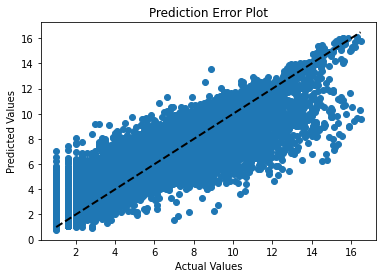

In [7]:
plt.scatter(best_actuals, best_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Error Plot")
plt.plot([best_actuals.min(), best_actuals.max()], [best_actuals.min(), best_actuals.max()], 'k--', lw=2)
plt.show()

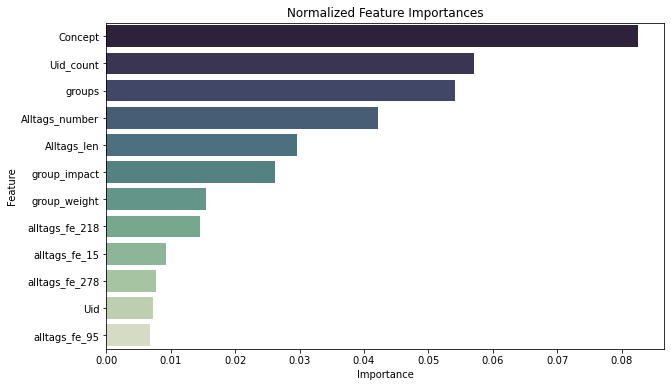

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract feature importances and normalize them for CatBoost
feature_importances = best_model.get_feature_importance(type='FeatureImportance')
normalized_feature_importances = feature_importances / sum(feature_importances)

# Assuming you have a way to get feature names, replace 'feature_names' with your feature names list
features = best_model.feature_names_  # Replace with your actual feature names if different
df_feature_importances = pd.DataFrame({'Feature': features, 'Importance': normalized_feature_importances})

# Sort the DataFrame by importance
df_feature_importances = df_feature_importances.sort_values('Importance', ascending=False).head(12)

# Plot using a color palette that reflects importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances, 
            palette=sns.cubehelix_palette(n_colors=12, start=.5, rot=-.75, reverse=True))
plt.title('Normalized Feature Importances')
plt.show()

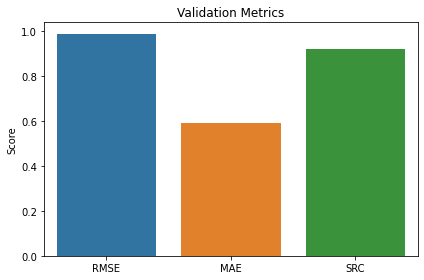

In [9]:
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array

metrics = ['RMSE', 'MAE', 'SRC']
plt.figure(figsize=(6, 4))

# Plotting the metrics
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

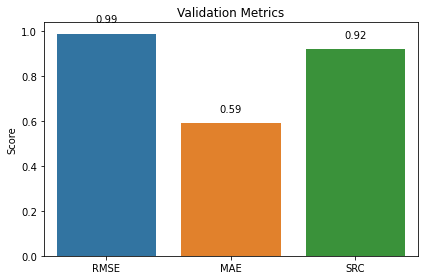

In [10]:
validation_metrics = np.array(valid_ans)  # Convert valid_ans to a numpy array

# Plotting the metrics
plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=validation_metrics)
plt.title('Validation Metrics')
plt.ylabel('Score')

# Adding exact values on top of the bars
for i, v in enumerate(validation_metrics):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

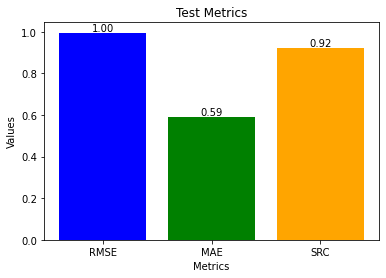

In [11]:
#Test bar graph

metrics = [test_rmse, test_mae, test_src]
labels = ['RMSE', 'MAE', 'SRC']

# Create a bar plot
plt.bar(labels, metrics, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics')

# Display the values on top of the bars
for i, value in enumerate(metrics):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()